In [1]:
import tensorflow as tf
from tensorflow import keras as keras
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.image as mpimg
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Lambda, LayerNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, History, EarlyStopping

In [2]:
from sample.functionImplemented import get_model, custom_loss, get_threshold, schedule, custom_scaler, get_opt_action, update_replay_helper, populate_replay_memory, update_replay_memory 
from sample.car import Car
from sample.track import Track
funcarr=[get_model, custom_loss, get_threshold, schedule, custom_scaler, get_opt_action, update_replay_helper, populate_replay_memory, update_replay_memory]

In [3]:
print(help(Car))
print("------------------------------------------------------------------------------------------------------------")
print(help(Track))

Help on class Car in module sample.car:

class Car(builtins.object)
 |  The car object has the following attributes:
 |  1. Track - the associated track
 |  2. current position: Current position on the track. Floating point coordinate.
 |  3. integer_position_: defined as current_position.astype('int16')
 |  4. Bool collided_on_last
 |  5. sensors: LIDAR type function
 |  6. init_speed_
 |  7. max_speed
 |  8. sampling frequency: The frequency of play.
 |  9. speed: Current speed
 |  10. car_angle: current car angle as define below.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, track, max_speed, sampling_frequency)
 |      track: The track as a track object
 |      max_speed: Max attainable speed
 |      sampling_frequency:
 |      
 |      car angle is defined as the angle of the (unimplemented) velocity vector from
 |      the standard mathematical X axis, i.e., 
 |      y ^
 |        |
 |        |
 |        |
 |        -------> x
 |      Positive is ACW.
 |  
 |  duplicate(

In [4]:
for func in funcarr:
    print (help(func))
    print ("------------------------------------------------------------------------------------------------------------")

Help on function get_model in module sample.functionImplemented:

get_model(layers, mode)
    Returns Sequential model based on layers and mode
    Parameters:
        layers: List of (num_neurons, activation, dropout)
        mode:   str, train or eval. Train has dropout, test does not
    Returns:
        A sequential class object

None
------------------------------------------------------------------------------------------------------------
Help on function custom_loss in module sample.functionImplemented:

custom_loss(gamma)
    Wrapper Custom loss function
    Parameters:
        gamma: The discounting parameter.
    Returns:
        loss function

None
------------------------------------------------------------------------------------------------------------
Help on function get_threshold in module sample.functionImplemented:

get_threshold(train_step)
    Returns p (in (0,1)) such that optimal action taken with probability p. 
    The policy is Greedy in the limit of infinity

[0 1] (882, 1174) 0


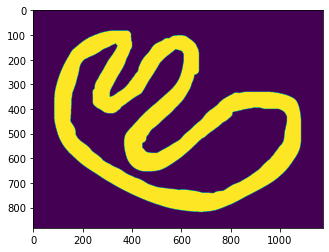

In [5]:
img = mpimg.imread("tracks/track_pic9.jpg")[:,:,0]
track1=(img<50).astype('int')

# img = mpimg.imread("tracks/track_pic5.jpg")[:,:,0] and spa
# track1=(img>0.7).astype('int')
print(np.unique(track1), track1.shape, track1[0][0])
track_rows, track_cols=track1.shape
pos_pos=np.where(track1==1)
spawning_positions=np.zeros((len(pos_pos[0]), 2))
spawning_positions[:, 0]=pos_pos[0]
spawning_positions[:, 1]=pos_pos[1]
spawning_positions=spawning_positions.astype('int')

track=Track(track1, 40)
plt.imshow(track1)
plt.show()

In [6]:
l=[[125, 269],
[330, 374],
[136, 539],
[363, 565],
[537, 615],
[368, 825],
[609, 978],
[745, 796],
[724, 441],
[568, 198]]

for (i,j) in l:
    track.add_checkpoints(i,j)
track.checkpoints=np.asarray(track.checkpoints)
track.spawn_at=np.asarray(track.spawn_at)

In [7]:
track.spawn_at

array([[125, 269],
       [330, 374],
       [136, 539],
       [363, 565],
       [537, 615],
       [368, 825],
       [609, 978],
       [745, 796],
       [724, 441],
       [568, 198]])

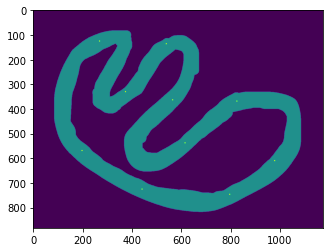

In [8]:
a=np.zeros(track1.shape)+ track1
for (ai, aj) in track.spawn_at:
    for d1 in range(-2, 3):
        for d2 in range(-2, 3):
            a[d1+ai, d2+aj]=2
plt.imshow(a)

<h6> Actions</h6><br>
For GameV2, we have throttle and steering.<br>
Throttle and Steering can be quantized into 7 values from [-1,1] including both.<br>
Therefore we have 49 actions.

In [9]:
throttle_quant=np.linspace(-1,1,9)
steer_quant=np.linspace(-1,1,7)
actions=np.asarray([(throttle, steer) for throttle in throttle_quant for steer in steer_quant])

<h6> Declaring the training constants</h6>

In [10]:
insert_index=[0]
max_force=10
data_scaler=np.asarray([
    100, 100, 100, 100,
    100, 100, 100, 100,
    50, 1, 1
])
gamma=0.96
usescaler=True
inputcolumns=[i for i in range(12) if i!=9]


<h6>Model Declaration</h6>

In [11]:
layers=[
(50, 'relu', 0.2),
(100, 'relu', 0.2),
(90, 'relu', 0.2),
(20, 'relu', 0.2),
(500, 'relu', 0.2)
]

target_model=get_model(layers, 'eval')

make_consistent_net=get_model(layers, 'Train')

keep_safe=get_model(layers, 'eval')

"""
The following callbacks are for the make_consistent_net only.
"""
early_stop=EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='min')
history=History()
learning_scheduler=LearningRateScheduler(schedule)

opt1=keras.optimizers.Adam(lr=0.001)
make_consistent_net.compile(loss=custom_loss(gamma), optimizer=opt1)
target_model.compile(loss=custom_loss(gamma), optimizer='adam')

In [12]:
make_consistent_net=tf.keras.models.load_model("TrainedModels/trainedModelspa1.h5", custom_objects={'cl':custom_loss(gamma)})

In [13]:
replay_size=500
replay_memory=np.zeros((replay_size, 24))
train_y=np.zeros((replay_size, 2))

In [14]:
val_loss_hist=[]
train_loss_hist=[]

In [15]:
global exploration
exploration=np.zeros((track_rows, track_cols))

In [16]:
np.where(exploration==1)

(array([], dtype=int64), array([], dtype=int64))

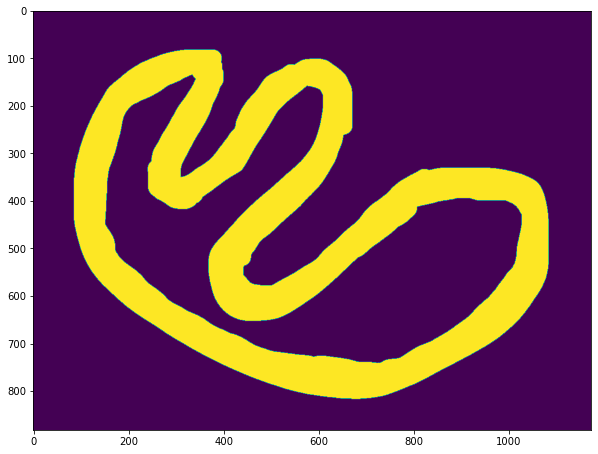

In [17]:
fig=plt.figure(figsize=(10, 10))
plt.imshow(exploration+track1)
plt.show()

In [18]:
car=Car(track, 80, sampling_frequency=10.0)

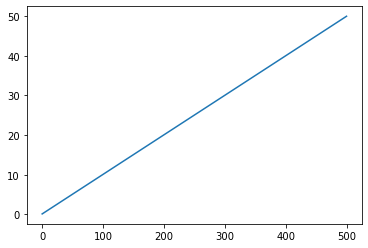

Unique speed values are: [0.         0.05409255 0.05409255 0.05409255 0.05409255 0.07073815
 0.08333333 0.10092521 0.16421356 0.16421356 0.16421356 0.16666667
 0.16666667 0.16666667 0.17926185 0.17926185 0.19590745 0.25
 0.30409255 0.30409255 0.33333333 0.33578644 0.35092521 0.35092521
 0.39907479 0.41421356 0.41421356 0.41421356 0.41421356 0.41666667
 0.41666667 0.41666667 0.42926185 0.44590745 0.44590745 0.55409255
 0.55409255 0.55409255 0.55409255 0.57073815 0.60092521 0.64907479
 0.66421356 0.66421356 0.66421356 0.66666667 0.69590745 0.75
 0.80409255 0.80409255 0.82073815 0.83333333 0.85092521 0.85092521
 0.89907479 0.91421356 0.91421356 0.91421356 0.91666667 0.91666667
 0.92926185 0.92926185 0.92926185 0.94590745 0.94590745 0.94590745
 1.03077641 1.05409255 1.05409255 1.05409255 1.05409255 1.05409255
 1.11803399 1.14907479 1.16421356 1.16421356 1.16421356 1.16666667
 1.17926185 1.19590745 1.25       1.30409255 1.30409255 1.30409255
 1.30409255 1.39907479 1.41421356 1.41421356 1.41

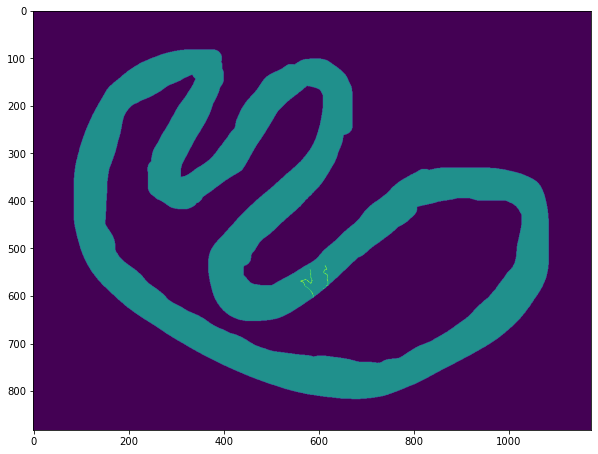

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 13s 29ms/sample - loss: 11.0180 - val_loss: 0.7878
Epoch 2/5
450/450 [==============================] - 4s 10ms/sample - loss: 3.1427 - val_loss: 0.7971
Epoch 3/5
450/450 [==============================] - 4s 10ms/sample - loss: 3.0405 - val_loss: 0.8290
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.0123 - val_loss: 0.8797
Epoch 5/5
450/450 [==============================] - 6s 13ms/sample - loss: 3.0087 - val_loss: 0.7427


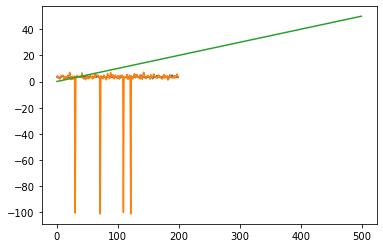

Unique speed values are: [0.00000000e+00 2.22044605e-16 8.57864376e-02 8.57864376e-02
 8.57864376e-02 8.57864376e-02 1.64213562e-01 1.64213562e-01
 1.64213562e-01 1.64213562e-01 2.50000000e-01 2.50000000e-01
 2.50000000e-01 2.50000000e-01 2.50000000e-01 2.50000000e-01
 2.50000000e-01 2.50000000e-01 3.35786438e-01 3.35786438e-01
 4.14213562e-01 4.14213562e-01 4.14213562e-01 5.00000000e-01
 5.00000000e-01 5.00000000e-01 5.00000000e-01 5.85786438e-01
 6.64213562e-01 7.50000000e-01 7.50000000e-01 7.50000000e-01
 7.50000000e-01 8.35786438e-01 8.35786438e-01 8.68033989e-01
 9.14213562e-01 1.00000000e+00 1.00000000e+00 1.08578644e+00
 1.08578644e+00 1.11803399e+00 1.25000000e+00 1.25000000e+00
 1.36803399e+00 1.41421356e+00 1.41421356e+00 1.50000000e+00
 1.50000000e+00 1.50000000e+00 1.58578644e+00 1.61803399e+00
 1.66421356e+00 1.75000000e+00 1.83578644e+00 1.86803399e+00
 1.91421356e+00 1.91421356e+00 2.00000000e+00 2.00000000e+00
 2.08578644e+00 2.11803399e+00 2.16421356e+00 2.25000000e+00

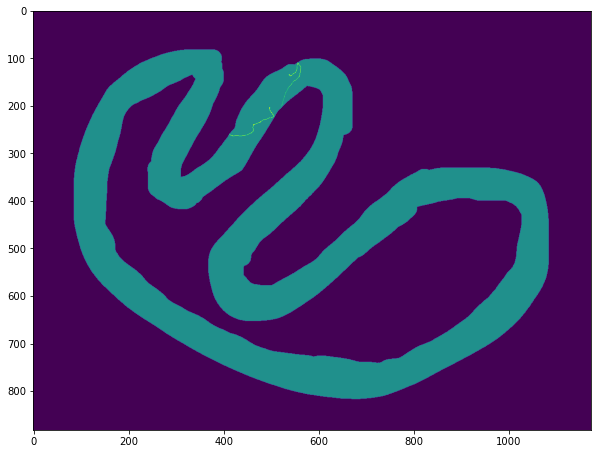

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 4s 10ms/sample - loss: 2.8765 - val_loss: 2.7924
Epoch 2/5
450/450 [==============================] - 5s 10ms/sample - loss: 2.7746 - val_loss: 2.6301
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.6781 - val_loss: 2.7178
Epoch 4/5
450/450 [==============================] - 4s 10ms/sample - loss: 2.6109 - val_loss: 2.7064
Epoch 5/5
450/450 [==============================] - 5s 10ms/sample - loss: 2.5623 - val_loss: 2.7185


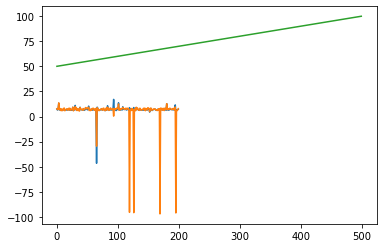

Unique speed values are: [0.00000000e+00 3.46621490e-03 8.57864376e-02 8.57864376e-02
 1.18033989e-01 1.64213562e-01 2.46533785e-01 3.35786438e-01
 3.50925213e-01 3.81966011e-01 3.99074787e-01 4.14213562e-01
 4.14213562e-01 4.14213562e-01 5.03466215e-01 5.85786438e-01
 5.85786438e-01 6.00925213e-01 6.18033989e-01 6.66666667e-01
 8.35786438e-01 8.35786438e-01 8.35786438e-01 8.50925213e-01
 8.81966011e-01 8.99074787e-01 9.14213562e-01 1.00346621e+00
 1.08578644e+00 1.08578644e+00 1.10092521e+00 1.11803399e+00
 1.16421356e+00 1.25000000e+00 1.25346621e+00 1.35092521e+00
 1.38196601e+00 1.39907479e+00 1.41421356e+00 1.41666667e+00
 1.50346621e+00 1.58578644e+00 1.60092521e+00 1.64907479e+00
 1.66666667e+00 1.83578644e+00 1.83578644e+00 1.85092521e+00
 1.88196601e+00 1.91666667e+00 2.00346621e+00 2.08578644e+00
 2.14907479e+00 2.16421356e+00 2.16666667e+00 2.25346621e+00
 2.33578644e+00 2.39907479e+00 2.50346621e+00 2.58578644e+00
 2.64907479e+00 2.64907479e+00 2.66666667e+00 2.75346621e+00

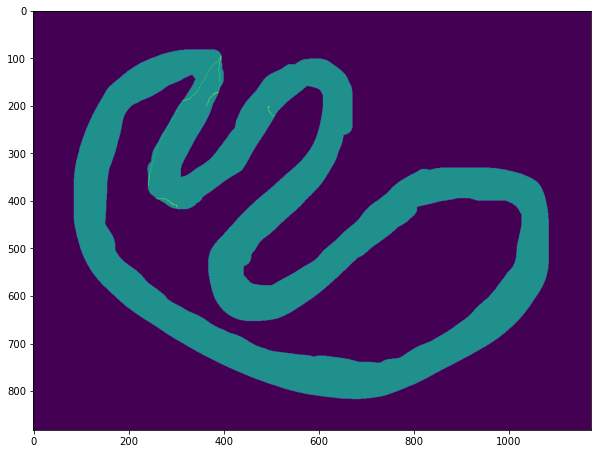

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 10ms/sample - loss: 3.3968 - val_loss: 2.6906
Epoch 2/5
450/450 [==============================] - 5s 10ms/sample - loss: 2.9881 - val_loss: 2.6765
Epoch 3/5
450/450 [==============================] - 5s 10ms/sample - loss: 3.0635 - val_loss: 2.6874
Epoch 4/5
450/450 [==============================] - 5s 10ms/sample - loss: 2.9385 - val_loss: 2.7398
Epoch 5/5
450/450 [==============================] - 5s 10ms/sample - loss: 2.8864 - val_loss: 2.6859


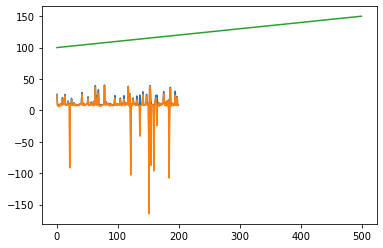

Unique speed values are: [ 0.          0.08333333  0.08578644  0.11803399  0.16421356  0.33333333
  0.33333333  0.33578644  0.41421356  0.41421356  0.5         0.58333333
  0.61803399  0.66666667  0.83333333  0.83333333  0.86803399  0.91421356
  0.91421356  0.91421356  1.05409255  1.08333333  1.08333333  1.08578644
  1.08578644  1.11803399  1.11803399  1.16421356  1.16421356  1.20185043
  1.25        1.33578644  1.36803399  1.41421356  1.41421356  1.41421356
  1.5         1.55409255  1.61803399  1.66421356  1.66666667  1.70185043
  1.83333333  1.86803399  1.86803399  1.91421356  1.91421356  2.08578644
  2.11803399  2.16421356  2.36803399  2.41421356  2.41421356  2.61803399
  2.66421356  2.66666667  2.70185043  2.86803399  2.91421356  2.91421356
  3.11803399  3.16421356  3.16421356  3.16666667  3.16666667  3.36803399
  3.41421356  3.41666667  3.41666667  3.66421356  3.70185043  3.86803399
  3.91421356  3.91666667  4.16421356  4.16421356  4.16666667  4.41421356
  4.61803399  4.66421356  

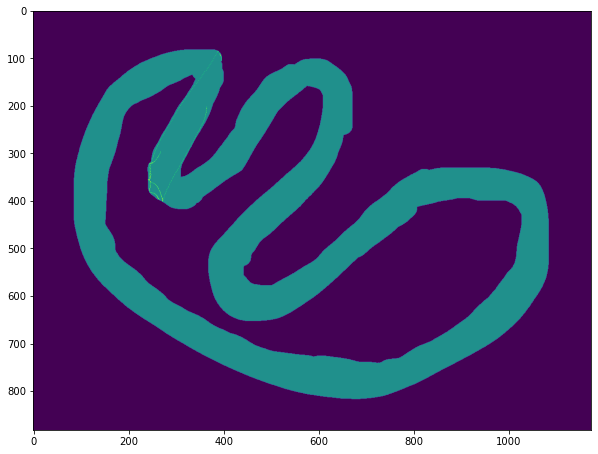

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 4s 10ms/sample - loss: 5.0345 - val_loss: 2.2478
Epoch 2/5
450/450 [==============================] - 4s 9ms/sample - loss: 4.6124 - val_loss: 1.7070
Epoch 3/5
450/450 [==============================] - 5s 10ms/sample - loss: 4.5730 - val_loss: 1.6001
Epoch 4/5
450/450 [==============================] - 5s 10ms/sample - loss: 4.4199 - val_loss: 2.0543
Epoch 5/5
450/450 [==============================] - 5s 10ms/sample - loss: 4.4216 - val_loss: 2.1181


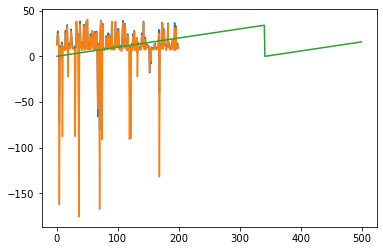

Unique speed values are: [0.00000000e+00 3.07764064e-02 1.18033989e-01 1.18033989e-01
 1.18033989e-01 1.18033989e-01 1.18033989e-01 1.31966011e-01
 1.31966011e-01 1.31966011e-01 1.31966011e-01 1.31966011e-01
 1.49074787e-01 1.66666667e-01 2.50000000e-01 2.80776406e-01
 2.80776406e-01 3.50925213e-01 3.68033989e-01 3.68033989e-01
 3.68033989e-01 3.81966011e-01 3.99074787e-01 3.99074787e-01
 5.00000000e-01 6.00925213e-01 6.31966011e-01 6.31966011e-01
 6.31966011e-01 6.31966011e-01 6.31966011e-01 6.31966011e-01
 6.49074787e-01 6.66666667e-01 6.66666667e-01 8.68033989e-01
 8.81966011e-01 8.81966011e-01 8.81966011e-01 8.81966011e-01
 1.03077641e+00 1.03077641e+00 1.11803399e+00 1.11803399e+00
 1.11803399e+00 1.13196601e+00 1.13196601e+00 1.13196601e+00
 1.14907479e+00 1.16666667e+00 1.25000000e+00 1.28077641e+00
 1.35092521e+00 1.36803399e+00 1.38196601e+00 1.38196601e+00
 1.38196601e+00 1.39907479e+00 1.50000000e+00 1.53077641e+00
 1.61803399e+00 1.63196601e+00 1.63196601e+00 1.63196601e+00

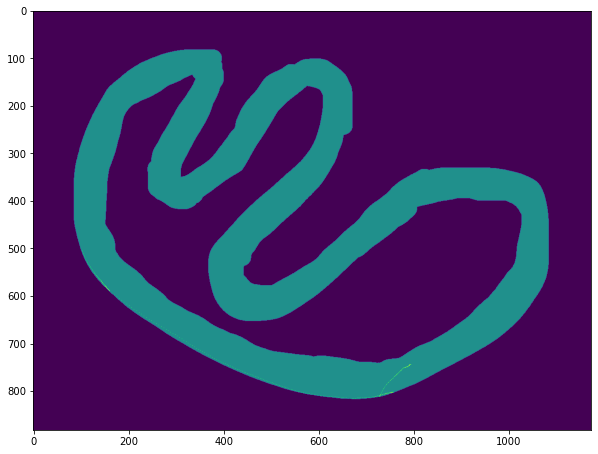

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 4s 10ms/sample - loss: 2.1982 - val_loss: 3.2343
Epoch 2/5
450/450 [==============================] - 4s 10ms/sample - loss: 1.9946 - val_loss: 3.0285
Epoch 3/5
450/450 [==============================] - 3s 7ms/sample - loss: 1.9001 - val_loss: 3.1705
Epoch 4/5
450/450 [==============================] - 4s 9ms/sample - loss: 1.9226 - val_loss: 3.0501
Epoch 5/5
450/450 [==============================] - 4s 8ms/sample - loss: 1.7562 - val_loss: 3.1032


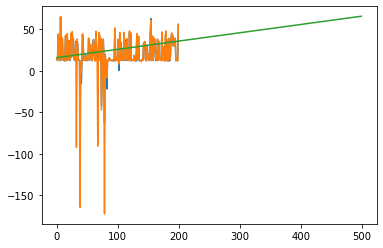

Unique speed values are: [0.00000000e+00 2.22044605e-16 3.33066907e-16 5.40925534e-02
 5.40925534e-02 5.40925534e-02 8.57864376e-02 8.57864376e-02
 1.18033989e-01 1.31966011e-01 1.31966011e-01 1.64213562e-01
 1.95907447e-01 2.19223594e-01 2.19223594e-01 2.50000000e-01
 2.50000000e-01 2.80776406e-01 3.35786438e-01 3.35786438e-01
 3.68033989e-01 3.68033989e-01 3.68033989e-01 3.68033989e-01
 3.68033989e-01 3.81966011e-01 3.81966011e-01 4.14213562e-01
 4.14213562e-01 4.14213562e-01 4.14213562e-01 4.45907447e-01
 4.45907447e-01 5.00000000e-01 5.00000000e-01 5.00000000e-01
 5.00000000e-01 5.30776406e-01 5.85786438e-01 5.85786438e-01
 6.18033989e-01 6.18033989e-01 6.31966011e-01 6.31966011e-01
 6.31966011e-01 6.31966011e-01 6.31966011e-01 6.31966011e-01
 6.64213562e-01 7.50000000e-01 7.80776406e-01 8.04092553e-01
 8.68033989e-01 8.81966011e-01 8.81966011e-01 9.14213562e-01
 9.14213562e-01 9.45907447e-01 9.45907447e-01 1.00000000e+00
 1.00000000e+00 1.03077641e+00 1.05409255e+00 1.05409255e+00

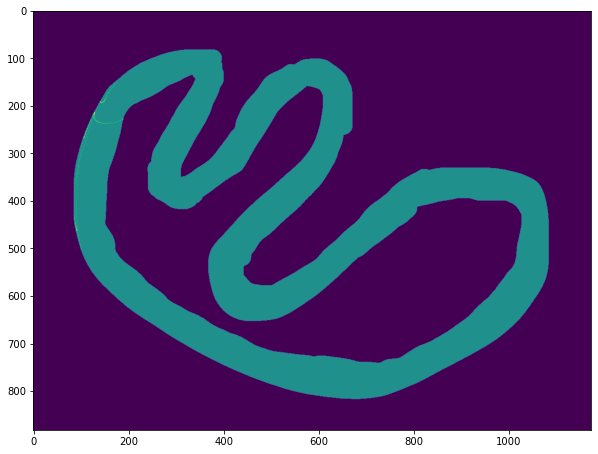

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 4s 9ms/sample - loss: 7.7709 - val_loss: 7.1202
Epoch 2/5
450/450 [==============================] - 4s 10ms/sample - loss: 6.9454 - val_loss: 6.3791
Epoch 3/5
450/450 [==============================] - 5s 10ms/sample - loss: 6.2664 - val_loss: 5.8838
Epoch 4/5
450/450 [==============================] - 4s 10ms/sample - loss: 5.9992 - val_loss: 5.8879
Epoch 5/5
450/450 [==============================] - 4s 10ms/sample - loss: 5.7673 - val_loss: 6.2151
Zero Movement recorded. Speed is:  0.0  sampling_frequency is:  10.0


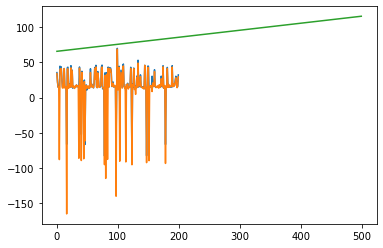

Unique speed values are: [0.00000000e+00 4.81495748e-02 5.40925534e-02 8.33333333e-02
 8.33333333e-02 8.33333333e-02 8.57864376e-02 8.57864376e-02
 1.64213562e-01 1.64213562e-01 1.64213562e-01 1.64213562e-01
 1.64213562e-01 1.66666667e-01 1.66666667e-01 1.66666667e-01
 1.95907447e-01 2.50000000e-01 2.98149575e-01 3.33333333e-01
 3.33333333e-01 3.35786438e-01 3.35786438e-01 3.35786438e-01
 3.35786438e-01 4.14213562e-01 4.14213562e-01 4.14213562e-01
 4.16666667e-01 4.16666667e-01 4.16666667e-01 4.16666667e-01
 4.51850425e-01 4.51850425e-01 4.51850425e-01 5.48149575e-01
 5.48149575e-01 5.83333333e-01 5.83333333e-01 5.83333333e-01
 5.83333333e-01 5.85786438e-01 5.85786438e-01 5.85786438e-01
 6.64213562e-01 6.64213562e-01 6.64213562e-01 6.66666667e-01
 7.01850425e-01 8.04092553e-01 8.33333333e-01 8.33333333e-01
 8.33333333e-01 8.33333333e-01 8.35786438e-01 8.35786438e-01
 9.14213562e-01 9.14213562e-01 9.16666667e-01 9.16666667e-01
 9.45907447e-01 9.45907447e-01 1.03077641e+00 1.04814957e+00

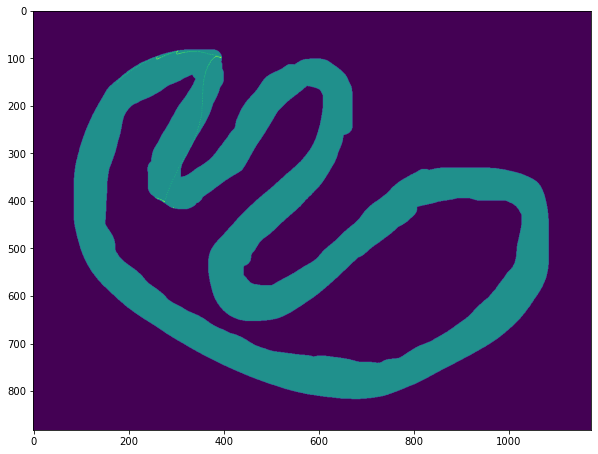

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 4s 8ms/sample - loss: 2.9524 - val_loss: 3.5351
Epoch 2/5
450/450 [==============================] - 4s 10ms/sample - loss: 2.7066 - val_loss: 3.4499
Epoch 3/5
450/450 [==============================] - 3s 8ms/sample - loss: 2.6107 - val_loss: 3.3636
Epoch 4/5
450/450 [==============================] - 3s 7ms/sample - loss: 2.5944 - val_loss: 3.8528
Epoch 5/5
450/450 [==============================] - 3s 7ms/sample - loss: 2.5161 - val_loss: 3.6970
Zero Movement recorded. Speed is:  0.0  sampling_frequency is:  10.0


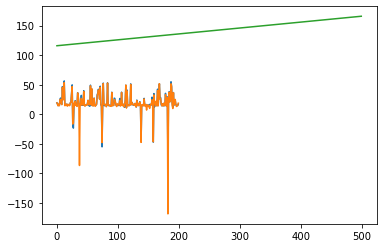

Unique speed values are: [0.00000000e+00 1.11022302e-16 4.81495748e-02 5.40925534e-02
 7.07381501e-02 7.07381501e-02 8.33333333e-02 8.57864376e-02
 8.57864376e-02 8.57864376e-02 8.57864376e-02 8.57864376e-02
 8.57864376e-02 8.57864376e-02 1.64213562e-01 1.64213562e-01
 1.64213562e-01 1.64213562e-01 1.64213562e-01 1.64213562e-01
 1.66666667e-01 1.66666667e-01 2.01850425e-01 2.01850425e-01
 2.50000000e-01 2.50000000e-01 2.50000000e-01 2.50000000e-01
 2.50000000e-01 2.98149575e-01 3.20738150e-01 3.20738150e-01
 3.20738150e-01 3.33333333e-01 3.33333333e-01 3.35786438e-01
 3.35786438e-01 3.35786438e-01 3.35786438e-01 3.35786438e-01
 4.14213562e-01 4.14213562e-01 4.14213562e-01 4.14213562e-01
 4.14213562e-01 4.14213562e-01 4.16666667e-01 4.16666667e-01
 4.16666667e-01 4.16666667e-01 4.51850425e-01 5.00000000e-01
 5.00000000e-01 5.48149575e-01 5.70738150e-01 5.83333333e-01
 5.83333333e-01 5.85786438e-01 5.85786438e-01 5.85786438e-01
 5.85786438e-01 5.85786438e-01 5.85786438e-01 6.64213562e-01

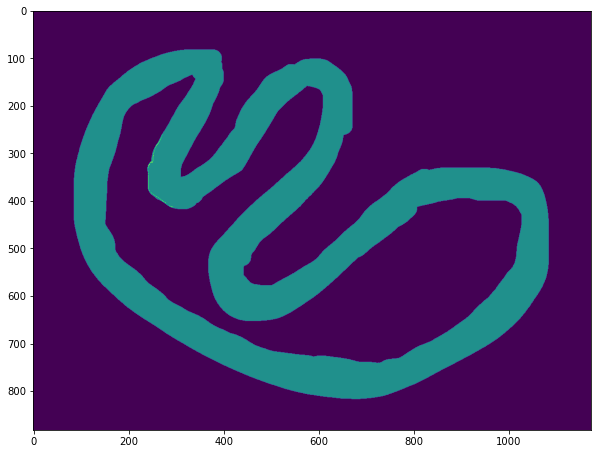

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 4s 10ms/sample - loss: 14.9585 - val_loss: 16.0816
Epoch 2/5
450/450 [==============================] - 5s 11ms/sample - loss: 14.1466 - val_loss: 16.5792
Epoch 3/5
450/450 [==============================] - 5s 10ms/sample - loss: 13.7688 - val_loss: 16.2104
Epoch 4/5
450/450 [==============================] - 5s 10ms/sample - loss: 13.5359 - val_loss: 16.9171
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 13.3125 - val_loss: 17.2438
Zero Movement recorded. Speed is:  0.0  sampling_frequency is:  10.0


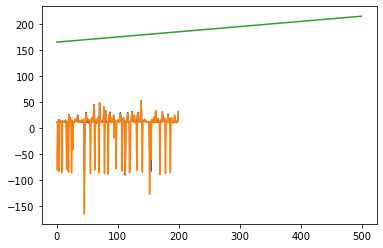

Unique speed values are: [0.00000000e+00 2.22044605e-16 2.49800181e-16 5.40925534e-02
 5.40925534e-02 5.40925534e-02 5.40925534e-02 5.40925534e-02
 5.40925534e-02 7.07381501e-02 7.07381501e-02 7.07381501e-02
 7.07381501e-02 7.07381501e-02 7.07381501e-02 7.07381501e-02
 7.07381501e-02 8.33333333e-02 8.33333333e-02 8.33333333e-02
 8.33333333e-02 8.33333333e-02 8.33333333e-02 8.57864376e-02
 8.57864376e-02 8.57864376e-02 1.00925213e-01 1.00925213e-01
 1.00925213e-01 1.31966011e-01 1.49074787e-01 1.64213562e-01
 1.64213562e-01 1.66666667e-01 1.66666667e-01 1.66666667e-01
 1.79261850e-01 1.79261850e-01 1.79261850e-01 1.79261850e-01
 1.79261850e-01 1.79261850e-01 1.79261850e-01 1.79261850e-01
 1.95907447e-01 1.95907447e-01 1.95907447e-01 1.95907447e-01
 1.95907447e-01 2.50000000e-01 2.50000000e-01 2.50000000e-01
 2.87999688e-01 3.04092553e-01 3.04092553e-01 3.04092553e-01
 3.04092553e-01 3.20738150e-01 3.20738150e-01 3.20738150e-01
 3.20738150e-01 3.20738150e-01 3.20738150e-01 3.20738150e-01

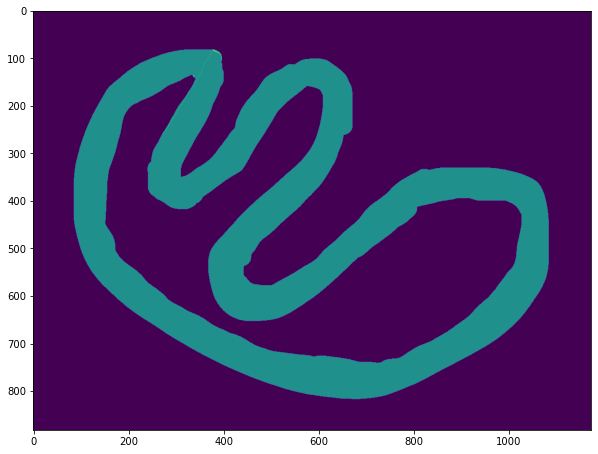

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 4s 10ms/sample - loss: 9.8482 - val_loss: 14.3520
Epoch 2/5
450/450 [==============================] - 4s 9ms/sample - loss: 9.5497 - val_loss: 13.6760
Epoch 3/5
450/450 [==============================] - 5s 10ms/sample - loss: 9.4924 - val_loss: 13.4463
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 9.2788 - val_loss: 13.4666
Epoch 5/5
450/450 [==============================] - 6s 13ms/sample - loss: 9.1483 - val_loss: 14.0248
Zero Movement recorded. Speed is:  0.0  sampling_frequency is:  10.0
Zero Movement recorded. Speed is:  0.0  sampling_frequency is:  10.0
Zero Movement recorded. Speed is:  0.0  sampling_frequency is:  10.0
Zero Movement recorded. Speed is:  0.0  sampling_frequency is:  10.0
Zero Movement recorded. Speed is:  0.0  sampling_frequency is:  10.0
Zero Movement recorded. Speed is:  0.0  sampling_frequency is:  10.0
Zero Movement recorded. Spe

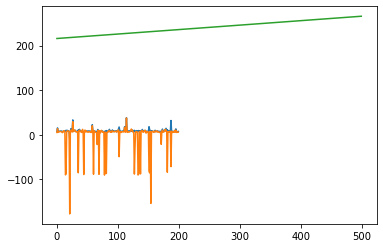

Unique speed values are: [0.00000000e+00 2.77555756e-17 1.11022302e-16 1.38777878e-16
 1.66533454e-16 1.94289029e-16 2.22044605e-16 4.44089210e-16
 3.07764064e-02 3.07764064e-02 3.79996879e-02 5.40925534e-02
 7.07381501e-02 7.07381501e-02 7.07381501e-02 8.33333333e-02
 1.00925213e-01 1.18033989e-01 1.31966011e-01 1.66666667e-01
 1.66666667e-01 1.66666667e-01 1.79261850e-01 1.79261850e-01
 1.95907447e-01 1.95907447e-01 1.95907447e-01 2.01850425e-01
 2.19223594e-01 2.46533785e-01 2.50000000e-01 2.50000000e-01
 2.50000000e-01 2.50000000e-01 2.50000000e-01 2.50000000e-01
 2.50000000e-01 2.50000000e-01 2.50000000e-01 2.53466215e-01
 2.80776406e-01 3.04092553e-01 3.33333333e-01 3.33333333e-01
 3.33333333e-01 3.50925213e-01 4.14213562e-01 4.16666667e-01
 4.16666667e-01 4.16666667e-01 4.51850425e-01 5.00000000e-01
 5.00000000e-01 5.00000000e-01 5.00000000e-01 5.00000000e-01
 5.03466215e-01 5.30776406e-01 5.37999688e-01 5.48149575e-01
 5.54092553e-01 5.83333333e-01 6.00925213e-01 6.00925213e-01

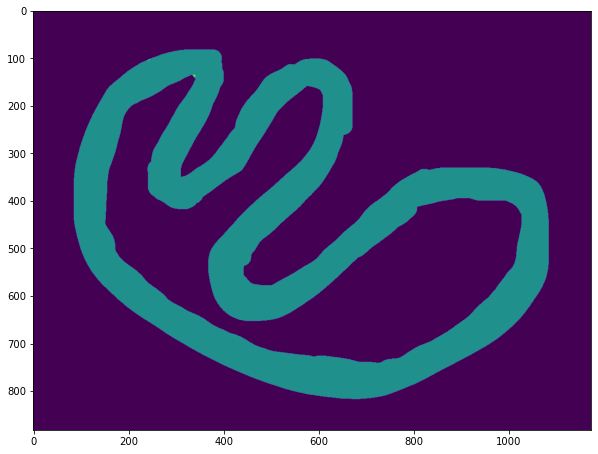

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 4s 9ms/sample - loss: 24.0520 - val_loss: 22.3364
Epoch 2/5
450/450 [==============================] - 5s 10ms/sample - loss: 17.4598 - val_loss: 21.8858
Epoch 3/5
450/450 [==============================] - 4s 10ms/sample - loss: 17.6182 - val_loss: 22.5109
Epoch 4/5
450/450 [==============================] - 5s 12ms/sample - loss: 16.9259 - val_loss: 22.6850
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 16.9053 - val_loss: 22.0673
Zero Movement recorded. Speed is:  0.0  sampling_frequency is:  10.0
Zero Movement recorded. Speed is:  0.0  sampling_frequency is:  10.0


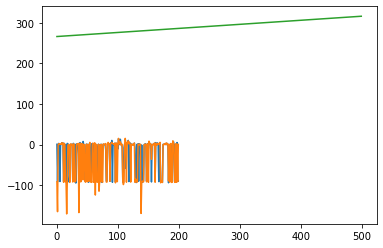

Unique speed values are: [0.00000000e+00 1.38777878e-16 2.22044605e-16 3.07764064e-02
 3.79996879e-02 5.40925534e-02 5.40925534e-02 7.07381501e-02
 7.07381501e-02 8.57864376e-02 8.57864376e-02 8.57864376e-02
 8.57864376e-02 8.57864376e-02 8.57864376e-02 8.57864376e-02
 8.57864376e-02 1.18033989e-01 1.64213562e-01 1.64213562e-01
 1.64213562e-01 1.64213562e-01 1.64213562e-01 1.64213562e-01
 1.64213562e-01 1.64213562e-01 1.66666667e-01 1.66666667e-01
 1.66666667e-01 1.79261850e-01 2.50000000e-01 2.50000000e-01
 2.50000000e-01 2.80776406e-01 3.35786438e-01 3.35786438e-01
 3.35786438e-01 3.35786438e-01 3.35786438e-01 3.35786438e-01
 3.81966011e-01 4.14213562e-01 4.14213562e-01 4.14213562e-01
 4.14213562e-01 4.14213562e-01 4.14213562e-01 4.14213562e-01
 4.14213562e-01 4.14213562e-01 4.16666667e-01 5.00000000e-01
 5.00000000e-01 5.00000000e-01 5.30776406e-01 5.70738150e-01
 5.83333333e-01 5.85786438e-01 5.85786438e-01 5.85786438e-01
 5.85786438e-01 5.85786438e-01 6.00925213e-01 6.18033989e-01

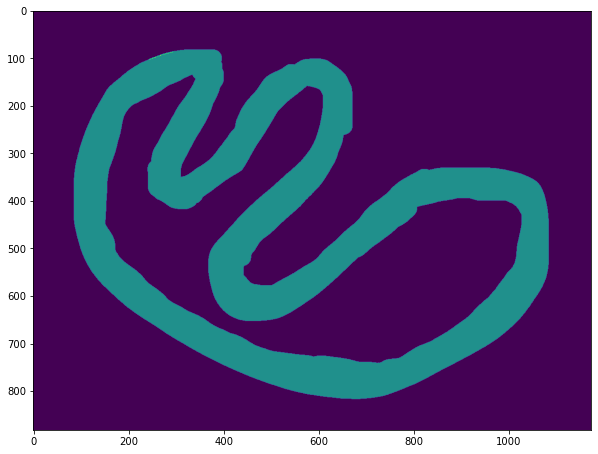

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 14.6217 - val_loss: 23.6889
Epoch 2/5
450/450 [==============================] - 4s 9ms/sample - loss: 14.2985 - val_loss: 23.9212
Epoch 3/5
450/450 [==============================] - 4s 10ms/sample - loss: 14.1055 - val_loss: 23.0317
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 13.7569 - val_loss: 22.6804
Epoch 5/5
450/450 [==============================] - 4s 10ms/sample - loss: 13.9018 - val_loss: 22.6452
Zero Movement recorded. Speed is:  0.0  sampling_frequency is:  10.0


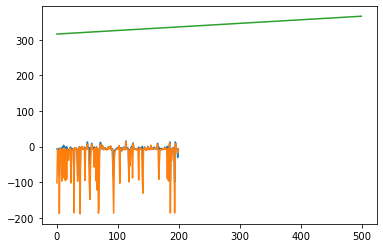

Unique speed values are: [0.00000000e+00 3.46621490e-03 3.46621490e-03 5.40925534e-02
 5.40925534e-02 7.07381501e-02 8.57864376e-02 8.57864376e-02
 8.57864376e-02 8.57864376e-02 1.18033989e-01 1.18033989e-01
 1.18033989e-01 1.18033989e-01 1.18033989e-01 1.31966011e-01
 1.64213562e-01 1.64213562e-01 1.64213562e-01 1.66666667e-01
 1.66666667e-01 1.95907447e-01 2.01850425e-01 2.46533785e-01
 2.50000000e-01 2.50000000e-01 2.50000000e-01 2.50000000e-01
 3.35786438e-01 3.35786438e-01 3.35786438e-01 3.35786438e-01
 3.68033989e-01 3.68033989e-01 3.68033989e-01 3.81966011e-01
 3.81966011e-01 4.14213562e-01 4.14213562e-01 4.14213562e-01
 4.14213562e-01 4.16666667e-01 4.16666667e-01 4.45907447e-01
 4.51850425e-01 4.96533785e-01 4.96533785e-01 5.00000000e-01
 5.03466215e-01 5.54092553e-01 5.54092553e-01 5.85786438e-01
 5.85786438e-01 6.18033989e-01 6.18033989e-01 6.31966011e-01
 6.31966011e-01 6.31966011e-01 6.31966011e-01 6.31966011e-01
 6.64213562e-01 6.64213562e-01 6.64213562e-01 6.64213562e-01

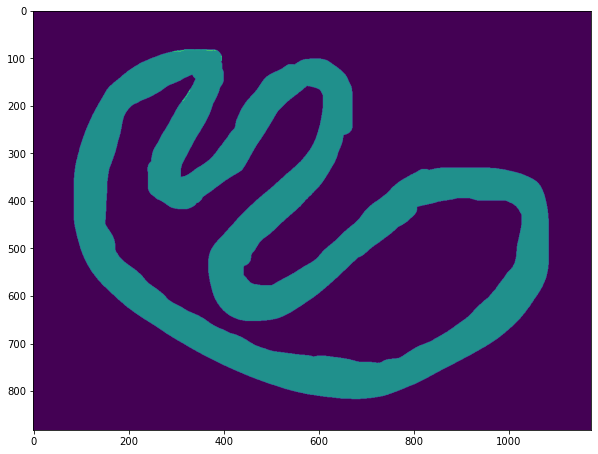

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 4s 9ms/sample - loss: 13.2192 - val_loss: 8.8186
Epoch 2/5
450/450 [==============================] - 5s 10ms/sample - loss: 12.0224 - val_loss: 9.0223
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 11.5329 - val_loss: 7.8020
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 11.1989 - val_loss: 8.1396
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 11.1192 - val_loss: 8.8404


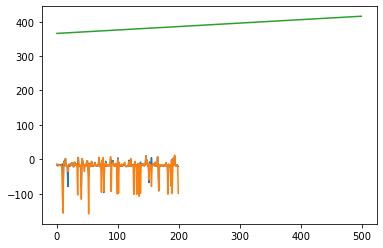

Unique speed values are: [ 0.          0.05409255  0.08333333  0.08578644  0.11803399  0.16421356
  0.16421356  0.16666667  0.19590745  0.25        0.25        0.33333333
  0.33578644  0.33578644  0.41421356  0.41421356  0.41421356  0.41666667
  0.49653379  0.58333333  0.58333333  0.58578644  0.58578644  0.60092521
  0.61803399  0.63196601  0.63196601  0.66421356  0.66666667  0.71200031
  0.75        0.75        0.80409255  0.83333333  0.83333333  0.83578644
  0.88196601  0.91421356  0.91421356  0.91421356  0.91421356  0.95185043
  0.96200031  1.          1.08333333  1.08578644  1.11803399  1.16421356
  1.20185043  1.20185043  1.20185043  1.25        1.25        1.33333333
  1.33333333  1.33578644  1.33578644  1.36803399  1.38196601  1.41421356
  1.41421356  1.41421356  1.44590745  1.46200031  1.58333333  1.58333333
  1.58333333  1.58578644  1.60092521  1.61803399  1.63196601  1.66421356
  1.83333333  1.83578644  1.83578644  1.88196601  1.91421356  1.94590745
  1.95185043  2.          

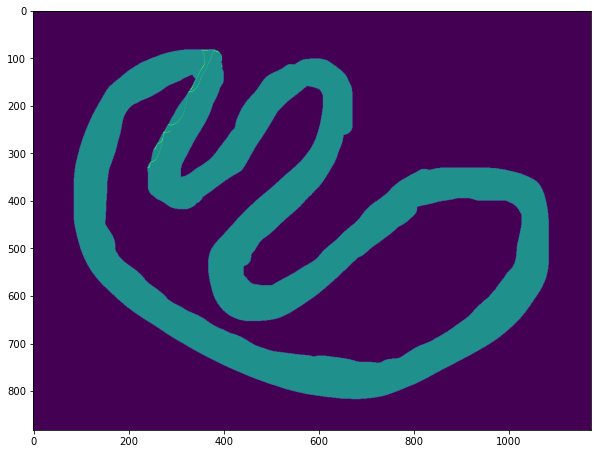

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 9.3516 - val_loss: 18.7044
Epoch 2/5
450/450 [==============================] - 6s 13ms/sample - loss: 8.2033 - val_loss: 18.6154
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 8.1933 - val_loss: 18.3917
Epoch 4/5
450/450 [==============================] - 5s 10ms/sample - loss: 7.9076 - val_loss: 18.4491
Epoch 5/5
450/450 [==============================] - 6s 12ms/sample - loss: 7.7931 - val_loss: 18.5517


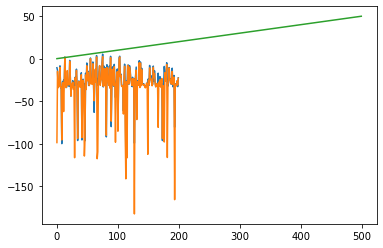

Unique speed values are: [0.00000000e+00 5.40925534e-02 5.40925534e-02 8.57864376e-02
 1.64213562e-01 1.95907447e-01 2.87999688e-01 3.33333333e-01
 4.14213562e-01 4.16666667e-01 6.66666667e-01 7.12000312e-01
 8.35786438e-01 9.51850425e-01 1.00000000e+00 1.05409255e+00
 1.11803399e+00 1.16421356e+00 1.19590745e+00 1.20185043e+00
 1.20185043e+00 1.25000000e+00 1.28799969e+00 1.41421356e+00
 1.41421356e+00 1.41421356e+00 1.41666667e+00 1.44590745e+00
 1.46200031e+00 1.58578644e+00 1.66421356e+00 2.19590745e+00
 2.20185043e+00 2.28799969e+00 2.33333333e+00 2.41421356e+00
 2.41666667e+00 2.58333333e+00 2.66421356e+00 2.83333333e+00
 2.83578644e+00 3.00000000e+00 3.19590745e+00 3.20185043e+00
 3.28799969e+00 3.41421356e+00 3.41666667e+00 3.44590745e+00
 4.00000000e+00 4.08578644e+00 4.16421356e+00 4.20185043e+00
 4.21200031e+00 4.28799969e+00 4.41666667e+00 4.44590745e+00
 4.75000000e+00 4.83333333e+00 4.83578644e+00 4.91421356e+00
 5.19590745e+00 5.20185043e+00 5.28799969e+00 5.41666667e+00

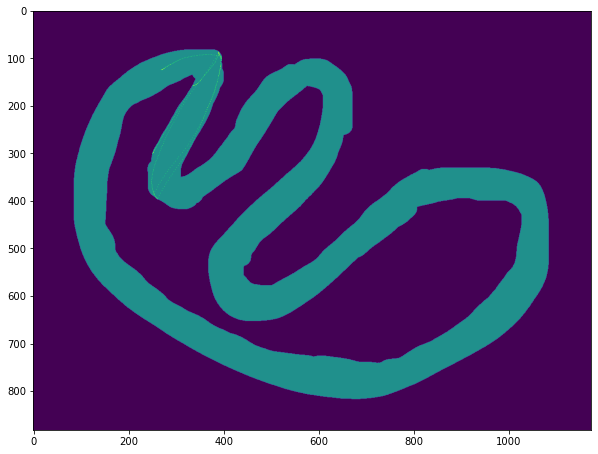

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 10ms/sample - loss: 7.3626 - val_loss: 7.6565
Epoch 2/5
450/450 [==============================] - 5s 10ms/sample - loss: 6.9263 - val_loss: 8.2603
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 6.5717 - val_loss: 7.3805
Epoch 4/5
450/450 [==============================] - 5s 10ms/sample - loss: 6.3174 - val_loss: 7.3101
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 6.2757 - val_loss: 7.0276


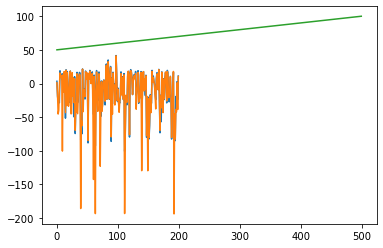

Unique speed values are: [0.00000000e+00 5.40925534e-02 1.64213562e-01 2.50000000e-01
 2.50000000e-01 3.20738150e-01 5.00000000e-01 6.64213562e-01
 7.50000000e-01 8.20738150e-01 8.20738150e-01 8.33333333e-01
 9.14213562e-01 1.00000000e+00 1.03077641e+00 1.05409255e+00
 1.16421356e+00 1.25000000e+00 1.28077641e+00 1.32073815e+00
 1.41421356e+00 1.41421356e+00 1.41421356e+00 1.75000000e+00
 1.82073815e+00 1.83333333e+00 1.91421356e+00 2.00000000e+00
 2.03077641e+00 2.05409255e+00 2.16421356e+00 2.16421356e+00
 2.20185043e+00 2.25000000e+00 2.28077641e+00 2.32073815e+00
 2.33333333e+00 2.41421356e+00 2.41421356e+00 2.50000000e+00
 2.82073815e+00 2.83333333e+00 2.91421356e+00 3.00000000e+00
 3.03077641e+00 3.05409255e+00 3.16421356e+00 3.20185043e+00
 3.28077641e+00 3.32073815e+00 3.41421356e+00 3.50000000e+00
 3.75000000e+00 3.83333333e+00 3.91421356e+00 4.00000000e+00
 4.03077641e+00 4.05409255e+00 4.08578644e+00 4.16421356e+00
 4.16421356e+00 4.25000000e+00 4.28077641e+00 4.32073815e+00

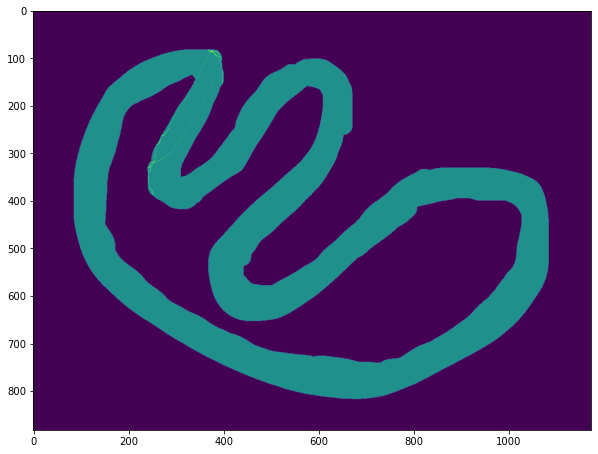

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 5.9600 - val_loss: 5.9482
Epoch 2/5
450/450 [==============================] - 5s 10ms/sample - loss: 5.6998 - val_loss: 5.3783
Epoch 3/5
450/450 [==============================] - 4s 10ms/sample - loss: 5.4969 - val_loss: 5.6668
Epoch 4/5
450/450 [==============================] - 4s 10ms/sample - loss: 5.3671 - val_loss: 5.7664
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 5.4320 - val_loss: 5.2080


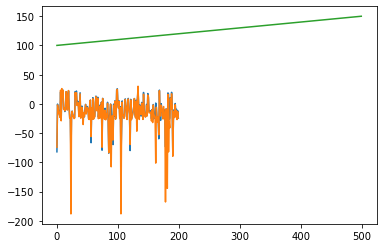

Unique speed values are: [ 0.          0.25        0.82073815  1.03077641  1.16421356  1.25
  1.28077641  1.32073815  1.41421356  1.41421356  1.41421356  1.53077641
  1.53077641  1.66421356  1.91421356  2.03077641  2.05409255  2.16421356
  2.25        2.28077641  2.28077641  2.32073815  2.33333333  2.41421356
  2.41421356  2.5         2.66421356  3.16421356  3.25        3.28077641
  3.28077641  3.32073815  3.41421356  3.41421356  3.66421356  4.16421356
  4.28077641  4.32073815  4.41421356  4.41421356  4.5         4.66421356
  4.75        5.05409255  5.16421356  5.16421356  5.25        5.28077641
  5.32073815  5.41421356  5.66421356  6.16421356  6.25        6.28077641
  6.32073815  6.41421356  6.66421356  6.75        7.16421356  7.16421356
  7.28077641  7.32073815  7.41421356  7.53077641  7.57073815  7.91421356
  8.          8.05409255  8.16421356  8.28077641  8.32073815  8.41421356
  8.53077641  8.57073815  9.16421356  9.28077641  9.41421356  9.53077641
  9.57073815 10.16421356 10.2807

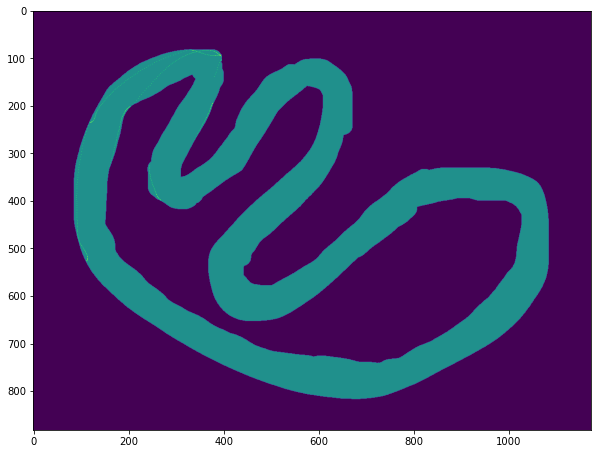

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.2537 - val_loss: 4.1763
Epoch 2/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.2403 - val_loss: 4.3440
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.0796 - val_loss: 4.0387
Epoch 4/5
450/450 [==============================] - 5s 12ms/sample - loss: 3.9707 - val_loss: 4.2240
Epoch 5/5
450/450 [==============================] - 5s 12ms/sample - loss: 3.8988 - val_loss: 4.7131


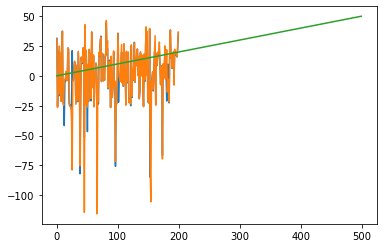

Unique speed values are: [ 0.          0.41421356  0.91421356  1.05409255  1.11803399  1.20185043
  1.25        1.41421356  1.41421356  1.41421356  1.66421356  1.91421356
  2.03077641  2.05409255  2.11803399  2.16421356  2.16421356  2.20185043
  2.25        2.28077641  2.41421356  2.41421356  2.41421356  2.66421356
  3.05409255  3.11803399  3.16421356  3.16421356  3.20185043  3.41421356
  3.41421356  3.41421356  3.66421356  3.80409255  3.86803399  3.91421356
  4.05409255  4.11803399  4.16421356  4.16421356  4.20185043  4.41421356
  4.45185043  4.5         4.66421356  4.80409255  4.91421356  4.91421356
  5.05409255  5.16421356  5.16421356  5.20185043  5.25        5.28077641
  5.32073815  5.41421356  5.41421356  5.45185043  5.66421356  5.80409255
  5.91421356  5.91421356  6.05409255  6.16421356  6.16421356  6.41421356
  6.45185043  6.66421356  6.66421356  6.80409255  6.91421356  6.91421356
  7.05409255  7.16421356  7.16421356  7.41421356  7.41421356  7.45185043
  7.53077641  7.66421356  

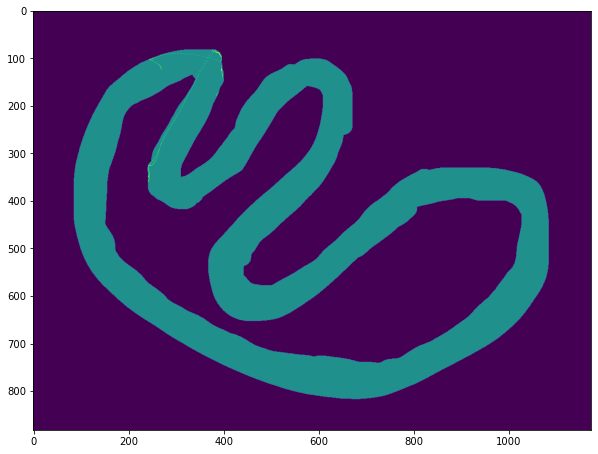

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 7.9116 - val_loss: 7.0901
Epoch 2/5
450/450 [==============================] - 5s 11ms/sample - loss: 7.7867 - val_loss: 7.7188
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 7.7070 - val_loss: 7.0904
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 7.4660 - val_loss: 6.7857
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 7.3613 - val_loss: 6.9046


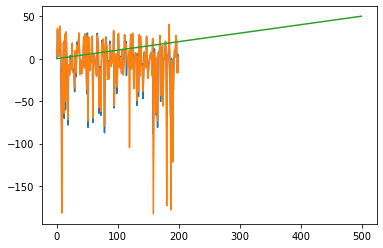

Unique speed values are: [ 0.          0.71200031  1.20185043  1.41421356  1.41421356  1.41421356
  1.71200031  1.91421356  2.20185043  2.28077641  2.41421356  2.41421356
  2.46200031  2.70185043  2.71200031  2.91421356  3.05409255  3.41421356
  3.41421356  3.46200031  3.66421356  3.91421356  4.41421356  4.41421356
  4.46200031  4.80409255  4.91421356  5.16421356  5.25        5.28077641
  5.41421356  5.41421356  5.46200031  5.91421356  5.91421356  6.05409255
  6.41421356  6.41421356  6.46200031  6.66421356  6.91421356  6.91421356
  7.05409255  7.16421356  7.41421356  7.41421356  7.46200031  7.80409255
  7.91421356  8.05409255  8.16421356  8.16421356  8.41421356  8.41421356
  8.46200031  8.91421356  9.16421356  9.16421356  9.41421356  9.41421356
  9.46200031  9.66421356  9.91421356 10.16421356 10.16421356 10.41421356
 10.41421356 10.46200031 10.66421356 10.66421356 10.91421356 10.91421356
 10.96200031 11.16421356 11.41421356 11.66421356 11.66421356 11.91421356
 11.96200031 12.16421356 1

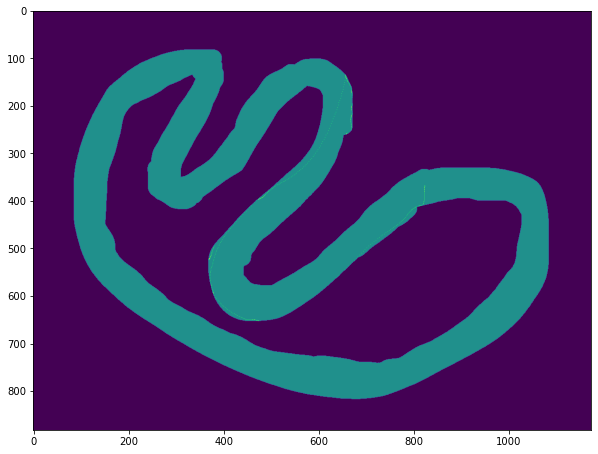

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 10ms/sample - loss: 6.7777 - val_loss: 6.8825
Epoch 2/5
450/450 [==============================] - 5s 10ms/sample - loss: 6.3423 - val_loss: 8.1992
Epoch 3/5
450/450 [==============================] - 4s 10ms/sample - loss: 6.2644 - val_loss: 8.5202
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 6.2853 - val_loss: 8.4259
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 6.2626 - val_loss: 8.9140


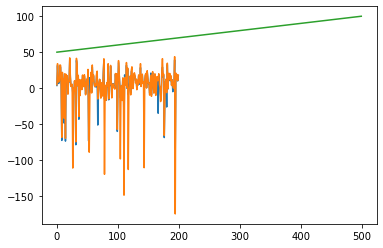

Unique speed values are: [ 0.          1.00346621  1.41421356  1.41421356  1.71200031  2.00346621
  2.41421356  2.41421356  2.50346621  2.71200031  3.16421356  3.41421356
  3.41421356  3.50346621  3.91421356  4.16421356  4.41421356  4.41421356
  4.50346621  4.66421356  4.91421356  4.91421356  5.16421356  5.25
  5.28077641  5.41421356  5.50346621  5.66421356  5.91421356  6.00346621
  6.41421356  6.41421356  6.66421356  6.91421356  6.91421356  7.00346621
  7.41421356  7.66421356  7.91421356  8.00346621  8.16421356  8.41421356
  8.41421356  8.66421356  8.91421356  9.00346621  9.16421356  9.41421356
  9.41421356  9.66421356  9.91421356 10.00346621 10.16421356 10.41421356
 10.41421356 10.66421356 10.91421356 11.00346621 11.16421356 11.41421356
 11.66421356 11.91421356 12.00346621 12.41421356 12.66421356 12.91421356
 13.00346621 13.16421356 13.16421356 13.66421356 13.91421356 14.00346621
 14.16421356 14.41421356 14.66421356 14.66421356 14.91421356 14.91421356
 15.00346621 15.16421356 15.4142

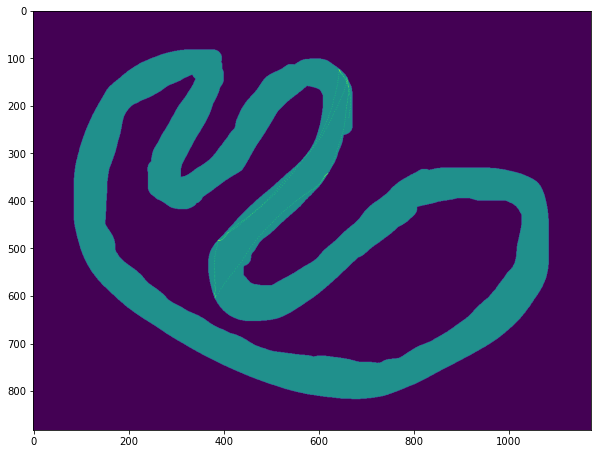

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.4576 - val_loss: 3.9613
Epoch 2/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.8836 - val_loss: 3.8514
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.9454 - val_loss: 4.0510
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.7952 - val_loss: 3.9841
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.5776 - val_loss: 4.5293


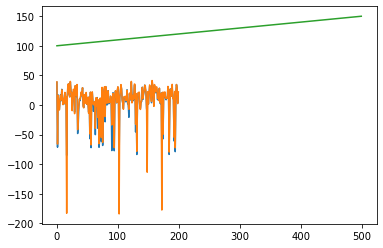

Unique speed values are: [ 0.          0.82073815  0.83333333  1.05409255  1.07073815  1.11803399
  1.41421356  1.41421356  1.71200031  1.82073815  1.83333333  1.83333333
  2.00346621  2.05409255  2.07073815  2.11803399  2.41421356  2.66421356
  2.83333333  3.05409255  3.07073815  3.11803399  3.41421356  3.66421356
  3.83333333  3.91421356  4.05409255  4.07073815  4.11803399  4.16421356
  4.41421356  4.83333333  4.91421356  5.05409255  5.07073815  5.11803399
  5.16421356  5.28077641  5.41421356  5.83333333  5.91421356  6.05409255
  6.07073815  6.11803399  6.16421356  6.41421356  6.55409255  6.66421356
  6.66421356  6.83333333  6.91421356  7.00346621  7.07073815  7.16421356
  7.41421356  7.41421356  7.55409255  7.66421356  7.83333333  8.07073815
  8.16421356  8.41421356  8.41421356  8.55409255  8.66421356  8.83333333
  9.07073815  9.16421356  9.33333333  9.41421356  9.41421356  9.55409255
  9.58333333  9.66421356  9.82073815  9.83333333 10.08333333 10.16421356
 10.33333333 10.41421356 1

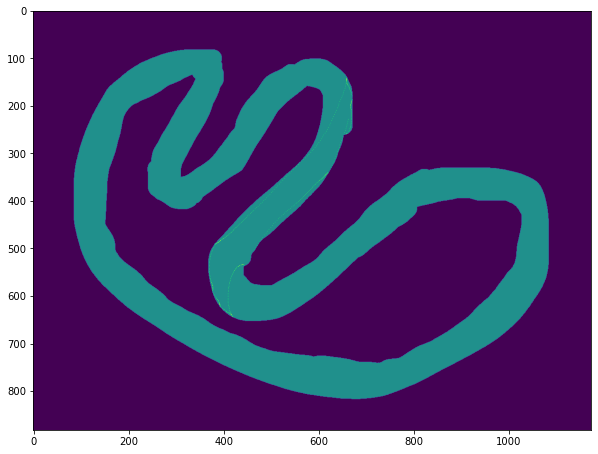

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.8122 - val_loss: 1.4040
Epoch 2/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.7842 - val_loss: 1.4426
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.6958 - val_loss: 1.3543
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.4168 - val_loss: 1.4352
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.1873 - val_loss: 1.2622


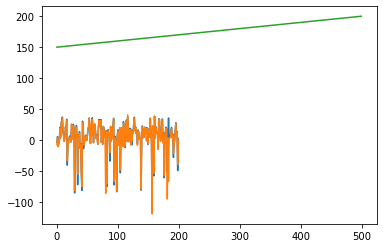

Unique speed values are: [ 0.          0.5         0.5         1.00346621  1.07073815  1.16421356
  1.20185043  1.41421356  1.41421356  1.41421356  1.45185043  1.5
  1.5         2.00346621  2.16421356  2.16421356  2.41421356  2.41421356
  2.45185043  2.5         2.91421356  3.00346621  3.16421356  3.16421356
  3.41421356  3.41421356  3.45185043  3.5         3.91421356  4.
  4.00346621  4.05409255  4.16421356  4.25        4.41421356  4.41421356
  4.45185043  4.91421356  5.          5.00346621  5.05409255  5.16421356
  5.25        5.41421356  5.41421356  5.45185043  5.66421356  5.91421356
  6.00346621  6.05409255  6.11803399  6.16421356  6.25        6.41421356
  6.41421356  6.45185043  6.83333333  6.91421356  7.00346621  7.16421356
  7.25        7.41421356  7.41421356  7.45185043  7.70185043  7.75346621
  7.91421356  8.00346621  8.16421356  8.25        8.41421356  8.45185043
  8.66421356  8.70185043  8.75346621  8.91421356  9.16421356  9.25
  9.41421356  9.55409255  9.58333333  9.6642135

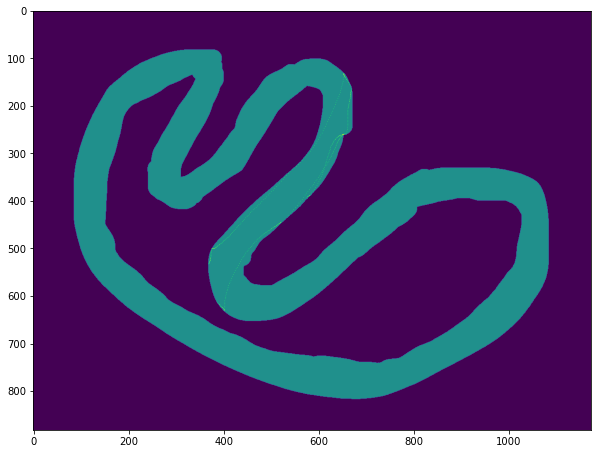

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 10ms/sample - loss: 4.2469 - val_loss: 1.9391
Epoch 2/5
450/450 [==============================] - 5s 10ms/sample - loss: 4.1134 - val_loss: 1.1554
Epoch 3/5
450/450 [==============================] - 5s 10ms/sample - loss: 3.8548 - val_loss: 2.0371
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.7120 - val_loss: 2.0289
Epoch 5/5
450/450 [==============================] - 5s 10ms/sample - loss: 3.8324 - val_loss: 1.4076


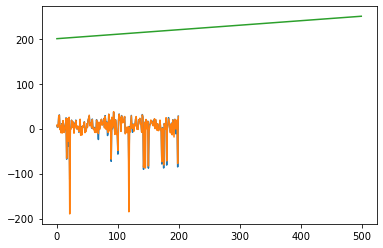

Unique speed values are: [ 0.          1.00346621  1.11803399  1.41421356  1.41421356  1.45185043
  1.75346621  2.11803399  2.16421356  2.41421356  2.41421356  2.91421356
  3.11803399  3.41421356  3.41421356  3.66421356  3.91421356  4.11803399
  4.36803399  4.41421356  4.41421356  4.66421356  4.91421356  5.11803399
  5.25        5.36803399  5.41421356  5.41421356  5.66421356  5.66421356
  5.86803399  5.91421356  6.11803399  6.25        6.36803399  6.41421356
  6.41421356  6.45185043  6.66421356  6.86803399  6.91421356  7.25
  7.36803399  7.41421356  7.41421356  7.41421356  7.61803399  7.66421356
  7.86803399  7.91421356  8.16421356  8.36803399  8.41421356  8.45185043
  8.61803399  8.66421356  8.66421356  8.91421356  9.36803399  9.41421356
  9.61803399  9.66421356  9.66421356  9.91421356 10.11803399 10.36803399
 10.61803399 10.66421356 10.66421356 10.86803399 10.91421356 11.41421356
 11.61803399 11.66421356 11.66421356 11.86803399 11.91421356 12.41421356
 12.61803399 12.66421356 12.6642

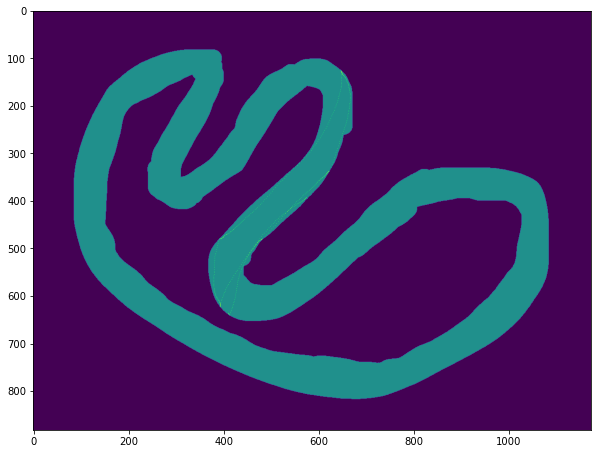

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.8319 - val_loss: 1.3325
Epoch 2/5
450/450 [==============================] - 5s 10ms/sample - loss: 2.6486 - val_loss: 1.8862
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.4820 - val_loss: 2.2476
Epoch 4/5
450/450 [==============================] - 5s 10ms/sample - loss: 2.5015 - val_loss: 1.9343
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.6220 - val_loss: 2.8216


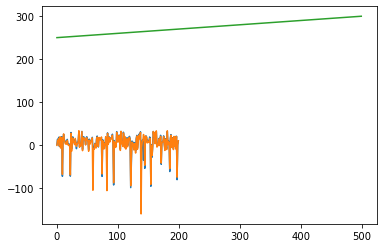

Unique speed values are: [ 0.          1.          1.11803399  1.41421356  2.          2.16421356
  2.41421356  3.          3.16421356  3.41421356  3.75        3.91421356
  4.11803399  4.16421356  4.36803399  4.41421356  4.66421356  4.75
  4.91421356  5.16421356  5.41421356  5.41421356  5.66421356  5.75
  5.86803399  6.16421356  6.41421356  6.45185043  6.66421356  6.75
  7.16421356  7.36803399  7.41421356  7.66421356  7.75        8.
  8.16421356  8.41421356  8.66421356  8.75        8.91421356  9.
  9.16421356  9.41421356  9.61803399  9.66421356  9.91421356 10.
 10.16421356 10.41421356 10.61803399 10.66421356 10.91421356 11.
 11.41421356 11.5        11.66421356 11.91421356 12.         12.5
 12.66421356 12.66421356 12.91421356 13.41421356 13.5        13.66421356
 13.91421356 14.5        14.66421356 14.75       14.91421356 15.16421356
 15.25       15.5        15.66421356 15.75       15.91421356 16.16421356
 16.5        16.66421356 16.91421356 17.16421356 17.5        17.66421356
 17.914213

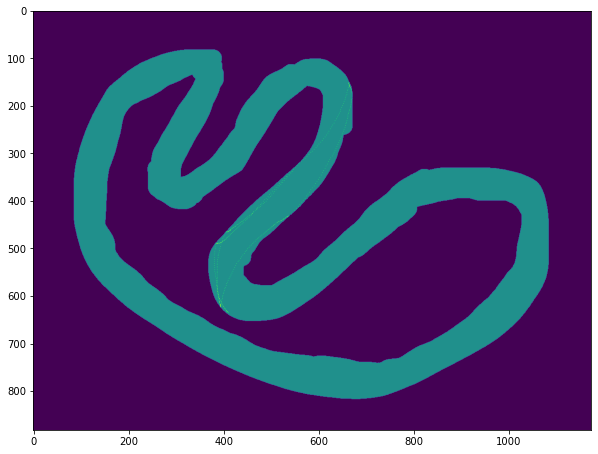

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.2931 - val_loss: 8.1357
Epoch 2/5
450/450 [==============================] - 6s 12ms/sample - loss: 2.1853 - val_loss: 8.0023
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.1163 - val_loss: 8.3501
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.1323 - val_loss: 7.7546
Epoch 5/5
450/450 [==============================] - 4s 10ms/sample - loss: 2.0482 - val_loss: 8.1132


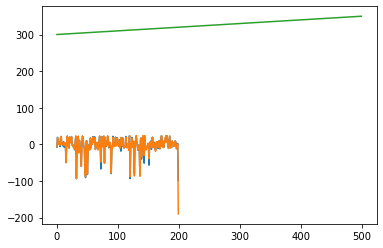

Unique speed values are: [ 0.          0.60092521  1.          1.05409255  1.11803399  1.25
  1.41421356  1.41421356  1.60092521  1.66421356  1.91421356  2.
  2.05409255  2.11803399  2.25        2.41421356  2.60092521  2.91421356
  3.          3.05409255  3.11803399  3.16421356  3.25        3.41421356
  3.60092521  3.66421356  3.80409255  3.91421356  4.          4.10092521
  4.11803399  4.25        4.41421356  4.60092521  4.66421356  4.91421356
  5.          5.10092521  5.11803399  5.16421356  5.25        5.75
  5.91421356  6.          6.10092521  6.11803399  6.25        6.66421356
  6.75        6.91421356  7.          7.10092521  7.11803399  7.60092521
  7.75        7.91421356  8.          8.10092521  8.11803399  8.75
  8.91421356  9.          9.10092521  9.11803399  9.75        9.86803399
  9.91421356 10.         10.10092521 10.61803399 10.75       10.86803399
 10.91421356 11.         11.10092521 11.5        11.66421356 11.75
 11.86803399 11.91421356 12.         12.10092521 12.664213

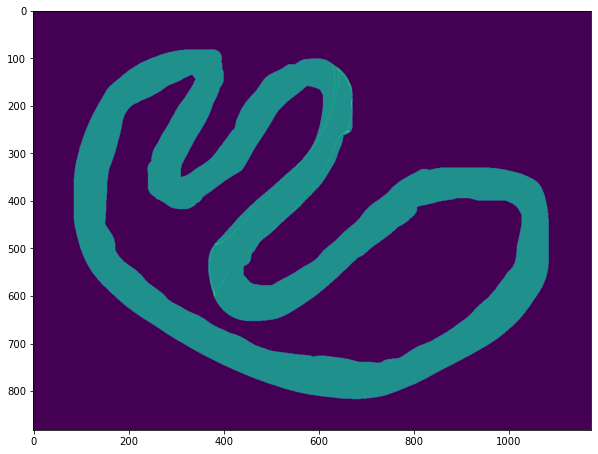

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.8724 - val_loss: 1.9708
Epoch 2/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.4828 - val_loss: 1.8666
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.2133 - val_loss: 1.6874
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.3324 - val_loss: 1.9587
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.2063 - val_loss: 2.0781


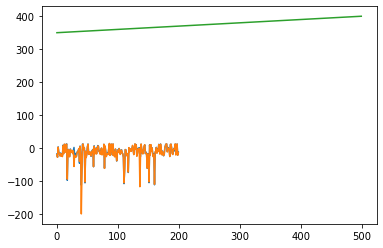

Unique speed values are: [ 0.          0.66421356  1.          1.05409255  1.11803399  1.16421356
  1.20185043  1.25        1.41421356  1.41421356  1.45185043  1.66421356
  2.05409255  2.16421356  2.25        2.41421356  2.41421356  2.45185043
  2.66421356  3.          3.05409255  3.16421356  3.25        3.41421356
  3.45185043  3.66421356  3.70185043  4.16421356  4.41421356  4.66421356
  4.70185043  5.10092521  5.11803399  5.16421356  5.16421356  5.41421356
  5.41421356  5.66421356  5.70185043  6.16421356  6.41421356  6.41421356
  6.45185043  6.66421356  7.41421356  7.41421356  7.45185043  7.66421356
  7.66421356  7.75        8.11803399  8.41421356  8.45185043  8.66421356
  9.          9.11803399  9.16421356  9.41421356  9.45185043  9.60092521
  9.66421356  9.85092521 10.10092521 10.16421356 10.41421356 10.45185043
 10.60092521 10.66421356 10.85092521 10.86803399 11.10092521 11.10092521
 11.16421356 11.35092521 11.41421356 11.45185043 11.60092521 11.66421356
 11.75       12.         1

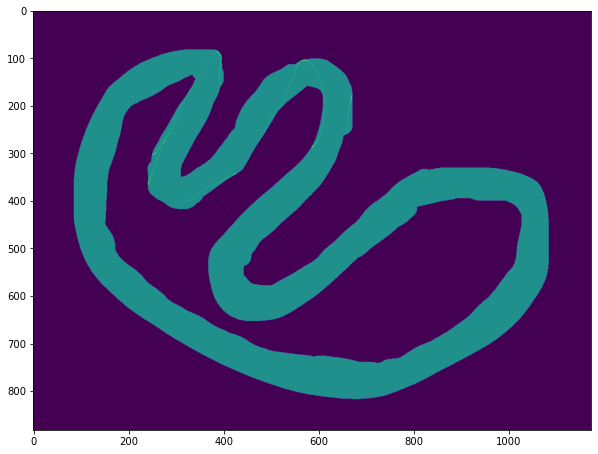

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.8873 - val_loss: 5.1963
Epoch 2/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.1699 - val_loss: 5.0078
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.0981 - val_loss: 5.1952
Epoch 4/5
450/450 [==============================] - 5s 10ms/sample - loss: 4.0907 - val_loss: 5.3195
Epoch 5/5
450/450 [==============================] - 5s 10ms/sample - loss: 4.0711 - val_loss: 5.0749


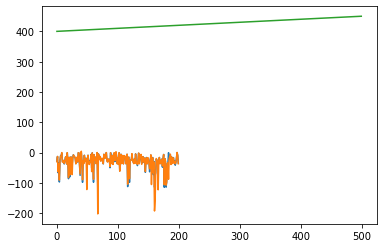

Unique speed values are: [ 0.          0.66421356  1.11803399  1.20185043  1.25        1.41421356
  1.41421356  1.45185043  1.66421356  2.11803399  2.25        2.41421356
  2.91421356  3.          3.11803399  3.25        3.41421356  3.41421356
  3.91421356  4.11803399  4.16421356  4.16421356  4.25        4.36803399
  4.41421356  4.66421356  4.91421356  5.11803399  5.16421356  5.25
  5.36803399  5.41421356  5.41421356  5.5         5.91421356  6.
  6.16421356  6.36803399  6.41421356  6.5         6.91421356  7.16421356
  7.36803399  7.41421356  7.5         7.91421356  8.16421356  8.36803399
  8.41421356  8.5         8.66421356  8.66421356  8.91421356  9.16421356
  9.36803399  9.41421356  9.41421356  9.5         9.66421356  9.66421356
  9.75        9.85092521  9.91421356  9.91421356 10.36803399 10.41421356
 10.66421356 10.66421356 10.66421356 10.75       10.91421356 10.91421356
 11.35092521 11.36803399 11.41421356 11.60092521 11.66421356 11.66421356
 11.66421356 11.75       11.91421356 11.

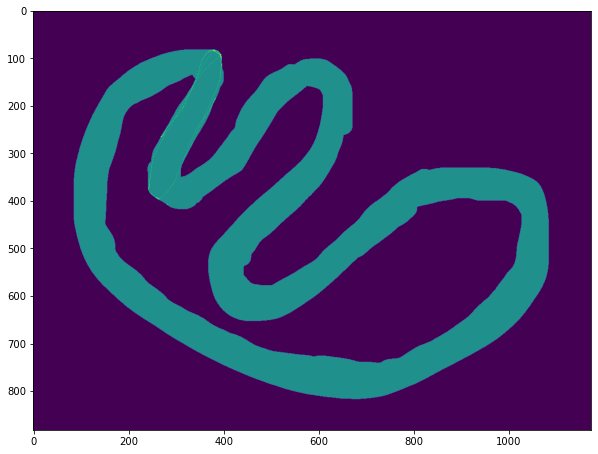

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 12ms/sample - loss: 5.8884 - val_loss: 2.2705
Epoch 2/5
450/450 [==============================] - 5s 11ms/sample - loss: 5.2320 - val_loss: 2.5361
Epoch 3/5
450/450 [==============================] - 6s 12ms/sample - loss: 4.9322 - val_loss: 2.8848
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.8723 - val_loss: 3.1429
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.8648 - val_loss: 3.5802


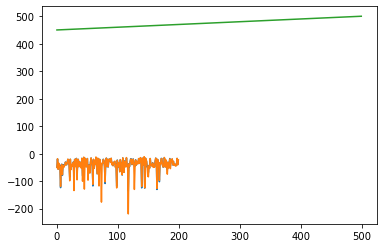

Unique speed values are: [ 0.          0.08333333  0.33333333  0.60092521  0.66666667  0.71200031
  1.00346621  1.03077641  1.05409255  1.08333333  1.20185043  1.20185043
  1.33333333  1.35092521  1.41421356  1.41421356  1.41421356  1.58333333
  1.71200031  2.00346621  2.03077641  2.03077641  2.05409255  2.08333333
  2.11803399  2.16421356  2.20185043  2.33333333  2.35092521  2.41421356
  2.41421356  2.41421356  2.58333333  2.71200031  3.00346621  3.03077641
  3.03077641  3.05409255  3.16421356  3.25346621  3.33333333  3.35092521
  3.41421356  3.41421356  3.58333333  3.71200031  3.91421356  4.00346621
  4.03077641  4.10092521  4.16421356  4.16421356  4.33333333  4.35092521
  4.41421356  4.41421356  4.58333333  4.71200031  5.00346621  5.03077641
  5.10092521  5.16421356  5.25        5.33333333  5.35092521  5.41421356
  5.41421356  5.66421356  6.00346621  6.03077641  6.10092521  6.16421356
  6.33333333  6.35092521  6.41421356  6.41421356  7.00346621  7.03077641
  7.10092521  7.16421356  

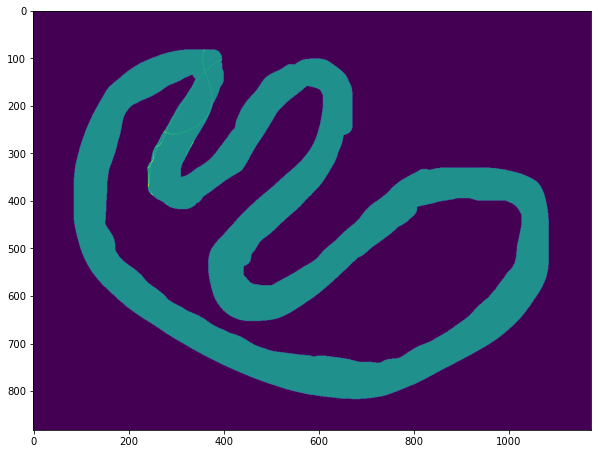

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 8.2918 - val_loss: 4.0361
Epoch 2/5
450/450 [==============================] - 5s 11ms/sample - loss: 7.4402 - val_loss: 3.7353
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 7.3603 - val_loss: 3.9759
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 7.3966 - val_loss: 4.0580
Epoch 5/5
450/450 [==============================] - 4s 10ms/sample - loss: 7.2962 - val_loss: 4.0514
Zero Movement recorded. Speed is:  0.0  sampling_frequency is:  10.0


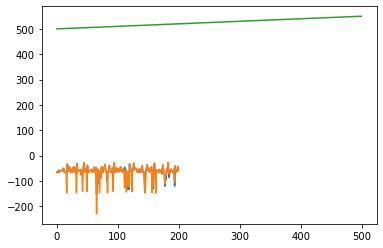

Unique speed values are: [0.00000000e+00 3.46621490e-03 5.00000000e-01 7.12000312e-01
 1.00346621e+00 1.16421356e+00 1.41421356e+00 1.41421356e+00
 1.41421356e+00 1.50000000e+00 2.00346621e+00 2.03077641e+00
 2.16421356e+00 2.41421356e+00 2.41421356e+00 2.50000000e+00
 2.58333333e+00 2.71200031e+00 2.91421356e+00 3.00346621e+00
 3.03077641e+00 3.16421356e+00 3.25346621e+00 3.41421356e+00
 3.41421356e+00 3.50000000e+00 3.91421356e+00 3.91421356e+00
 4.03077641e+00 4.16421356e+00 4.25346621e+00 4.33333333e+00
 4.41421356e+00 4.50000000e+00 4.91421356e+00 4.91421356e+00
 5.16421356e+00 5.25346621e+00 5.41421356e+00 5.50000000e+00
 5.75346621e+00 5.91421356e+00 5.91421356e+00 6.10092521e+00
 6.16421356e+00 6.41421356e+00 6.50000000e+00 6.75346621e+00
 6.91421356e+00 6.91421356e+00 7.16421356e+00 7.41421356e+00
 7.50000000e+00 7.75346621e+00 7.91421356e+00 7.91421356e+00
 8.03077641e+00 8.16421356e+00 8.41421356e+00 8.50000000e+00
 8.75346621e+00 8.91421356e+00 9.03077641e+00 9.16421356e+00

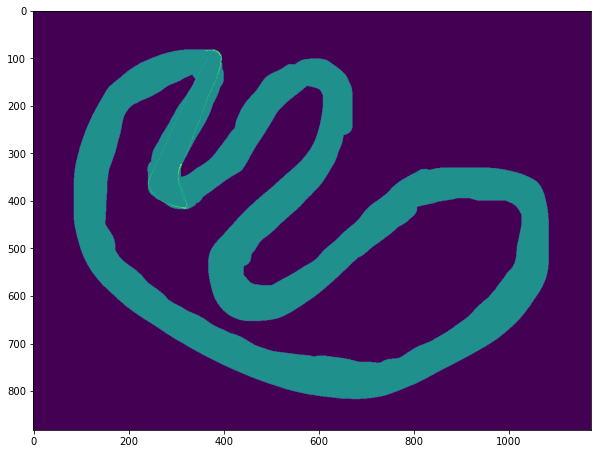

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 5.1812 - val_loss: 2.2693
Epoch 2/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.0128 - val_loss: 2.5218
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.9137 - val_loss: 2.5563
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.7278 - val_loss: 2.2395
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.7104 - val_loss: 3.1465


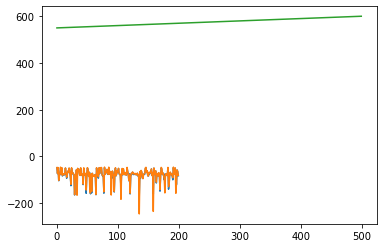

Unique speed values are: [ 0.          0.20185043  0.25        0.5         0.54814957  1.
  1.00346621  1.16421356  1.20185043  1.20185043  1.25        1.25
  1.41421356  1.41421356  1.41421356  1.54814957  1.66421356  1.91421356
  2.16421356  2.20185043  2.25        2.29814957  2.41421356  2.5
  2.54814957  2.66421356  3.16421356  3.20185043  3.25        3.29814957
  3.41421356  3.5         3.66421356  3.91421356  4.16421356  4.20185043
  4.25        4.25346621  4.29814957  4.41421356  4.5         4.66421356
  4.91421356  5.16421356  5.20185043  5.25        5.29814957  5.41421356
  5.5         6.16421356  6.20185043  6.25        6.41421356  6.5
  6.70185043  6.75        7.16421356  7.20185043  7.25        7.41421356
  7.5         7.66421356  7.70185043  7.75        7.75346621  8.16421356
  8.16421356  8.20185043  8.25        8.41421356  8.5         8.66421356
  8.70185043  8.75        8.75346621  9.16421356  9.16421356  9.20185043
  9.41421356  9.41421356  9.5         9.66421356  9.70

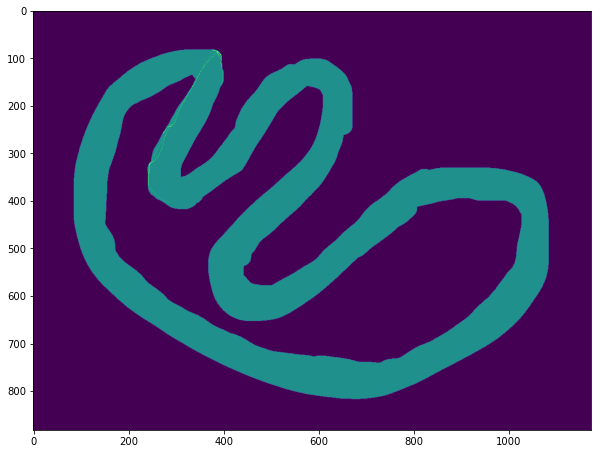

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 8.5707 - val_loss: 6.0180
Epoch 2/5
450/450 [==============================] - 5s 11ms/sample - loss: 7.3247 - val_loss: 5.5827
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 7.1522 - val_loss: 5.7250
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 6.9329 - val_loss: 6.5230
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 6.8482 - val_loss: 6.4485


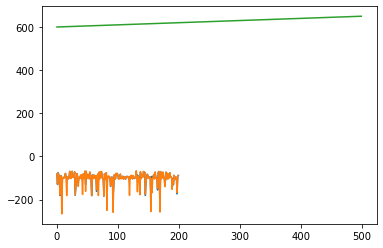

Unique speed values are: [ 0.          0.5         0.82073815  1.          1.05409255  1.07073815
  1.16421356  1.20185043  1.25        1.41421356  1.41421356  1.70185043
  2.          2.05409255  2.05409255  2.07073815  2.20185043  2.41421356
  2.70185043  3.          3.05409255  3.07073815  3.16421356  3.32073815
  3.41421356  3.66421356  3.70185043  3.91421356  4.          4.05409255
  4.25346621  4.32073815  4.41421356  4.5         4.70185043  4.91421356
  5.          5.05409255  5.25        5.32073815  5.41421356  5.70185043
  5.75        5.91421356  6.05409255  6.16421356  6.25        6.32073815
  6.41421356  6.70185043  6.75        7.05409255  7.16421356  7.32073815
  7.41421356  7.5         7.70185043  7.75        7.82073815  8.05409255
  8.16421356  8.32073815  8.41421356  8.5         8.70185043  8.82073815
  9.05409255  9.16421356  9.25        9.41421356  9.41421356  9.45185043
  9.5         9.66421356  9.70185043  9.82073815  9.95185043 10.05409255
 10.16421356 10.25       1

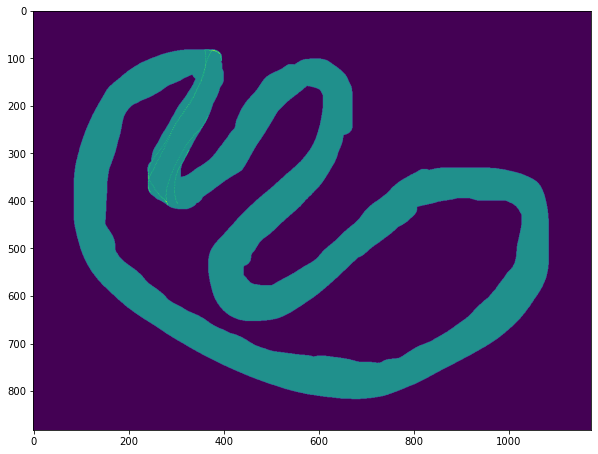

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.8051 - val_loss: 5.9826
Epoch 2/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.6347 - val_loss: 5.8459
Epoch 3/5
450/450 [==============================] - 5s 10ms/sample - loss: 3.4869 - val_loss: 6.3261
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.2917 - val_loss: 6.8183
Epoch 5/5
450/450 [==============================] - 5s 12ms/sample - loss: 3.4035 - val_loss: 5.6986


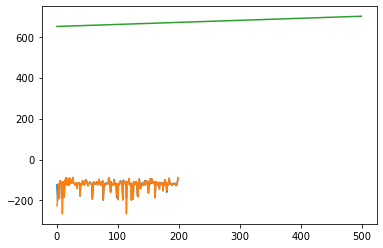

Unique speed values are: [ 0.          0.55409255  0.80409255  0.82073815  1.          1.03077641
  1.05409255  1.20185043  1.25        1.28077641  1.41421356  1.41421356
  1.55409255  1.55409255  1.82073815  2.          2.05409255  2.28077641
  2.41421356  2.41421356  2.55409255  2.55409255  2.82073815  3.
  3.07073815  3.28077641  3.32073815  3.41421356  3.41421356  3.55409255
  3.82073815  4.          4.05409255  4.25346621  4.28077641  4.41421356
  4.41421356  4.55409255  4.82073815  4.91421356  5.          5.16421356
  5.28077641  5.32073815  5.41421356  5.41421356  5.55409255  5.70185043
  5.82073815  6.          6.16421356  6.28077641  6.41421356  6.41421356
  6.55409255  6.75        6.82073815  7.          7.16421356  7.28077641
  7.41421356  7.41421356  7.55409255  7.82073815  8.          8.05409255
  8.16421356  8.28077641  8.41421356  8.5         8.55409255  8.82073815
  9.          9.05409255  9.16421356  9.25        9.28077641  9.41421356
  9.55409255  9.82073815 10.      

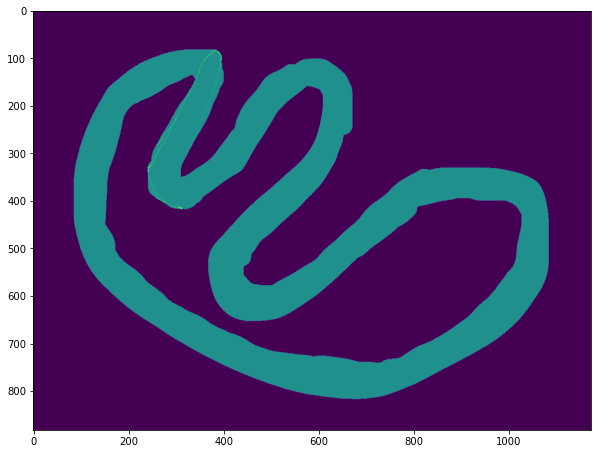

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 5.2620 - val_loss: 3.7269
Epoch 2/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.1689 - val_loss: 3.7939
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.0263 - val_loss: 3.4675
Epoch 4/5
450/450 [==============================] - 5s 12ms/sample - loss: 3.9234 - val_loss: 3.7358
Epoch 5/5
450/450 [==============================] - 5s 12ms/sample - loss: 4.1294 - val_loss: 3.6317


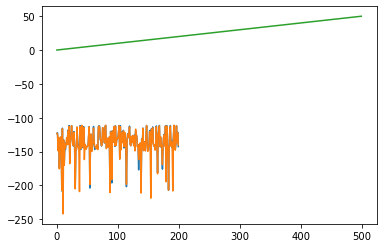

Unique speed values are: [0.00000000e+00 3.46621490e-03 2.46533785e-01 1.00000000e+00
 1.00346621e+00 1.03077641e+00 1.24653379e+00 1.28077641e+00
 1.41421356e+00 1.41421356e+00 1.41421356e+00 1.49653379e+00
 2.00000000e+00 2.00346621e+00 2.03077641e+00 2.28077641e+00
 2.41421356e+00 2.49653379e+00 3.00000000e+00 3.00346621e+00
 3.41421356e+00 3.49653379e+00 3.82073815e+00 4.00000000e+00
 4.00346621e+00 4.41421356e+00 4.49653379e+00 4.55409255e+00
 4.91421356e+00 5.00000000e+00 5.00346621e+00 5.41421356e+00
 5.49653379e+00 6.00000000e+00 6.00346621e+00 6.16421356e+00
 6.28077641e+00 6.41421356e+00 6.41421356e+00 6.49653379e+00
 7.00000000e+00 7.00346621e+00 7.28077641e+00 7.41421356e+00
 7.49653379e+00 7.74653379e+00 8.00000000e+00 8.00346621e+00
 8.05409255e+00 8.28077641e+00 8.41421356e+00 8.55409255e+00
 8.74653379e+00 9.00000000e+00 9.00346621e+00 9.25000000e+00
 9.41421356e+00 9.55409255e+00 9.74653379e+00 1.00000000e+01
 1.00034662e+01 1.04142136e+01 1.07465338e+01 1.08207382e+01

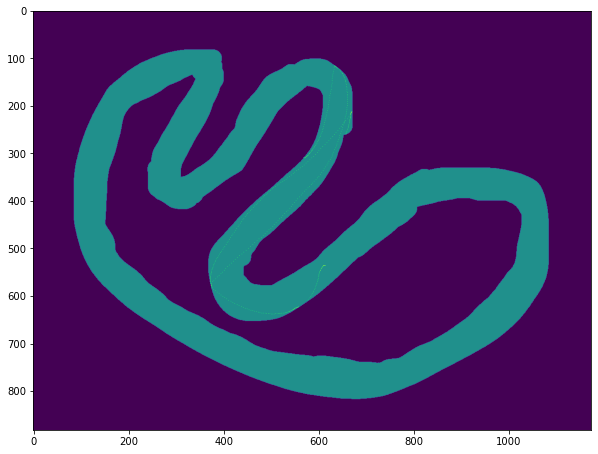

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 7.3695 - val_loss: 7.9853
Epoch 2/5
450/450 [==============================] - 5s 11ms/sample - loss: 6.9471 - val_loss: 7.7793
Epoch 3/5
450/450 [==============================] - 4s 10ms/sample - loss: 6.8497 - val_loss: 7.7442
Epoch 4/5
450/450 [==============================] - 5s 10ms/sample - loss: 6.7517 - val_loss: 7.8553
Epoch 5/5
450/450 [==============================] - 4s 10ms/sample - loss: 6.6593 - val_loss: 7.3419


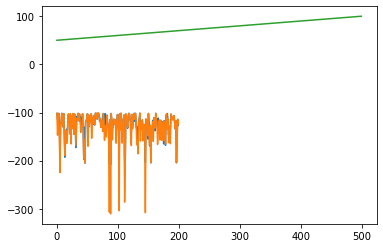

Unique speed values are: [ 0.          1.          1.24653379  1.41421356  1.91421356  2.
  2.03077641  2.41421356  2.91421356  3.          3.41421356  3.91421356
  4.          4.41421356  4.66421356  4.91421356  5.          5.66421356
  5.91421356  6.          6.66421356  6.91421356  7.          7.66421356
  7.91421356  8.          8.28077641  8.66421356  8.91421356  9.
  9.25        9.55409255  9.66421356  9.91421356 10.         10.25
 10.66421356 10.91421356 11.25       11.66421356 11.91421356 12.16421356
 12.25       12.41421356 12.66421356 12.91421356 13.16421356 13.25
 13.41421356 13.91421356 14.16421356 14.25       14.30409255 14.66421356
 14.74653379 14.82073815 14.91421356 15.16421356 15.25       15.32073815
 15.66421356 15.91421356 16.16421356 16.25       16.41421356 16.49653379
 16.91421356 17.16421356 17.25       17.28077641 17.91421356 18.
 18.16421356 18.25       18.49653379 18.91421356 19.16421356 19.25
 19.41421356 19.91421356 20.16421356 20.25       20.91421356 21.0034

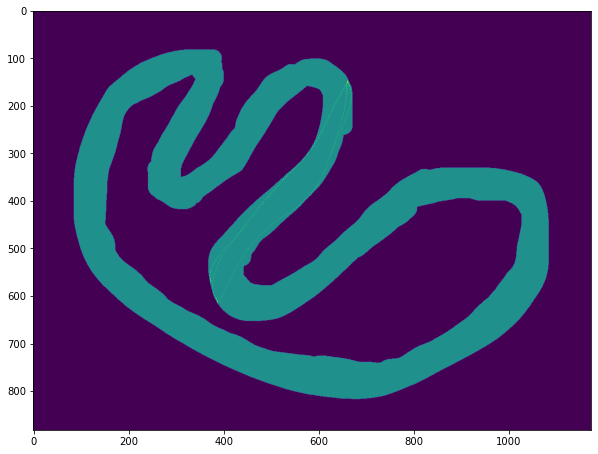

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.4193 - val_loss: 4.8512
Epoch 2/5
450/450 [==============================] - 5s 12ms/sample - loss: 3.1786 - val_loss: 4.0661
Epoch 3/5
450/450 [==============================] - 5s 12ms/sample - loss: 3.1469 - val_loss: 3.7914
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.0246 - val_loss: 3.8383
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.0202 - val_loss: 3.8999


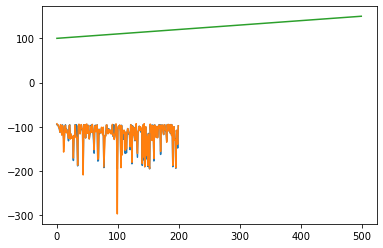

Unique speed values are: [ 0.          1.          1.41421356  1.41421356  1.75        2.
  2.41421356  2.75        3.          3.41421356  3.75        4.
  4.41421356  4.91421356  5.          5.41421356  5.66421356  6.
  6.16421356  6.41421356  6.66421356  6.75        6.91421356  7.
  7.41421356  7.75        7.91421356  8.41421356  8.75        9.41421356
  9.75       10.41421356 10.75       11.25       11.41421356 11.66421356
 11.75       11.91421356 12.41421356 12.66421356 12.75       13.41421356
 13.75       14.16421356 14.41421356 14.75       15.16421356 15.32073815
 15.41421356 15.75       16.41421356 16.75       17.41421356 17.75
 18.25       18.41421356 18.75       19.16421356 19.41421356 19.75
 20.41421356 20.75       20.91421356 21.41421356 21.75       21.91421356
 22.41421356 22.75       22.91421356 23.41421356 23.75       23.91421356
 24.16421356 24.16421356 24.25       24.41421356 24.75       24.91421356
 25.16421356 25.41421356 25.75       25.91421356 26.16421356 26.75
 26

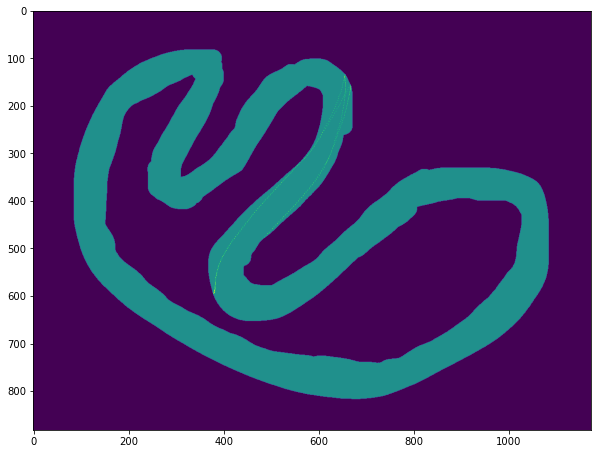

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.5245 - val_loss: 2.6092
Epoch 2/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.3559 - val_loss: 2.7146
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.2631 - val_loss: 2.6501
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.2079 - val_loss: 2.7960
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.1943 - val_loss: 2.7093


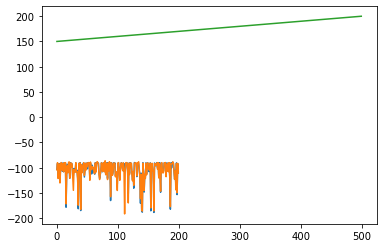

Unique speed values are: [ 0.          0.20185043  0.20185043  0.29814957  0.95185043  1.
  1.          1.05409255  1.05409255  1.20185043  1.29814957  1.41421356
  1.41421356  1.41421356  1.5         1.95185043  2.          2.05409255
  2.05409255  2.20185043  2.29814957  2.41421356  2.41421356  2.5
  2.91421356  2.95185043  3.          3.05409255  3.29814957  3.41421356
  3.5         3.75        3.91421356  3.91421356  3.95185043  4.
  4.05409255  4.41421356  4.5         4.91421356  4.91421356  5.
  5.05409255  5.41421356  5.5         5.91421356  5.91421356  6.
  6.05409255  6.16421356  6.41421356  6.5         6.66421356  6.75
  6.80409255  6.91421356  6.91421356  7.          7.05409255  7.41421356
  7.5         7.80409255  7.91421356  7.91421356  8.          8.16421356
  8.41421356  8.41421356  8.5         8.66421356  8.75        8.80409255
  8.91421356  8.91421356  9.          9.16421356  9.41421356  9.41421356
  9.5         9.66421356  9.91421356 10.         10.16421356 10.4142135

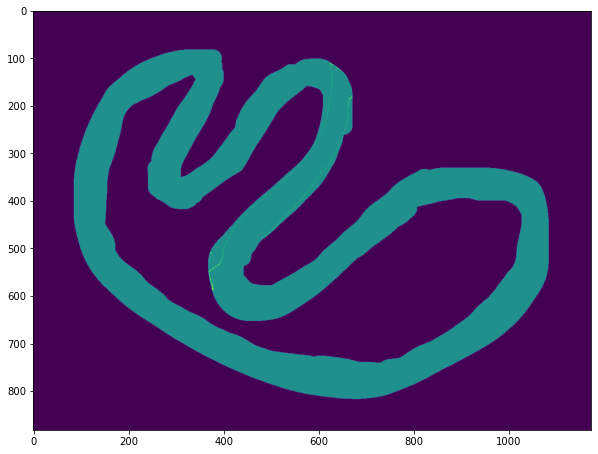

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 5.0187 - val_loss: 5.4260
Epoch 2/5
450/450 [==============================] - 5s 10ms/sample - loss: 4.8135 - val_loss: 5.9412
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.7067 - val_loss: 5.5185
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.6737 - val_loss: 5.2258
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.6149 - val_loss: 5.5770


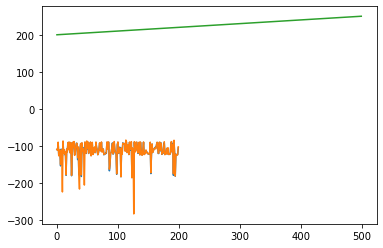

Unique speed values are: [ 0.          0.20185043  0.41421356  0.66421356  0.66421356  1.
  1.05409255  1.20185043  1.25        1.41421356  1.41421356  1.66421356
  1.66421356  2.16421356  2.66421356  2.95185043  3.16421356  3.41421356
  3.66421356  4.16421356  4.41421356  4.66421356  4.91421356  5.
  5.16421356  5.41421356  5.66421356  5.91421356  5.91421356  6.
  6.16421356  6.66421356  6.80409255  6.91421356  7.16421356  7.66421356
  8.16421356  8.41421356  8.41421356  8.66421356  8.66421356  8.91421356
  8.91421356  9.          9.16421356  9.66421356  9.66421356 10.
 10.16421356 10.66421356 10.66421356 11.16421356 11.41421356 11.66421356
 11.66421356 12.16421356 12.41421356 12.41421356 12.66421356 12.66421356
 13.41421356 13.66421356 13.66421356 14.16421356 14.41421356 14.66421356
 14.91421356 15.16421356 15.41421356 15.66421356 16.16421356 16.41421356
 16.66421356 17.         17.16421356 17.41421356 17.66421356 18.16421356
 18.41421356 18.66421356 19.16421356 19.41421356 19.664213

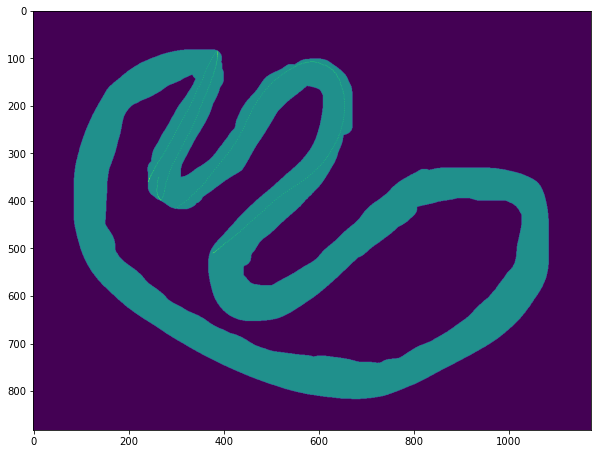

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.5135 - val_loss: 3.8660
Epoch 2/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.2896 - val_loss: 3.7110
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.1973 - val_loss: 3.5951
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.2257 - val_loss: 3.3663
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.1190 - val_loss: 3.4140


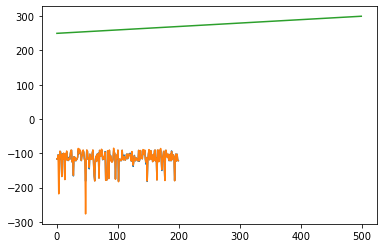

Unique speed values are: [ 0.          0.28799969  0.71200031  0.71200031  0.75        1.05409255
  1.05409255  1.05409255  1.05409255  1.20185043  1.28799969  1.41421356
  1.41421356  1.55409255  1.71200031  1.75        2.05409255  2.20185043
  2.28799969  2.41421356  2.55409255  2.71200031  2.75        3.20185043
  3.28799969  3.41421356  3.55409255  3.71200031  3.75        3.91421356
  4.16421356  4.20185043  4.41421356  4.55409255  4.75        5.16421356
  5.16421356  5.20185043  5.41421356  5.55409255  5.66421356  5.75
  5.95185043  6.16421356  6.16421356  6.20185043  6.41421356  6.55409255
  6.66421356  6.75        6.80409255  6.91421356  6.95185043  7.20185043
  7.41421356  7.41421356  7.55409255  7.66421356  7.75        7.91421356
  7.95185043  8.16421356  8.20185043  8.41421356  8.41421356  8.41421356
  8.55409255  8.66421356  8.75        8.91421356  8.95185043  9.16421356
  9.20185043  9.41421356  9.41421356  9.41421356  9.55409255  9.75
  9.91421356  9.95185043 10.20185043 1

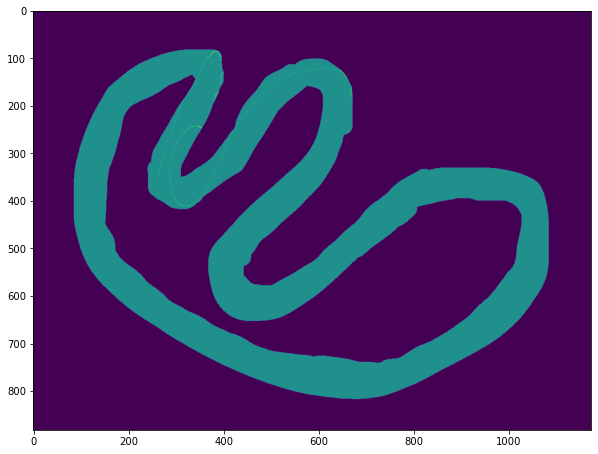

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 3s 7ms/sample - loss: 5.2459 - val_loss: 3.5353
Epoch 2/5
450/450 [==============================] - 4s 8ms/sample - loss: 5.0578 - val_loss: 3.4322
Epoch 3/5
450/450 [==============================] - 6s 13ms/sample - loss: 4.8843 - val_loss: 3.0580
Epoch 4/5
450/450 [==============================] - 5s 12ms/sample - loss: 4.7895 - val_loss: 3.5285
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.8036 - val_loss: 3.2105


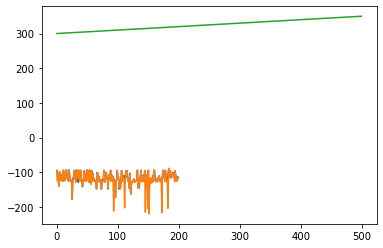

Unique speed values are: [ 0.          0.11803399  0.13196601  0.25        0.75        1.05409255
  1.11803399  1.13196601  1.25        1.41421356  1.41421356  1.75
  2.05409255  2.13196601  2.25        2.41421356  2.75        3.13196601
  3.20185043  3.25        3.41421356  3.66421356  3.75        4.13196601
  4.25        4.38196601  4.41421356  4.66421356  4.75        5.13196601
  5.16421356  5.20185043  5.25        5.38196601  5.66421356  5.75
  6.25        6.38196601  6.66421356  6.75        7.25        7.38196601
  7.55409255  7.66421356  7.75        8.25        8.38196601  8.41421356
  8.55409255  8.66421356  8.75        9.25        9.38196601  9.41421356
  9.66421356  9.75       10.20185043 10.25       10.38196601 10.41421356
 10.41421356 10.5        10.66421356 10.75       11.20185043 11.38196601
 11.41421356 11.5        11.66421356 11.66421356 11.75       12.
 12.20185043 12.38196601 12.41421356 12.5        12.66421356 12.88196601
 12.95185043 13.         13.5        13.664213

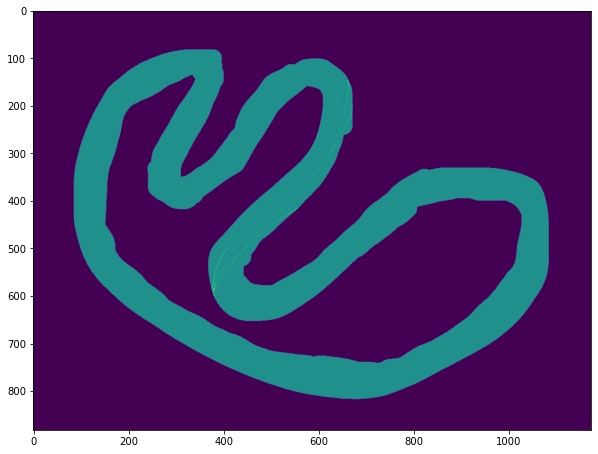

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.1922 - val_loss: 3.9320
Epoch 2/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.8438 - val_loss: 4.1712
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.7377 - val_loss: 3.5433
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.7887 - val_loss: 3.9213
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.7831 - val_loss: 3.7507


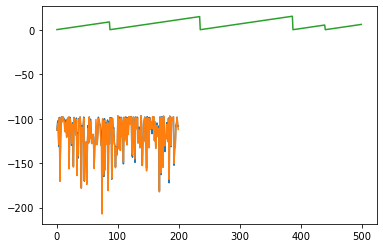

Unique speed values are: [ 0.          0.13196601  0.91421356  1.11803399  1.13196601  1.25
  1.41421356  1.41421356  1.91421356  2.05409255  2.41421356  2.91421356
  3.41421356  3.66421356  3.91421356  4.41421356  4.66421356  4.91421356
  5.16421356  5.41421356  5.91421356  6.16421356  6.41421356  6.91421356
  7.16421356  7.41421356  7.91421356  8.16421356  8.16421356  8.25
  8.41421356  8.41421356  8.91421356  9.16421356  9.38196601  9.41421356
  9.41421356  9.66421356  9.91421356 10.16421356 10.41421356 10.66421356
 10.91421356 11.16421356 11.20185043 11.41421356 11.5        11.91421356
 12.16421356 12.41421356 12.5        12.66421356 12.91421356 13.16421356
 13.41421356 13.5        13.91421356 14.16421356 14.41421356 14.91421356
 15.13196601 15.16421356 15.41421356 15.91421356 16.16421356 16.41421356
 16.66421356 16.88196601 16.91421356 16.95185043 17.         17.16421356
 17.16421356 17.41421356 17.41421356 17.91421356 18.16421356 18.16421356
 18.41421356 18.41421356 19.         1

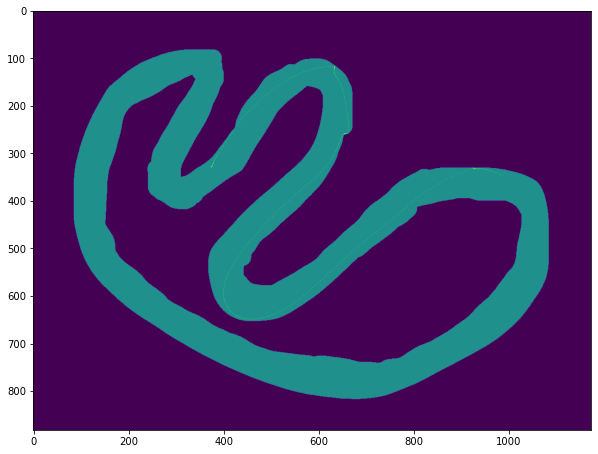

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.8336 - val_loss: 3.6237
Epoch 2/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.3195 - val_loss: 3.4819
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.2083 - val_loss: 3.7149
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.1702 - val_loss: 3.2436
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.9893 - val_loss: 3.0660


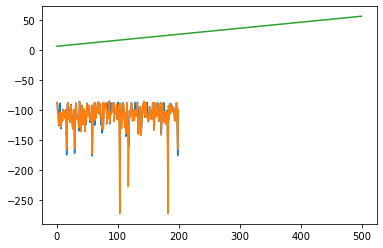

Unique speed values are: [ 0.          1.11803399  1.20185043  1.70185043  2.70185043  3.41421356
  3.70185043  4.70185043  5.70185043  5.91421356  6.41421356  6.70185043
  7.41421356  7.70185043  8.70185043  8.95185043  9.20185043  9.38196601
  9.95185043 10.16421356 10.41421356 10.66421356 10.95185043 11.16421356
 11.20185043 11.95185043 12.70185043 13.70185043 13.91421356 14.45185043
 15.45185043 16.20185043 17.20185043 17.91421356 18.16421356 18.20185043
 19.20185043 19.41421356 19.41421356 20.20185043 20.95185043 21.05409255
 21.41421356 21.95185043 22.16421356 22.41421356 22.95185043 23.41421356
 23.41421356 23.91421356 23.95185043 24.41421356 24.95185043 25.13196601
 25.95185043 26.41421356 26.91421356 26.95185043 27.91421356 27.95185043
 28.91421356 28.95185043 29.         29.95185043 30.16421356 30.41421356
 30.95185043 31.95185043 32.41421356 32.66421356 32.95185043 33.41421356
 33.41421356 33.95185043 34.41421356 34.95185043 35.20185043 35.41421356
 35.45185043 35.95185043 3

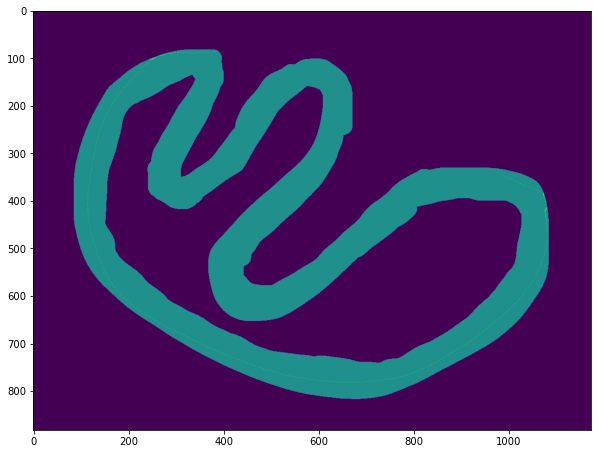

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 4s 9ms/sample - loss: 1.9580 - val_loss: 1.2933
Epoch 2/5
450/450 [==============================] - 2s 5ms/sample - loss: 1.6206 - val_loss: 1.2847
Epoch 3/5
450/450 [==============================] - 2s 5ms/sample - loss: 1.5129 - val_loss: 1.2338
Epoch 4/5
450/450 [==============================] - 4s 9ms/sample - loss: 1.4993 - val_loss: 1.6558
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 1.4669 - val_loss: 1.1419


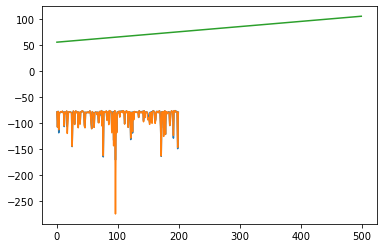

Unique speed values are: [ 0.          0.11803399  0.11803399  0.11803399  0.11803399  0.11803399
  0.11803399  0.13196601  0.13196601  0.13196601  0.13196601  0.13196601
  0.13196601  0.13196601  0.36803399  0.36803399  0.36803399  0.36803399
  0.36803399  0.36803399  0.36803399  0.36803399  0.38196601  0.38196601
  0.38196601  0.38196601  0.38196601  0.38196601  0.38196601  0.38196601
  0.38196601  0.38196601  0.38196601  0.61803399  0.61803399  0.61803399
  0.61803399  0.61803399  0.61803399  0.61803399  0.61803399  0.61803399
  0.61803399  0.61803399  0.63196601  0.63196601  0.63196601  0.63196601
  0.63196601  0.86803399  0.86803399  0.86803399  0.86803399  0.86803399
  0.88196601  0.88196601  0.88196601  0.88196601  1.11803399  1.11803399
  1.11803399  1.11803399  1.13196601  1.13196601  1.13196601  1.36803399
  1.36803399  1.38196601  1.38196601  1.38196601  1.38196601  1.63196601
  1.63196601  2.11803399  2.11803399  2.13196601  2.36803399  2.38196601
  2.38196601  2.63196601  

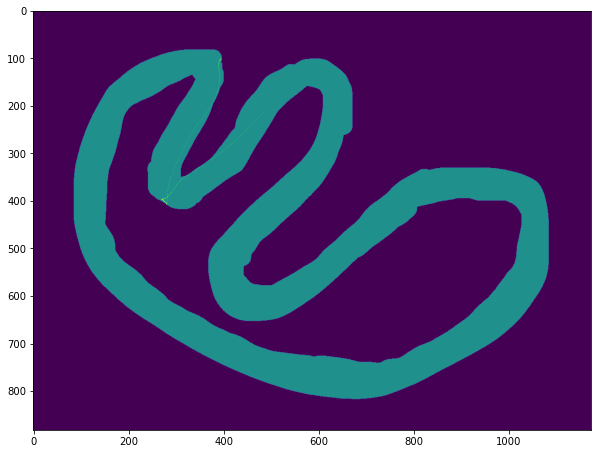

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 4s 9ms/sample - loss: 2.3398 - val_loss: 1.4146
Epoch 2/5
450/450 [==============================] - 5s 11ms/sample - loss: 1.8002 - val_loss: 1.4881
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 1.7535 - val_loss: 1.5850
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 1.7440 - val_loss: 1.5552
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 1.6991 - val_loss: 1.3276


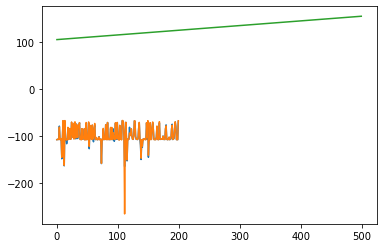

Unique speed values are: [ 0.          0.08578644  0.11803399  0.11803399  0.13196601  0.13196601
  0.13196601  0.13196601  0.16421356  0.33578644  0.36803399  0.36803399
  0.36803399  0.36803399  0.38196601  0.38196601  0.38196601  0.38196601
  0.38196601  0.41421356  0.58578644  0.61803399  0.61803399  0.61803399
  0.61803399  0.61803399  0.63196601  0.63196601  0.63196601  0.63196601
  0.66421356  0.66421356  0.88196601  0.91421356  0.91421356  1.11803399
  1.11803399  1.11803399  1.13196601  1.16421356  1.16421356  1.41421356
  1.41421356  1.63196601  1.66421356  1.66421356  1.91421356  2.11803399
  2.16421356  2.41421356  2.41421356  2.66421356  3.11803399  3.16421356
  3.41421356  3.41421356  3.66421356  3.70185043  4.16421356  4.41421356
  4.41421356  5.16421356  5.41421356  5.41421356  6.16421356  6.41421356
  6.41421356  6.91421356  7.16421356  7.41421356  7.41421356  7.66421356
  7.91421356  8.16421356  8.41421356  8.63196601  8.91421356  9.16421356
  9.41421356  9.91421356 1

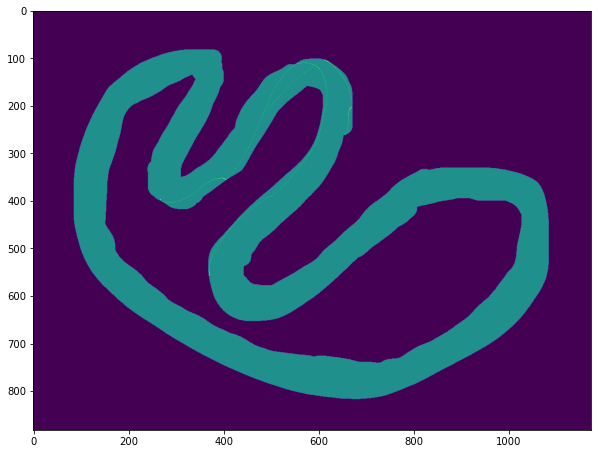

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 10ms/sample - loss: 2.7044 - val_loss: 1.4768
Epoch 2/5
450/450 [==============================] - 5s 10ms/sample - loss: 2.5413 - val_loss: 1.1588
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.4553 - val_loss: 1.2265
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.3821 - val_loss: 1.2628
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.3401 - val_loss: 1.0214


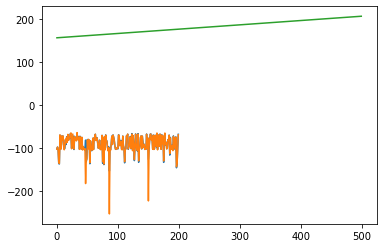

Unique speed values are: [ 0.          0.08578644  0.08578644  0.08578644  0.08578644  0.08578644
  0.08578644  0.08578644  0.08578644  0.08578644  0.08578644  0.08578644
  0.08578644  0.08578644  0.08578644  0.08578644  0.08578644  0.08578644
  0.08578644  0.11803399  0.16421356  0.16421356  0.16421356  0.16421356
  0.16421356  0.16421356  0.16421356  0.16421356  0.33578644  0.33578644
  0.33578644  0.33578644  0.33578644  0.33578644  0.33578644  0.33578644
  0.36803399  0.36803399  0.38196601  0.41421356  0.41421356  0.41421356
  0.41421356  0.41421356  0.41421356  0.41421356  0.41421356  0.41421356
  0.41421356  0.41421356  0.41421356  0.58578644  0.58578644  0.58578644
  0.58578644  0.58578644  0.58578644  0.58578644  0.58578644  0.58578644
  0.58578644  0.58578644  0.58578644  0.63196601  0.66421356  0.66421356
  0.66421356  0.66421356  0.66421356  0.66421356  0.66421356  0.66421356
  0.83578644  0.83578644  0.83578644  0.83578644  0.83578644  0.83578644
  0.83578644  0.83578644  

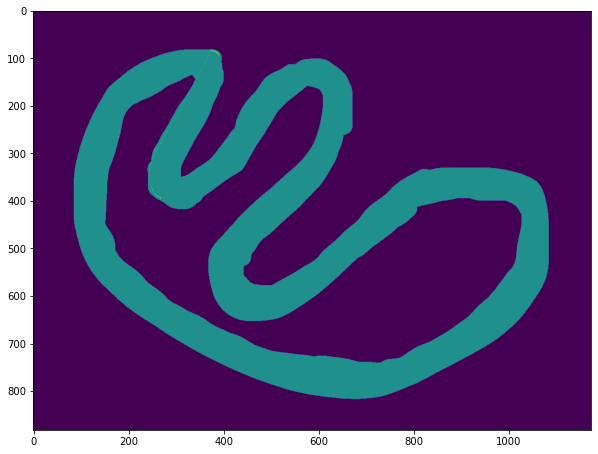

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.0487 - val_loss: 1.0596
Epoch 2/5
450/450 [==============================] - 5s 11ms/sample - loss: 1.7874 - val_loss: 1.0895
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 1.7399 - val_loss: 1.2523
Epoch 4/5
450/450 [==============================] - 4s 10ms/sample - loss: 1.7005 - val_loss: 1.1219
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 1.6680 - val_loss: 1.2868


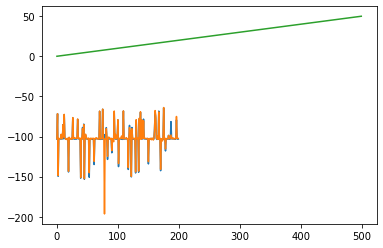

Unique speed values are: [0.00000000e+00 3.79996879e-02 8.57864376e-02 8.57864376e-02
 8.57864376e-02 8.57864376e-02 8.57864376e-02 8.57864376e-02
 8.57864376e-02 8.57864376e-02 1.18033989e-01 1.64213562e-01
 1.64213562e-01 2.50000000e-01 3.35786438e-01 3.35786438e-01
 3.81966011e-01 4.14213562e-01 4.14213562e-01 4.14213562e-01
 4.14213562e-01 4.14213562e-01 4.14213562e-01 4.14213562e-01
 5.85786438e-01 5.85786438e-01 5.85786438e-01 5.85786438e-01
 5.85786438e-01 5.85786438e-01 5.85786438e-01 6.31966011e-01
 6.64213562e-01 6.64213562e-01 6.64213562e-01 6.64213562e-01
 6.66666667e-01 7.12000312e-01 8.35786438e-01 8.35786438e-01
 8.35786438e-01 8.35786438e-01 8.35786438e-01 8.35786438e-01
 9.14213562e-01 9.14213562e-01 9.14213562e-01 9.14213562e-01
 9.62000312e-01 1.03077641e+00 1.03799969e+00 1.11803399e+00
 1.20185043e+00 1.20185043e+00 1.25000000e+00 1.41421356e+00
 1.41421356e+00 1.45185043e+00 1.66666667e+00 1.70185043e+00
 1.75000000e+00 1.78077641e+00 1.83578644e+00 1.83578644e+00

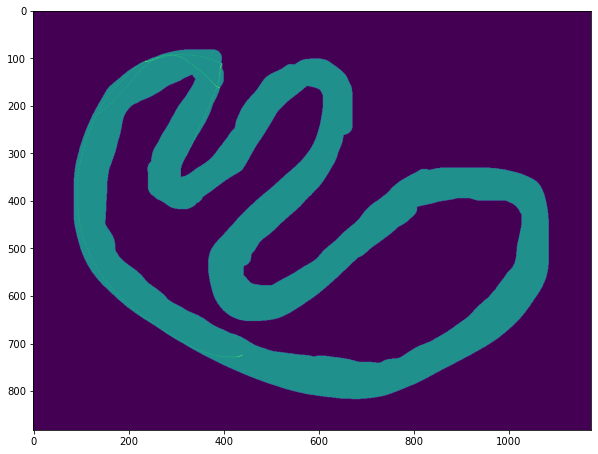

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 4s 9ms/sample - loss: 7.4849 - val_loss: 3.6796
Epoch 2/5
450/450 [==============================] - 4s 10ms/sample - loss: 7.0928 - val_loss: 3.6995
Epoch 3/5
450/450 [==============================] - 5s 12ms/sample - loss: 6.8309 - val_loss: 3.5607
Epoch 4/5
450/450 [==============================] - 5s 12ms/sample - loss: 6.7157 - val_loss: 3.4781
Epoch 5/5
450/450 [==============================] - 5s 12ms/sample - loss: 6.7402 - val_loss: 2.9740


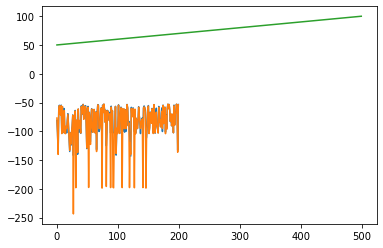

Unique speed values are: [ 0.          0.08578644  0.08578644  0.25        0.33578644  0.38196601
  0.41421356  0.5         0.58578644  0.58578644  0.63196601  0.66421356
  0.83578644  0.83578644  0.91421356  1.          1.03077641  1.05409255
  1.11803399  1.25        1.55409255  1.78077641  1.83578644  2.
  2.03077641  2.11803399  2.25        2.5         2.75        3.
  3.03077641  3.11803399  3.25        3.41421356  3.5         3.75
  4.          4.03077641  4.11803399  4.5         4.75        5.
  5.03077641  5.11803399  5.41421356  5.5         5.75        6.
  6.03077641  6.11803399  6.41421356  6.5         6.75        6.78077641
  6.91666667  7.          7.03077641  7.03077641  7.11803399  7.28077641
  7.41421356  7.5         7.53077641  7.75        8.          8.03077641
  8.03077641  8.11803399  8.28077641  8.5         8.53077641  8.75
  8.78077641  9.          9.03077641  9.11803399  9.28077641  9.5
  9.53077641  9.75        9.78077641 10.         10.03077641 10.11803399
 10.

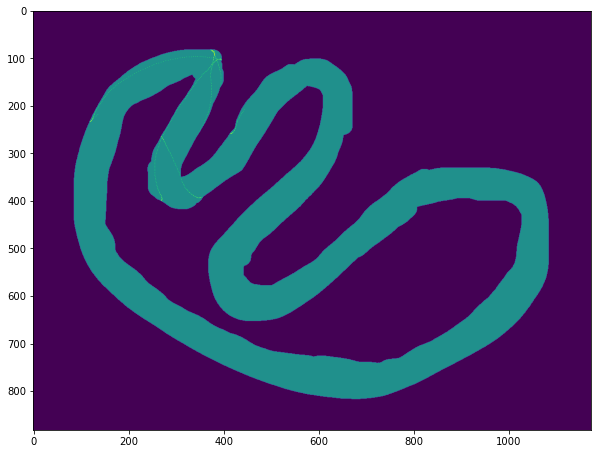

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 10ms/sample - loss: 4.6702 - val_loss: 5.4853
Epoch 2/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.5703 - val_loss: 6.0789
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.4348 - val_loss: 5.4592
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.2642 - val_loss: 5.6465
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.2047 - val_loss: 5.7655


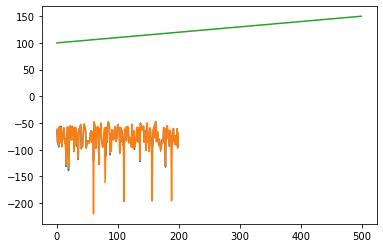

Unique speed values are: [ 0.          0.33333333  0.38196601  0.41666667  0.5         0.58578644
  0.66421356  0.71200031  0.91421356  1.          1.11803399  1.25
  1.25        1.33333333  1.41421356  1.41421356  1.5         1.71200031
  1.78077641  2.          2.11803399  2.25        2.33333333  2.41421356
  2.5         2.71200031  3.          3.11803399  3.33333333  3.41421356
  3.5         4.          4.11803399  4.33333333  4.41421356  4.5
  4.91421356  5.          5.11803399  5.33333333  5.41421356  5.5
  5.91421356  6.          6.11803399  6.33333333  6.33333333  6.5
  6.58333333  6.91421356  7.          7.08333333  7.11803399  7.33333333
  7.33333333  7.41421356  7.5         7.58333333  7.75        7.83333333
  7.83333333  7.91421356  8.          8.11803399  8.28077641  8.33333333
  8.33333333  8.5         8.53077641  8.58333333  8.83333333  8.91421356
  9.          9.08333333  9.11803399  9.33333333  9.5         9.58333333
  9.83333333  9.91421356 10.         10.08333333 10.1

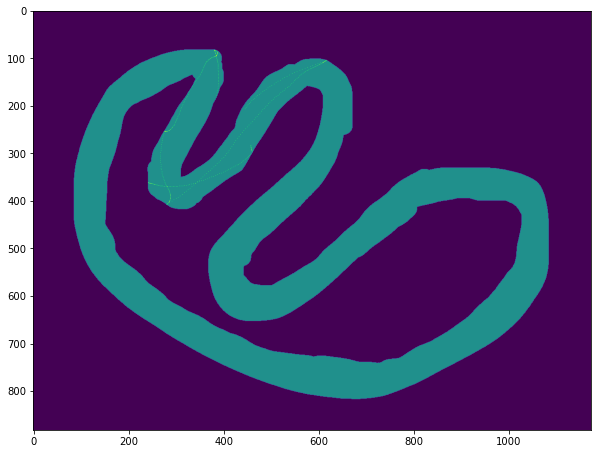

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.3530 - val_loss: 5.7209
Epoch 2/5
450/450 [==============================] - 6s 12ms/sample - loss: 3.9307 - val_loss: 5.7216
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.8249 - val_loss: 5.6129
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.8390 - val_loss: 5.8006
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.7460 - val_loss: 6.1619


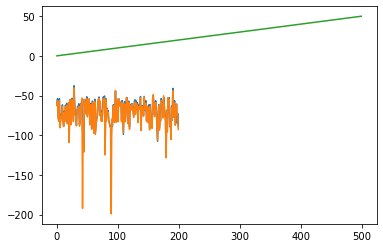

Unique speed values are: [ 0.          1.          1.03077641  1.11803399  1.20185043  1.20185043
  1.25        1.33333333  1.41421356  1.41421356  1.41421356  1.61803399
  1.71200031  1.78077641  1.86803399  2.          2.03077641  2.11803399
  2.20185043  2.25        2.41421356  2.61803399  2.71200031  2.78077641
  3.          3.03077641  3.25        3.41421356  3.5         3.61803399
  3.78077641  4.03077641  4.25        4.5         4.61803399  4.78077641
  5.          5.03077641  5.25        5.61803399  5.78077641  5.91421356
  6.03077641  6.25        6.61803399  6.78077641  7.03077641  7.25
  7.61803399  7.75        7.78077641  7.83333333  7.91421356  8.25
  8.28077641  8.5         8.61803399  8.78077641  8.91421356  9.03077641
  9.11803399  9.25        9.61803399  9.78077641  9.83333333  9.91421356
 10.03077641 10.25       10.61803399 10.78077641 10.91421356 11.03077641
 11.25       11.61803399 11.78077641 11.91421356 12.         12.03077641
 12.11803399 12.25       12.33333333 1

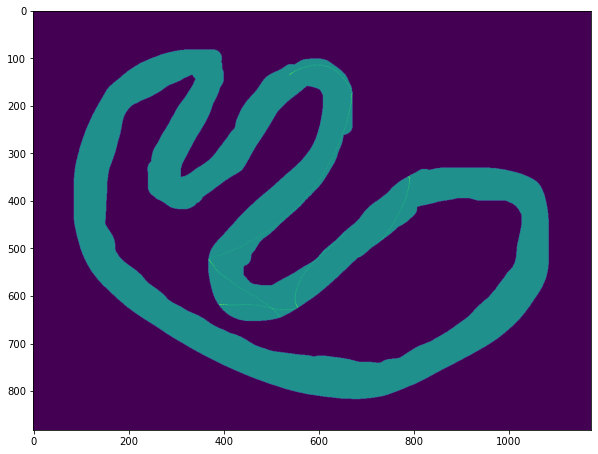

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 6s 13ms/sample - loss: 5.0514 - val_loss: 2.2178
Epoch 2/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.8137 - val_loss: 2.4220
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.7488 - val_loss: 1.9281
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.5896 - val_loss: 1.6521
Epoch 5/5
450/450 [==============================] - 5s 12ms/sample - loss: 4.6319 - val_loss: 1.5724


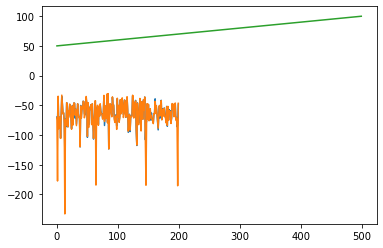

Unique speed values are: [ 0.          1.          1.41421356  1.41421356  1.71200031  2.
  2.16421356  2.20185043  2.41421356  2.78077641  3.          3.16421356
  3.41421356  4.          4.16421356  4.25        4.41421356  5.
  5.16421356  5.41421356  5.91421356  6.          6.16421356  6.41421356
  6.61803399  7.          7.16421356  7.41421356  7.91421356  8.
  8.16421356  8.28077641  8.41421356  9.          9.03077641  9.16421356
  9.41421356  9.91421356 10.         10.16421356 10.25       10.41421356
 11.         11.16421356 11.41421356 12.         12.16421356 12.41421356
 12.5        13.         13.16421356 13.41421356 13.53077641 13.78077641
 13.91421356 14.         14.16421356 14.25       14.41421356 14.91421356
 15.         15.41421356 15.91421356 16.         16.41421356 16.91421356
 17.         17.33333333 17.41421356 17.91421356 18.         18.41421356
 18.91421356 19.         19.41421356 19.41421356 20.         20.41421356
 20.41421356 20.53077641 21.         21.41421356 2

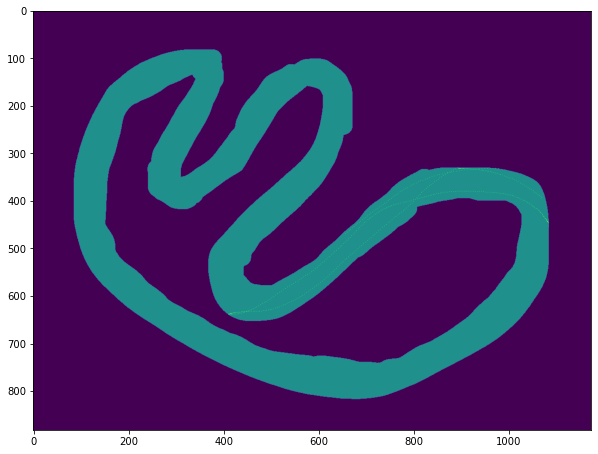

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.9233 - val_loss: 1.8100
Epoch 2/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.6613 - val_loss: 1.7190
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.6584 - val_loss: 1.7911
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.5973 - val_loss: 1.9559
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.4069 - val_loss: 1.7141


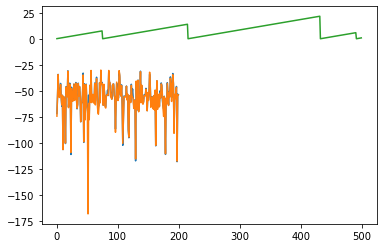

Unique speed values are: [ 0.          0.36803399  0.75        0.82073815  1.03077641  1.11803399
  1.11803399  1.25        1.36803399  1.41421356  1.5         1.57073815
  2.          2.03077641  2.11803399  2.20185043  2.25        2.36803399
  2.41421356  2.5         2.57073815  3.          3.16421356  3.36803399
  3.41421356  3.5         3.57073815  4.          4.16421356  4.36803399
  4.41421356  4.5         4.57073815  5.          5.36803399  5.41421356
  5.5         5.57073815  6.          6.36803399  6.41421356  6.5
  6.57073815  7.          7.36803399  7.41421356  7.5         7.57073815
  8.          8.36803399  8.41421356  8.5         8.57073815  9.
  9.36803399  9.41421356  9.5         9.57073815 10.         10.36803399
 10.41421356 10.5        10.57073815 11.         11.16421356 11.36803399
 11.41421356 11.5        11.57073815 12.         12.16421356 12.36803399
 12.41421356 12.5        12.57073815 13.         13.36803399 13.41421356
 13.5        13.57073815 14.         14.3

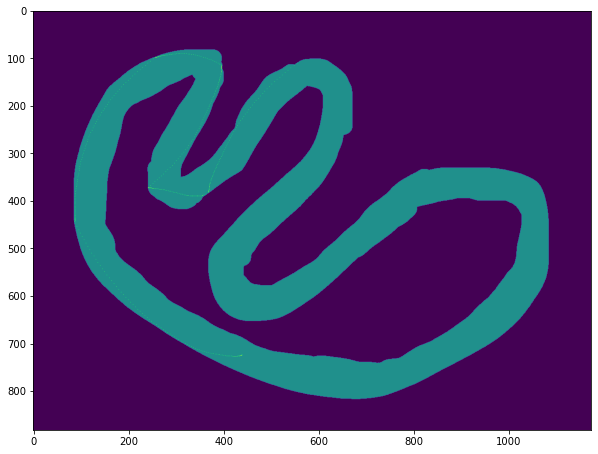

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 10ms/sample - loss: 3.4282 - val_loss: 2.1010
Epoch 2/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.9827 - val_loss: 2.1545
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.9722 - val_loss: 2.0891
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.8601 - val_loss: 2.3247
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.8119 - val_loss: 1.7048


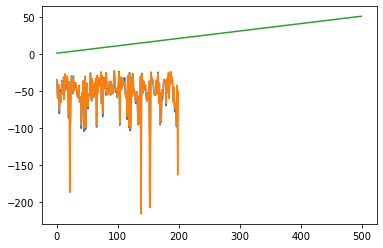

Unique speed values are: [ 0.          0.60092521  0.82073815  1.          1.00346621  1.25
  1.41421356  1.41421356  1.60092521  1.82073815  2.          2.00346621
  2.41421356  2.41421356  2.60092521  2.75346621  2.82073815  3.
  3.41421356  3.41421356  3.5         3.60092521  3.75346621  3.82073815
  4.          4.41421356  4.41421356  4.60092521  4.75346621  4.82073815
  5.          5.41421356  5.41421356  5.60092521  5.75346621  5.82073815
  5.85092521  6.          6.41421356  6.41421356  6.60092521  6.75346621
  6.82073815  6.85092521  7.          7.41421356  7.41421356  7.57073815
  7.75346621  7.82073815  7.85092521  8.          8.10092521  8.41421356
  8.75346621  8.82073815  9.          9.10092521  9.16421356  9.25
  9.36803399  9.41421356  9.75346621  9.82073815 10.         10.10092521
 10.16421356 10.25       10.41421356 10.41421356 10.57073815 10.75346621
 10.82073815 10.91421356 11.10092521 11.16421356 11.25       11.41421356
 11.57073815 11.66421356 11.75346621 11.820738

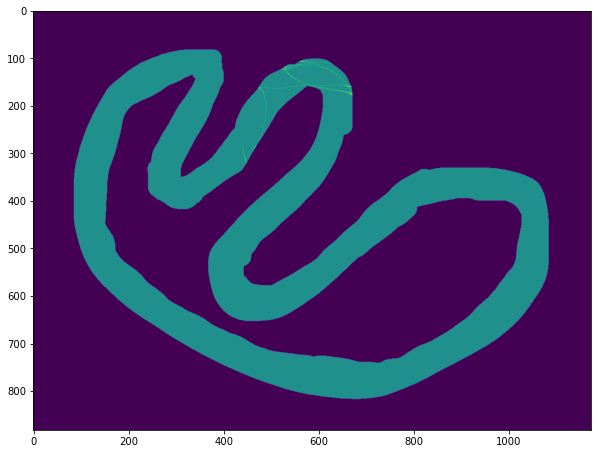

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.8198 - val_loss: 3.3854
Epoch 2/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.5386 - val_loss: 3.3020
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.4345 - val_loss: 3.1861
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.3422 - val_loss: 2.8988
Epoch 5/5
450/450 [==============================] - 5s 12ms/sample - loss: 3.3120 - val_loss: 2.9574


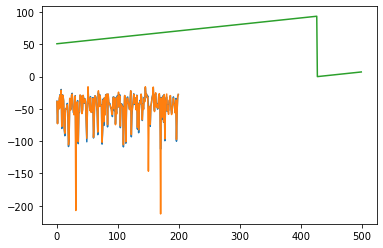

Unique speed values are: [ 0.          0.41666667  0.60092521  0.83333333  1.          1.00346621
  1.05409255  1.25        1.33333333  1.41421356  1.41666667  1.83333333
  2.          2.00346621  2.05409255  2.33333333  2.41421356  2.41666667
  2.75        3.05409255  3.33333333  3.41421356  3.41666667  4.05409255
  4.33333333  4.41421356  4.41421356  4.41666667  5.05409255  5.33333333
  5.41421356  5.41666667  5.60092521  5.75346621  6.05409255  6.33333333
  6.41421356  6.41421356  6.41666667  6.58333333  6.91666667  7.05409255
  7.16421356  7.58333333  7.91666667  8.05409255  8.10092521  8.16421356
  8.58333333  8.82073815  8.91666667  9.05409255  9.16421356  9.16666667
  9.41666667  9.58333333  9.75346621 10.05409255 10.16421356 10.16666667
 10.41421356 10.41421356 10.41666667 10.57073815 10.58333333 11.05409255
 11.10092521 11.16421356 11.25       11.30409255 11.41666667 11.58333333
 12.16421356 12.30409255 12.41421356 12.41666667 12.55409255 12.58333333
 13.08333333 13.10092521 1

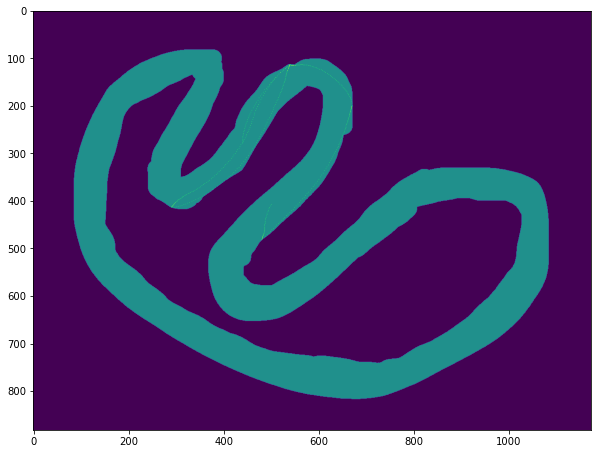

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 10ms/sample - loss: 3.8531 - val_loss: 4.8254
Epoch 2/5
450/450 [==============================] - 5s 12ms/sample - loss: 3.5534 - val_loss: 4.6045
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.5613 - val_loss: 4.5980
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.4292 - val_loss: 5.4852
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.3710 - val_loss: 4.7192


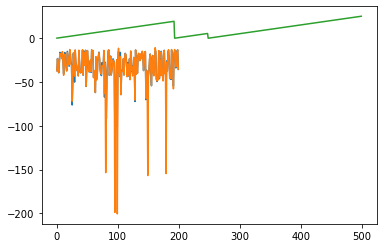

Unique speed values are: [ 0.          0.66421356  1.33333333  1.41421356  1.41421356  1.66421356
  1.83333333  2.33333333  2.41421356  2.41421356  2.66421356  3.41421356
  3.41421356  3.66421356  3.91421356  4.41421356  4.41421356  4.66421356
  5.41421356  5.41421356  5.66421356  6.41421356  6.41421356  6.41666667
  6.58333333  6.66421356  7.41421356  7.41421356  7.58333333  7.66421356
  7.91421356  8.10092521  8.41421356  8.66421356  8.91421356  9.05409255
  9.16666667  9.41421356  9.58333333  9.66421356  9.91421356 10.16666667
 10.66421356 10.91421356 11.41421356 11.41666667 11.66421356 11.91421356
 12.41421356 12.58333333 12.66421356 12.91421356 13.41421356 13.55409255
 13.66421356 13.91421356 14.41421356 14.66421356 14.91421356 15.16421356
 15.41421356 15.41421356 15.66421356 15.82073815 15.91421356 16.16421356
 16.41421356 16.41421356 16.66421356 16.66421356 16.91421356 16.91421356
 17.16421356 17.41421356 17.41666667 17.66421356 17.66421356 18.16421356
 18.41421356 18.66421356 1

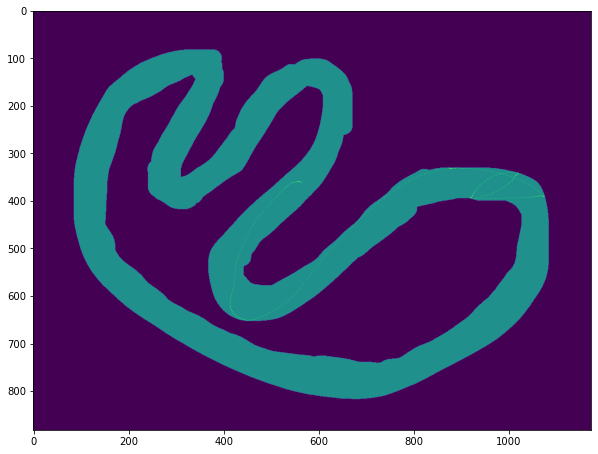

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.5554 - val_loss: 2.2343
Epoch 2/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.3009 - val_loss: 2.1346
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.2251 - val_loss: 1.6412
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.1561 - val_loss: 1.8054
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.0564 - val_loss: 1.9125


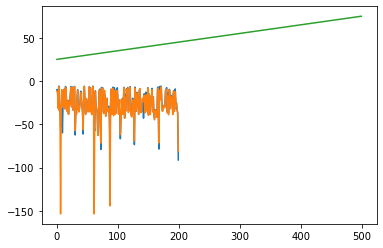

Unique speed values are: [ 0.          0.83333333  1.11803399  1.41421356  1.41421356  1.58333333
  2.11803399  2.33333333  2.41421356  2.41421356  2.83333333  3.11803399
  3.41421356  3.41421356  3.58333333  3.91421356  3.91421356  4.11803399
  4.41421356  4.58333333  4.91421356  4.91421356  5.11803399  5.41421356
  5.41421356  5.58333333  5.66421356  5.91421356  5.91421356  6.11803399
  6.41421356  6.58333333  6.66421356  6.66421356  6.91421356  6.91421356
  7.11803399  7.41421356  7.58333333  7.66421356  7.91421356  8.11803399
  8.41421356  8.58333333  8.66421356  8.91421356  9.05409255  9.11803399
  9.16666667  9.33333333  9.41421356  9.58333333  9.91421356 10.11803399
 10.33333333 10.41421356 10.91421356 11.11803399 11.41421356 11.91421356
 12.11803399 12.41421356 12.91421356 13.11803399 13.41421356 13.91421356
 14.11803399 14.41421356 14.61803399 14.86803399 14.91421356 15.11803399
 15.11803399 15.16421356 15.36803399 15.41421356 15.61803399 15.86803399
 15.91421356 16.11803399 1

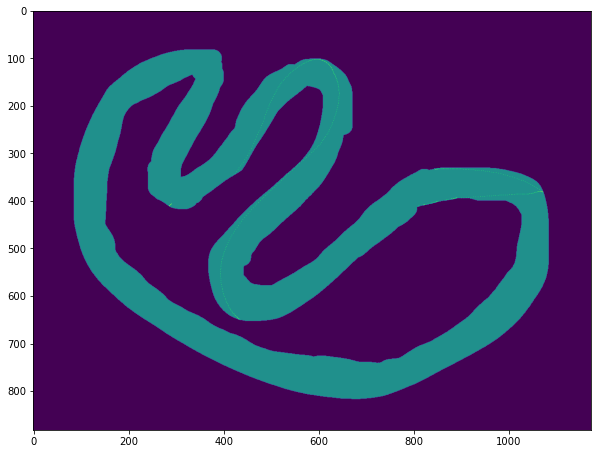

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.6275 - val_loss: 1.6577
Epoch 2/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.3287 - val_loss: 1.7036
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.2336 - val_loss: 1.6519
Epoch 4/5
450/450 [==============================] - 5s 12ms/sample - loss: 3.1599 - val_loss: 1.7235
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.2607 - val_loss: 1.9309


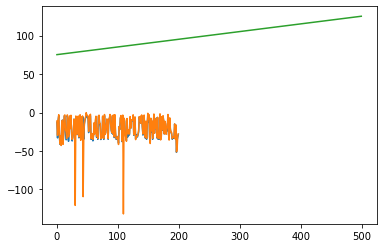

Unique speed values are: [ 0.          0.71200031  0.82073815  1.00346621  1.03077641  1.07073815
  1.11803399  1.41421356  1.41421356  1.53077641  1.71200031  1.82073815
  2.00346621  2.03077641  2.07073815  2.11803399  2.41421356  2.41421356
  2.41421356  2.53077641  2.75346621  2.78077641  2.83333333  3.07073815
  3.11803399  3.41421356  3.41421356  3.50346621  3.53077641  4.00346621
  4.07073815  4.11803399  4.41421356  4.41421356  4.50346621  4.53077641
  5.00346621  5.07073815  5.11803399  5.41421356  5.41421356  5.53077641
  5.82073815  6.00346621  6.11803399  6.41421356  6.41421356  6.53077641
  6.58333333  6.82073815  6.91421356  7.00346621  7.11803399  7.36803399
  7.41421356  7.41421356  7.53077641  7.66421356  7.82073815  7.91421356
  8.00346621  8.36803399  8.41421356  8.53077641  8.66421356  8.82073815
  8.91421356  9.00346621  9.36803399  9.41421356  9.53077641  9.66421356
  9.82073815 10.00346621 10.36803399 10.41421356 10.53077641 10.66421356
 10.82073815 10.83333333 1

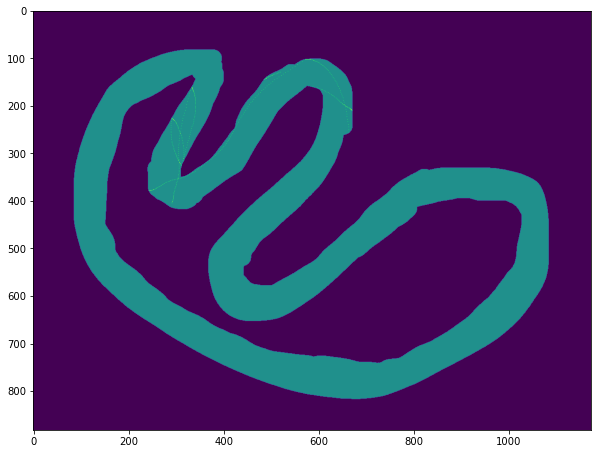

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 4s 10ms/sample - loss: 4.2525 - val_loss: 1.2479
Epoch 2/5
450/450 [==============================] - 4s 10ms/sample - loss: 3.9677 - val_loss: 1.0378
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.8549 - val_loss: 0.9825
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.8672 - val_loss: 0.9419
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.7591 - val_loss: 1.2397


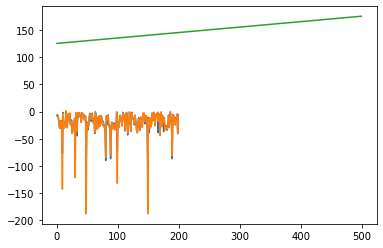

Unique speed values are: [ 0.          1.          1.03077641  1.25        1.41421356  1.41421356
  1.82073815  2.          2.          2.00346621  2.11803399  2.16421356
  2.41421356  2.41421356  2.41421356  2.5         3.          3.16421356
  3.41421356  3.41421356  3.41421356  3.5         3.91421356  4.41421356
  4.41421356  4.5         5.07073815  5.16421356  5.41421356  5.41421356
  5.5         6.11803399  6.16421356  6.41421356  6.41421356  6.5
  6.91421356  7.16421356  7.36803399  7.41421356  7.41421356  7.5
  8.16421356  8.36803399  8.41421356  8.5         8.66421356  8.91421356
  9.25        9.41421356  9.5         9.66421356  9.82073815 10.16421356
 10.25       10.41421356 10.66421356 11.25       11.41421356 11.66421356
 11.82073815 12.25       12.41421356 12.66421356 12.83333333 13.25
 13.41421356 13.66421356 13.86803399 14.25       14.41421356 14.66421356
 14.83333333 14.91421356 15.11803399 15.25       15.41421356 15.66421356
 15.91421356 16.         16.25       16.414213

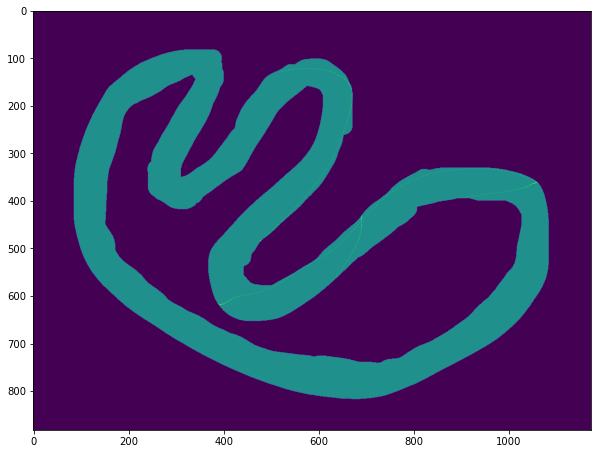

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 4s 9ms/sample - loss: 3.6687 - val_loss: 5.1210
Epoch 2/5
450/450 [==============================] - 5s 10ms/sample - loss: 3.4332 - val_loss: 5.1273
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.3659 - val_loss: 5.3732
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.3177 - val_loss: 5.2106
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.3621 - val_loss: 5.3758


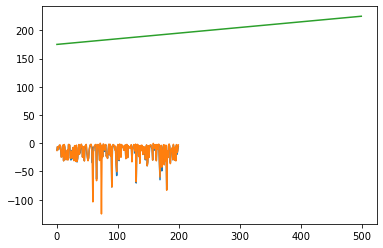

Unique speed values are: [ 0.          1.41421356  1.41421356  1.41421356  2.41421356  2.41421356
  2.41421356  2.91421356  3.41421356  3.41421356  3.41421356  3.91421356
  4.41421356  4.41421356  4.66421356  5.07073815  5.41421356  5.41421356
  5.66421356  6.41421356  6.41421356  6.66421356  7.41421356  7.41421356
  7.66421356  8.16421356  8.41421356  8.66421356  8.91421356  9.41421356
  9.66421356 10.41421356 10.66421356 10.91421356 11.16421356 11.41421356
 11.66421356 11.91421356 12.16421356 12.41421356 12.66421356 12.83333333
 12.91421356 13.16421356 13.41421356 13.66421356 14.16421356 14.41421356
 14.66421356 14.91421356 15.16421356 15.41421356 15.66421356 15.91421356
 16.16421356 16.41421356 16.5        16.66421356 16.91421356 17.16421356
 17.25       17.41421356 17.66421356 17.91421356 18.16421356 18.41421356
 18.66421356 18.91421356 19.16421356 19.41421356 19.5        19.66421356
 19.91421356 20.16421356 20.41421356 20.66421356 20.91421356 21.16421356
 21.41421356 21.66421356 2

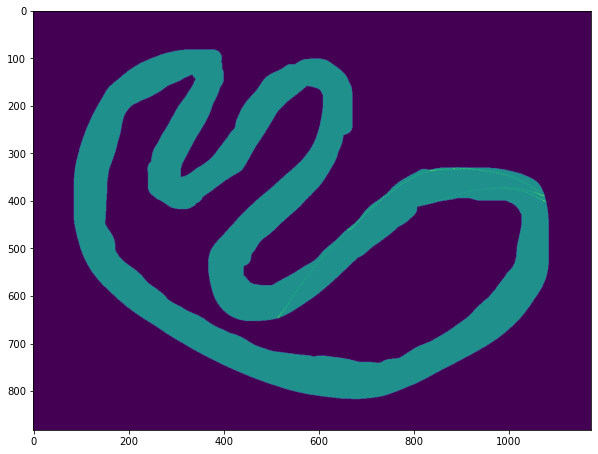

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.2316 - val_loss: 1.3596
Epoch 2/5
450/450 [==============================] - 5s 12ms/sample - loss: 3.1052 - val_loss: 1.5381
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.8911 - val_loss: 1.3481
Epoch 4/5
450/450 [==============================] - 5s 12ms/sample - loss: 2.9054 - val_loss: 1.3855
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.9080 - val_loss: 1.3400


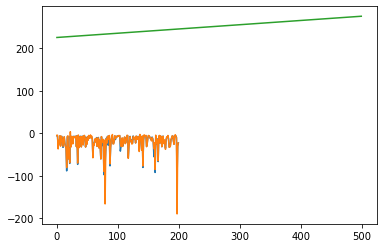

Unique speed values are: [ 0.          1.41421356  1.41421356  1.41421356  2.41421356  2.41421356
  2.66421356  2.91421356  3.41421356  3.66421356  4.16421356  4.41421356
  4.66421356  5.07073815  5.16421356  5.41421356  5.41421356  5.66421356
  5.91421356  6.16421356  6.66421356  6.91421356  7.41421356  7.41421356
  7.66421356  7.91421356  8.16421356  8.41421356  8.66421356  9.41421356
  9.66421356 10.41421356 10.66421356 10.91421356 11.41421356 11.66421356
 11.91421356 12.16421356 12.41421356 12.91421356 13.41421356 13.91421356
 14.41421356 14.91421356 15.41421356 15.91421356 16.41421356 16.5
 16.66421356 16.91421356 17.41421356 17.66421356 17.91421356 18.16421356
 18.41421356 18.91421356 19.41421356 19.91421356 20.41421356 20.91421356
 21.41421356 21.91421356 22.41421356 22.5        22.91421356 23.41421356
 23.91421356 24.41421356 24.91421356 25.41421356 25.91421356 26.41421356
 26.91421356 27.41421356 27.91421356 28.41421356 28.91421356 29.41421356
 29.91421356 30.41421356 30.91421

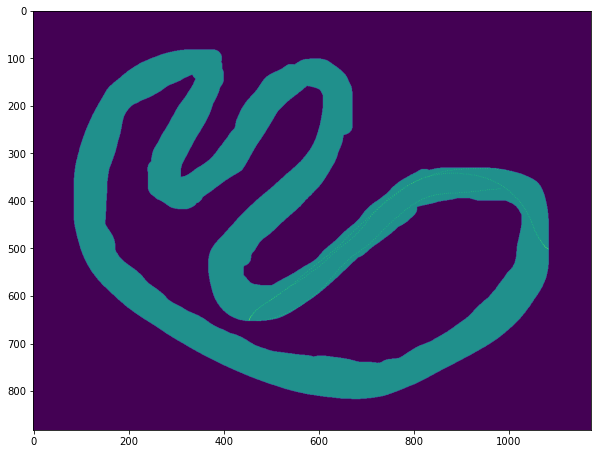

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.5862 - val_loss: 1.5564
Epoch 2/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.3405 - val_loss: 1.8564
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.1757 - val_loss: 1.4770
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.1554 - val_loss: 1.5673
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.1160 - val_loss: 1.5760


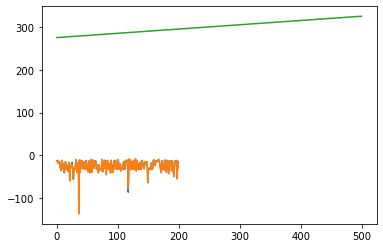

Unique speed values are: [ 0.          0.5         0.75        1.41421356  1.41421356  1.41421356
  1.75        2.41421356  2.41421356  2.75        2.91421356  3.41421356
  3.41421356  3.75        4.41421356  4.41421356  4.75        5.41421356
  5.41421356  5.75        5.91421356  6.41421356  6.41421356  6.75
  6.91421356  7.41421356  7.41421356  7.75        7.91421356  7.91421356
  8.41421356  8.41421356  8.66421356  8.75        8.91421356  9.66421356
  9.66421356  9.75        9.91421356 10.41421356 10.66421356 10.75
 10.91421356 11.66421356 11.66421356 11.75       11.91421356 12.41421356
 12.66421356 12.75       12.91421356 13.66421356 13.75       13.91421356
 14.66421356 14.75       14.91421356 15.66421356 15.75       15.91421356
 16.41421356 16.66421356 16.75       16.91421356 17.16421356 17.16421356
 17.41421356 17.66421356 17.75       17.91421356 18.16421356 18.41421356
 18.41421356 18.66421356 18.66421356 18.75       18.91421356 19.16421356
 19.66421356 19.66421356 19.75       1

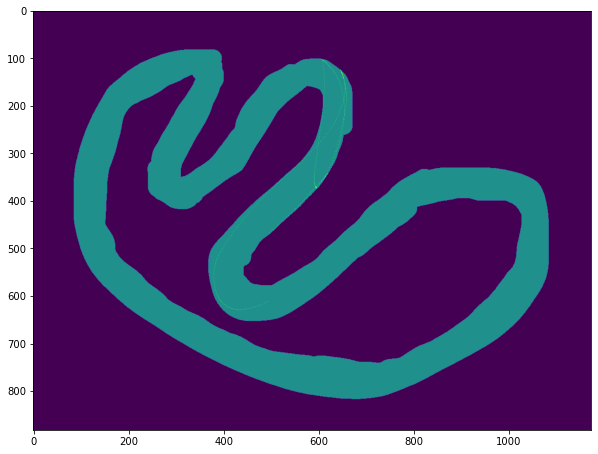

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.1736 - val_loss: 2.2663
Epoch 2/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.8683 - val_loss: 2.5086
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.7550 - val_loss: 1.8665
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.5817 - val_loss: 2.1277
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.6376 - val_loss: 2.3387


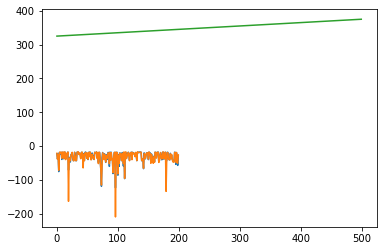

Unique speed values are: [ 0.          0.66421356  1.41421356  1.41421356  1.66421356  2.41421356
  2.41421356  2.66421356  3.41421356  3.41421356  4.41421356  4.41421356
  5.41421356  5.41421356  5.75        6.41421356  6.41421356  7.16421356
  7.41421356  7.41421356  7.75        7.91421356  8.16421356  8.41421356
  8.91421356  9.41421356  9.66421356  9.66421356  9.91421356 10.41421356
 10.66421356 10.75       10.91421356 11.41421356 11.91421356 12.41421356
 12.66421356 12.91421356 13.41421356 13.91421356 14.41421356 14.91421356
 15.41421356 15.91421356 16.41421356 16.91421356 17.41421356 17.41421356
 17.91421356 18.41421356 18.66421356 18.91421356 19.41421356 19.91421356
 20.41421356 20.91421356 20.91421356 21.41421356 21.91421356 22.41421356
 22.66421356 22.75       22.91421356 23.41421356 23.91421356 23.91421356
 24.41421356 24.91421356 24.91421356 25.41421356 25.91421356 26.41421356
 26.91421356 26.91421356 27.41421356 27.66421356 27.91421356 27.91421356
 28.16421356 28.41421356 2

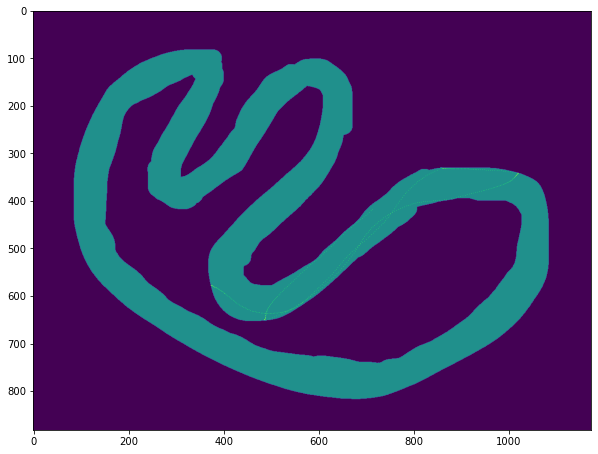

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.4556 - val_loss: 1.1389
Epoch 2/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.0644 - val_loss: 1.1267
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 1.9232 - val_loss: 1.0116
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 1.9044 - val_loss: 1.0579
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 1.8681 - val_loss: 1.1577


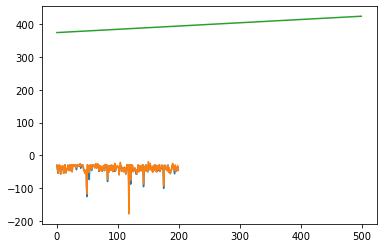

Unique speed values are: [ 0.          1.41421356  1.41421356  1.41421356  1.66421356  1.91421356
  2.41421356  2.41421356  2.66421356  2.91421356  3.41421356  3.41421356
  3.66421356  3.91421356  4.41421356  4.41421356  4.66421356  4.91421356
  5.41421356  5.41421356  5.66421356  5.91421356  5.91421356  6.41421356
  6.41421356  6.66421356  6.91421356  6.91421356  7.16421356  7.41421356
  7.41421356  7.66421356  7.75        7.91421356  8.16421356  8.41421356
  8.66421356  8.91421356  9.16421356  9.41421356  9.66421356  9.91421356
 10.16421356 10.41421356 10.66421356 10.91421356 11.16421356 11.41421356
 11.66421356 11.91421356 12.16421356 12.41421356 12.91421356 13.41421356
 13.91421356 14.41421356 14.91421356 15.41421356 15.91421356 16.41421356
 16.91421356 17.41421356 17.91421356 18.41421356 18.91421356 19.41421356
 19.91421356 20.41421356 20.91421356 21.41421356 21.91421356 22.41421356
 22.91421356 23.41421356 23.91421356 24.16421356 24.41421356 24.91421356
 24.91421356 25.16421356 2

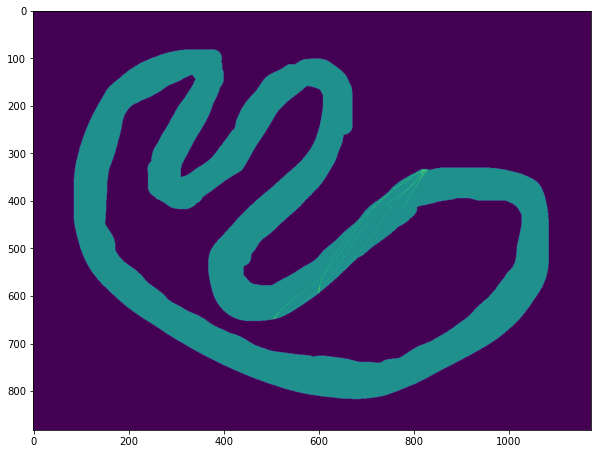

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.5911 - val_loss: 1.1542
Epoch 2/5
450/450 [==============================] - 5s 12ms/sample - loss: 2.1316 - val_loss: 0.9624
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.0080 - val_loss: 1.1346
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 1.9514 - val_loss: 1.1167
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 1.8808 - val_loss: 1.1765


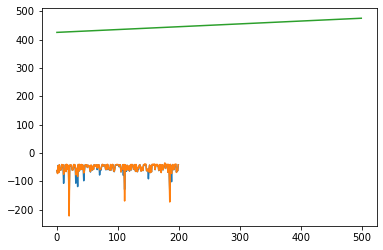

Unique speed values are: [ 0.          1.41421356  1.41421356  1.41421356  1.66421356  2.41421356
  3.16421356  3.41421356  4.16421356  4.41421356  4.41421356  4.66421356
  4.91421356  5.16421356  5.41421356  6.16421356  6.41421356  6.66421356
  7.16421356  7.41421356  7.41421356  7.66421356  8.16421356  8.41421356
  8.41421356  9.16421356  9.41421356  9.41421356  9.66421356  9.91421356
 10.16421356 10.41421356 10.41421356 10.66421356 10.91421356 11.16421356
 11.41421356 11.41421356 12.16421356 12.16421356 12.41421356 12.41421356
 12.91421356 13.16421356 13.41421356 13.41421356 13.91421356 14.16421356
 14.41421356 14.41421356 14.91421356 15.16421356 15.41421356 15.41421356
 15.91421356 16.16421356 16.41421356 16.41421356 16.91421356 17.16421356
 17.41421356 17.41421356 17.91421356 18.16421356 18.41421356 18.41421356
 19.16421356 19.41421356 19.41421356 20.16421356 20.41421356 20.41421356
 20.91421356 21.16421356 21.41421356 21.41421356 21.91421356 22.16421356
 22.41421356 22.41421356 2

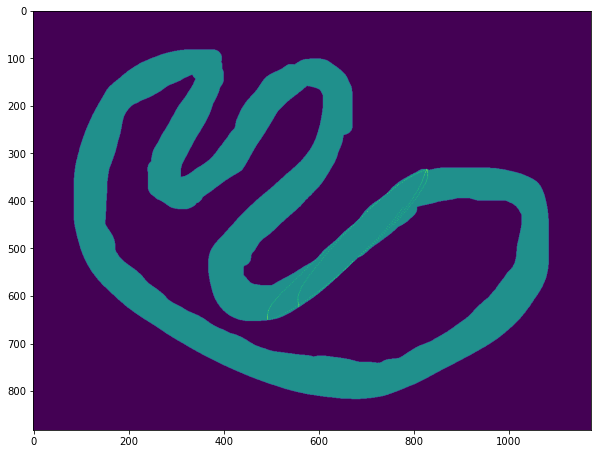

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 4s 10ms/sample - loss: 5.0046 - val_loss: 2.3301
Epoch 2/5
450/450 [==============================] - 5s 10ms/sample - loss: 4.1869 - val_loss: 2.1015
Epoch 3/5
450/450 [==============================] - 4s 10ms/sample - loss: 4.3016 - val_loss: 2.1540
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.0685 - val_loss: 3.2276
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.9005 - val_loss: 1.9074


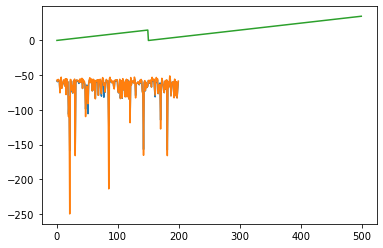

Unique speed values are: [0.00000000e+00 3.79996879e-02 2.87999688e-01 7.12000312e-01
 9.62000312e-01 1.25000000e+00 1.41421356e+00 1.50000000e+00
 1.96200031e+00 2.41421356e+00 2.50000000e+00 2.96200031e+00
 3.41421356e+00 3.50000000e+00 3.96200031e+00 4.50000000e+00
 4.96200031e+00 5.41421356e+00 5.50000000e+00 5.96200031e+00
 6.50000000e+00 6.96200031e+00 7.16421356e+00 7.50000000e+00
 7.75000000e+00 7.96200031e+00 8.00000000e+00 8.41421356e+00
 8.41421356e+00 8.71200031e+00 9.00000000e+00 9.41421356e+00
 9.71200031e+00 1.00000000e+01 1.04142136e+01 1.07120003e+01
 1.10000000e+01 1.17120003e+01 1.20000000e+01 1.21642136e+01
 1.27120003e+01 1.30000000e+01 1.37120003e+01 1.40000000e+01
 1.47120003e+01 1.50000000e+01 1.57120003e+01 1.57500000e+01
 1.59142136e+01 1.64142136e+01 1.67120003e+01 1.67500000e+01
 1.74142136e+01 1.77120003e+01 1.77500000e+01 1.79142136e+01
 1.84142136e+01 1.87120003e+01 1.87500000e+01 1.89620003e+01
 1.92120003e+01 1.97120003e+01 1.97500000e+01 1.99620003e+01

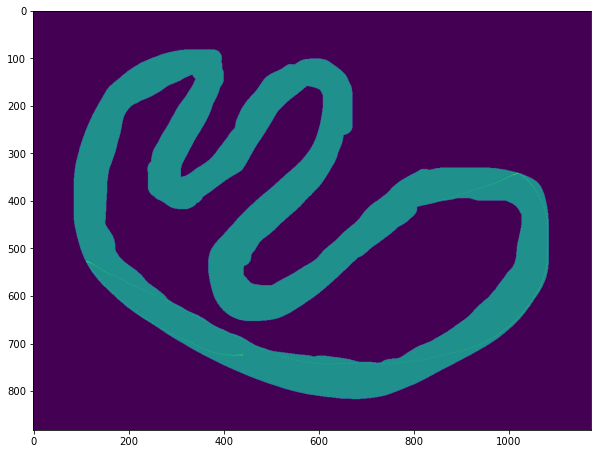

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 3s 7ms/sample - loss: 6.1337 - val_loss: 4.1876
Epoch 2/5
450/450 [==============================] - 5s 11ms/sample - loss: 5.5180 - val_loss: 3.9212
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 5.2805 - val_loss: 3.8680
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 5.2683 - val_loss: 3.9077
Epoch 5/5
450/450 [==============================] - 5s 12ms/sample - loss: 5.0037 - val_loss: 3.3526


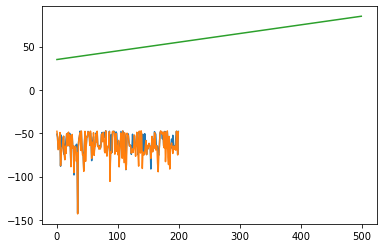

Unique speed values are: [ 0.          0.28799969  1.16421356  1.41421356  1.41421356  1.66421356
  2.16421356  2.41421356  2.66421356  3.16421356  3.41421356  3.66421356
  3.96200031  4.41421356  4.5         4.66421356  5.16421356  5.41421356
  6.16421356  6.41421356  6.5         6.96200031  7.16421356  7.41421356
  7.5         8.16421356  8.16421356  8.41421356  8.66421356  9.16421356
  9.41421356 10.16421356 10.41421356 11.         11.16421356 11.41421356
 12.16421356 12.41421356 13.16421356 13.41421356 13.91421356 14.16421356
 14.91421356 14.91421356 15.16421356 15.91421356 15.91421356 16.16421356
 16.91421356 16.91421356 17.16421356 17.91421356 17.91421356 18.16421356
 18.66421356 18.71200031 18.91421356 18.91421356 19.16421356 19.16421356
 19.66421356 19.91421356 20.16421356 20.16421356 20.66421356 20.91421356
 20.96200031 21.16421356 21.16421356 21.46200031 21.66421356 21.71200031
 21.91421356 22.16421356 22.16421356 22.71200031 22.75       22.91421356
 23.16421356 23.16421356 2

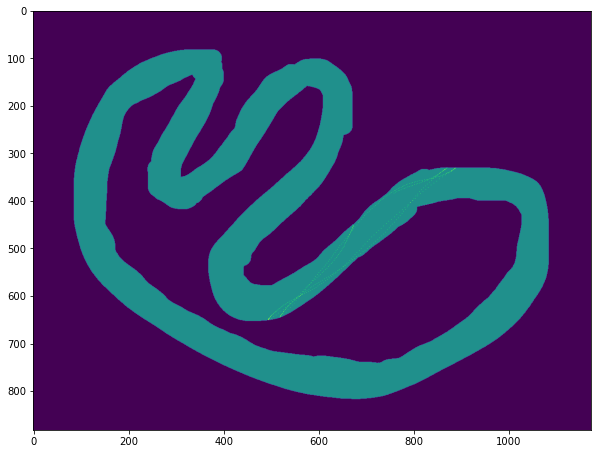

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 4s 9ms/sample - loss: 2.8356 - val_loss: 1.3393
Epoch 2/5
450/450 [==============================] - 5s 10ms/sample - loss: 2.5257 - val_loss: 1.6792
Epoch 3/5
450/450 [==============================] - 5s 10ms/sample - loss: 2.5087 - val_loss: 1.5178
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.4352 - val_loss: 1.6337
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.3712 - val_loss: 1.7302


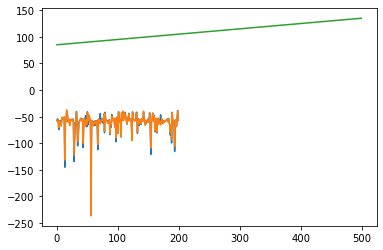

Unique speed values are: [ 0.          0.17926185  0.82073815  1.05409255  1.17926185  1.41421356
  1.41421356  1.41421356  2.05409255  2.16421356  2.17926185  2.41421356
  2.41421356  3.05409255  3.16421356  3.17926185  3.41421356  3.41421356
  3.55409255  3.66421356  4.17926185  4.41421356  4.41421356  4.5
  4.55409255  4.91421356  5.16421356  5.17926185  5.30409255  5.41421356
  5.41421356  5.91421356  6.16421356  6.17926185  6.30409255  6.41421356
  6.41421356  6.91421356  7.05409255  7.16421356  7.16421356  7.17926185
  7.41421356  7.66421356  7.80409255  7.91421356  8.16421356  8.16421356
  8.17926185  8.41421356  8.55409255  8.66421356  8.91421356  9.16421356
  9.17926185  9.41421356  9.55409255  9.66421356  9.91421356 10.16421356
 10.17926185 10.41421356 10.55409255 10.66421356 11.16421356 11.17926185
 11.41421356 11.55409255 11.66421356 12.16421356 12.17926185 12.41421356
 12.55409255 12.66421356 13.16421356 13.17926185 13.41421356 13.55409255
 13.66421356 13.91421356 14.05409

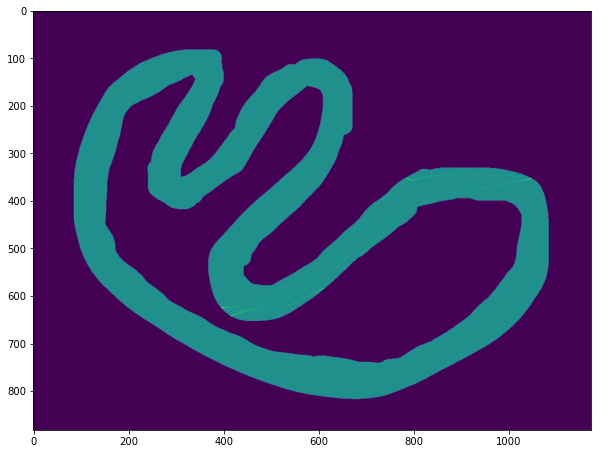

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 4s 9ms/sample - loss: 2.4529 - val_loss: 2.2559
Epoch 2/5
450/450 [==============================] - 4s 9ms/sample - loss: 2.2820 - val_loss: 2.4109
Epoch 3/5
450/450 [==============================] - 5s 10ms/sample - loss: 2.1703 - val_loss: 2.1668
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.1377 - val_loss: 2.1458
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.1086 - val_loss: 2.2381


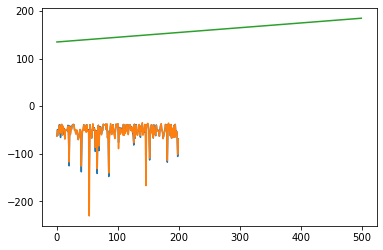

Unique speed values are: [ 0.          1.05409255  1.25        1.41421356  1.41421356  1.91421356
  2.05409255  2.16421356  2.25        2.41421356  2.41421356  2.91421356
  3.16421356  3.17926185  3.25        3.41421356  3.66421356  3.91421356
  4.25        4.41421356  4.66421356  4.91421356  5.25        5.30409255
  5.41421356  5.41421356  5.91421356  6.25        6.30409255  6.41421356
  6.41421356  6.66421356  7.25        7.41421356  7.41421356  7.66421356
  8.25        8.41421356  8.66421356  9.25        9.41421356  9.66421356
  9.75        9.91421356 10.41421356 10.66421356 10.75       10.91421356
 11.16421356 11.41421356 11.55409255 11.66421356 11.75       11.91421356
 12.41421356 12.55409255 12.66421356 12.75       12.91421356 13.41421356
 13.66421356 13.75       13.91421356 14.17926185 14.41421356 14.66421356
 14.75       14.91421356 15.16421356 15.41421356 15.66421356 15.75
 15.91421356 16.16421356 16.41421356 16.66421356 16.75       16.91421356
 17.41421356 17.66421356 17.75  

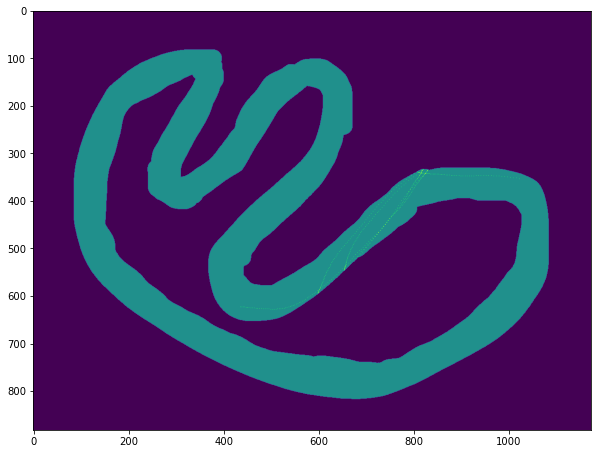

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.6244 - val_loss: 3.6072
Epoch 2/5
450/450 [==============================] - 4s 10ms/sample - loss: 2.4738 - val_loss: 3.5819
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.2802 - val_loss: 3.5287
Epoch 4/5
450/450 [==============================] - 4s 9ms/sample - loss: 2.2727 - val_loss: 3.1631
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.1885 - val_loss: 3.5474


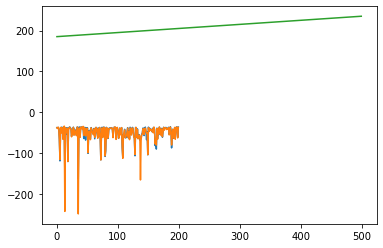

Unique speed values are: [ 0.          1.16421356  1.41421356  1.41421356  1.66421356  2.16421356
  2.41421356  2.66421356  3.41421356  3.66421356  3.66421356  4.41421356
  4.66421356  5.16421356  5.41421356  5.41421356  5.66421356  5.91421356
  6.16421356  6.41421356  6.66421356  6.91421356  7.16421356  7.41421356
  7.66421356  8.16421356  8.41421356  8.66421356  8.91421356  8.91421356
  9.41421356  9.66421356  9.91421356  9.91421356 10.41421356 10.66421356
 10.66421356 10.91421356 11.41421356 11.41421356 11.91421356 12.41421356
 12.91421356 13.41421356 13.66421356 13.91421356 14.41421356 14.91421356
 14.91421356 15.16421356 15.41421356 15.91421356 16.41421356 16.91421356
 17.41421356 17.91421356 18.41421356 18.91421356 19.41421356 19.91421356
 20.41421356 20.66421356 20.91421356 21.41421356 21.66421356 21.91421356
 22.16421356 22.41421356 22.66421356 22.91421356 23.16421356 23.41421356
 23.66421356 23.75       23.91421356 24.16421356 24.16421356 24.66421356
 24.75       24.91421356 2

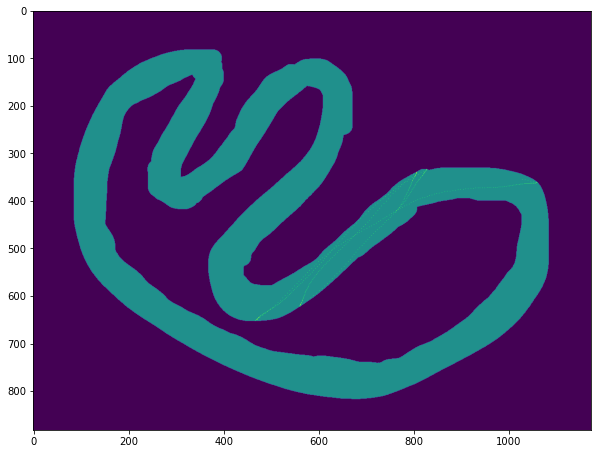

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 4s 9ms/sample - loss: 2.2493 - val_loss: 2.3694
Epoch 2/5
450/450 [==============================] - 5s 10ms/sample - loss: 2.1080 - val_loss: 2.3023
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.1453 - val_loss: 2.2774
Epoch 4/5
450/450 [==============================] - 4s 10ms/sample - loss: 2.1389 - val_loss: 1.9685
Epoch 5/5
450/450 [==============================] - 4s 10ms/sample - loss: 2.0500 - val_loss: 1.9447


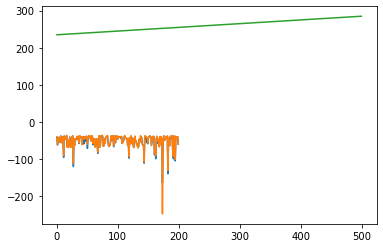

Unique speed values are: [0.00000000e+00 3.07764064e-02 5.30776406e-01 1.03077641e+00
 1.41421356e+00 1.41421356e+00 1.41421356e+00 1.53077641e+00
 2.16421356e+00 2.41421356e+00 2.41421356e+00 2.53077641e+00
 2.66421356e+00 2.91421356e+00 3.41421356e+00 3.53077641e+00
 3.66421356e+00 3.91421356e+00 4.41421356e+00 4.53077641e+00
 4.66421356e+00 4.91421356e+00 5.41421356e+00 5.41421356e+00
 5.53077641e+00 5.66421356e+00 5.91421356e+00 6.16421356e+00
 6.41421356e+00 6.53077641e+00 6.66421356e+00 7.16421356e+00
 7.41421356e+00 7.53077641e+00 7.66421356e+00 8.16421356e+00
 8.41421356e+00 8.41421356e+00 8.53077641e+00 8.66421356e+00
 9.16421356e+00 9.41421356e+00 9.41421356e+00 9.53077641e+00
 9.66421356e+00 9.91421356e+00 1.01642136e+01 1.04142136e+01
 1.04142136e+01 1.05307764e+01 1.06642136e+01 1.06642136e+01
 1.07807764e+01 1.11642136e+01 1.14142136e+01 1.14142136e+01
 1.15307764e+01 1.16642136e+01 1.17807764e+01 1.22807764e+01
 1.24142136e+01 1.24142136e+01 1.26642136e+01 1.32807764e+01

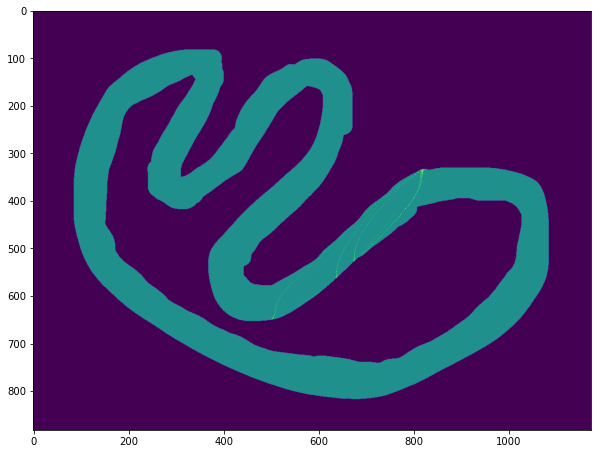

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 3s 7ms/sample - loss: 3.4134 - val_loss: 1.9135
Epoch 2/5
450/450 [==============================] - 4s 10ms/sample - loss: 3.1079 - val_loss: 1.7052
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.0743 - val_loss: 1.9034
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.9125 - val_loss: 2.3501
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.9635 - val_loss: 2.3213


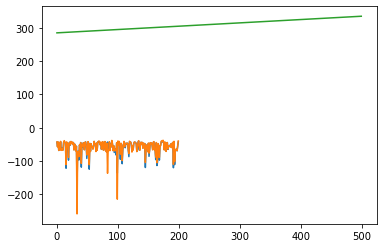

Unique speed values are: [ 0.          0.20185043  0.29814957  0.29814957  0.41421356  0.45185043
  0.54814957  0.58578644  0.70185043  0.79814957  1.20185043  1.41421356
  1.41421356  1.45185043  1.58578644  2.41421356  2.45185043  2.58578644
  3.41421356  3.45185043  3.58578644  4.41421356  4.45185043  4.58578644
  5.41421356  5.45185043  5.53077641  5.58578644  5.66421356  6.41421356
  6.45185043  6.58578644  6.66421356  7.16421356  7.41421356  7.45185043
  7.58578644  8.16421356  8.41421356  8.45185043  8.58578644  8.95185043
  9.16421356  9.20185043  9.41421356  9.45185043  9.58578644  9.66421356
 10.08578644 10.33578644 10.41421356 10.45185043 10.58578644 10.66421356
 10.91421356 10.95185043 11.20185043 11.58578644 11.91421356 11.95185043
 12.20185043 12.41421356 12.58578644 12.66421356 13.08578644 13.20185043
 13.41421356 13.66421356 13.91421356 14.08578644 14.20185043 14.41421356
 14.91421356 15.08578644 15.16421356 15.20185043 15.41421356 15.58578644
 15.91421356 16.20185043 1

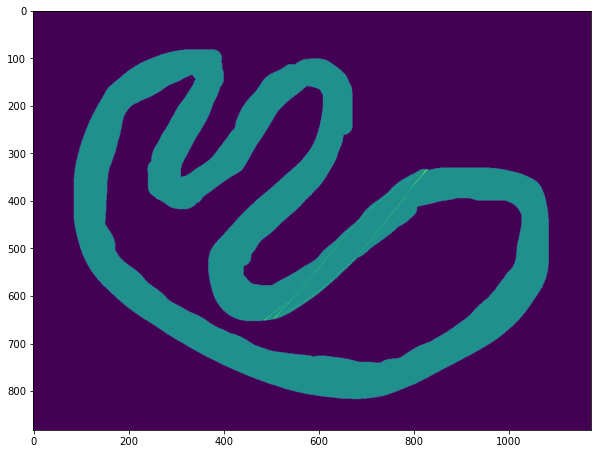

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 4s 10ms/sample - loss: 2.6379 - val_loss: 1.9721
Epoch 2/5
450/450 [==============================] - 4s 10ms/sample - loss: 2.1652 - val_loss: 2.2159
Epoch 3/5
450/450 [==============================] - 4s 10ms/sample - loss: 2.1380 - val_loss: 2.1270
Epoch 4/5
450/450 [==============================] - 4s 10ms/sample - loss: 2.0227 - val_loss: 1.7114
Epoch 5/5
450/450 [==============================] - 4s 10ms/sample - loss: 1.9928 - val_loss: 2.6069


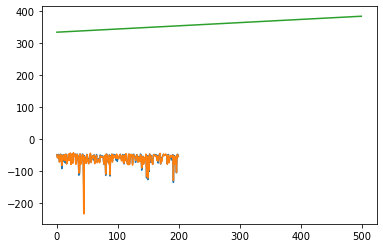

Unique speed values are: [ 0.          0.5         0.58578644  1.25        1.41421356  1.41421356
  1.5         2.25        2.41421356  2.5         3.25        3.41421356
  3.5         4.25        4.41421356  4.45185043  4.5         5.25
  5.41421356  5.5         6.25        6.41421356  6.5         7.
  7.25        7.41421356  7.5         8.          8.25        8.41421356
  8.58578644  8.66421356  9.          9.25        9.41421356  9.66421356
 10.         10.25       10.41421356 10.66421356 11.         11.25
 11.41421356 11.66421356 12.         12.25       12.41421356 12.66421356
 13.         13.25       13.41421356 13.66421356 14.         14.20185043
 14.25       14.41421356 14.66421356 14.91421356 15.         15.25
 15.41421356 15.66421356 15.91421356 16.         16.20185043 16.25
 16.41421356 16.91421356 17.         17.25       17.41421356 17.58578644
 17.91421356 18.         18.25       18.41421356 18.91421356 19.
 19.20185043 19.25       19.41421356 19.91421356 20.         20.25

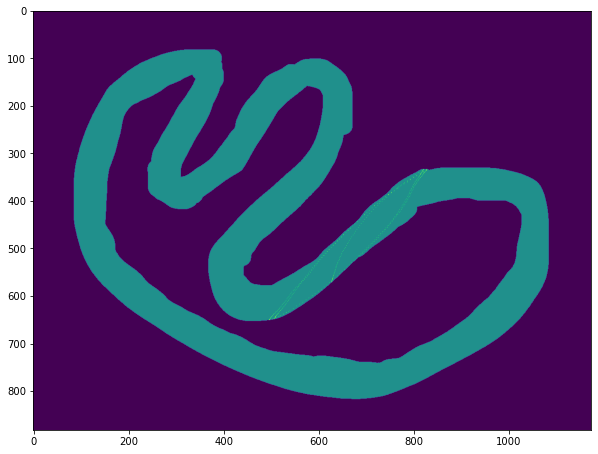

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 4s 9ms/sample - loss: 9.2048 - val_loss: 2.9083
Epoch 2/5
450/450 [==============================] - 4s 9ms/sample - loss: 4.2757 - val_loss: 2.4514
Epoch 3/5
450/450 [==============================] - 4s 10ms/sample - loss: 4.1779 - val_loss: 1.8883
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.1465 - val_loss: 2.4290
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.0610 - val_loss: 1.6667


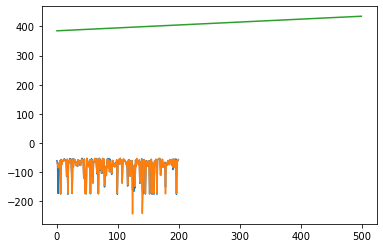

Unique speed values are: [ 0.          1.25        1.41421356  1.41421356  1.5         1.66421356
  2.41421356  2.66421356  3.41421356  3.66421356  4.41421356  4.66421356
  5.41421356  5.66421356  6.41421356  6.66421356  7.16421356  7.41421356
  7.91421356  8.          8.16421356  8.41421356  8.91421356  9.16421356
  9.41421356  9.91421356 10.16421356 10.16421356 10.91421356 11.16421356
 11.25       11.91421356 12.16421356 12.91421356 13.16421356 13.91421356
 14.16421356 14.66421356 14.91421356 15.16421356 15.16421356 15.41421356
 15.91421356 16.         16.16421356 16.41421356 16.91421356 17.16421356
 17.41421356 17.91421356 18.16421356 18.41421356 18.91421356 19.16421356
 19.20185043 19.41421356 19.91421356 20.16421356 20.41421356 20.91421356
 21.16421356 21.41421356 21.66421356 21.91421356 22.16421356 22.41421356
 22.66421356 22.91421356 23.16421356 23.41421356 23.66421356 23.91421356
 24.         24.16421356 24.41421356 24.66421356 24.91421356 25.16421356
 25.41421356 25.66421356 2

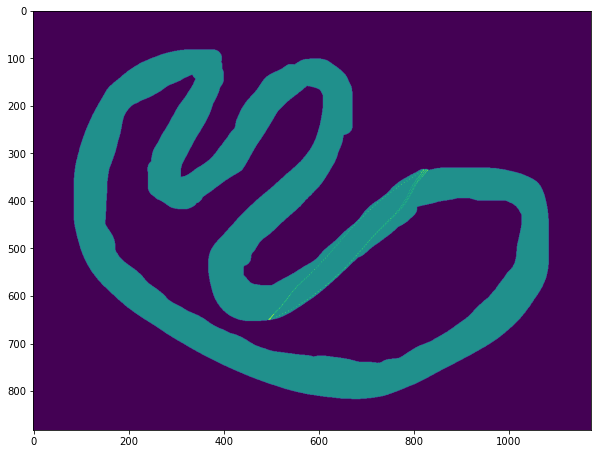

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.8595 - val_loss: 1.9365
Epoch 2/5
450/450 [==============================] - 4s 10ms/sample - loss: 2.3215 - val_loss: 1.9521
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.3270 - val_loss: 1.8503
Epoch 4/5
450/450 [==============================] - 6s 12ms/sample - loss: 2.1523 - val_loss: 2.1343
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.1122 - val_loss: 1.8381


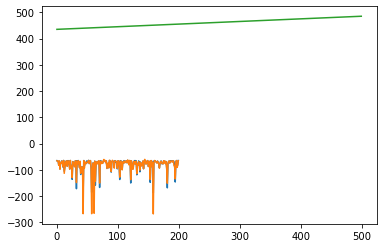

Unique speed values are: [ 0.          1.41421356  1.41421356  1.5         2.16421356  2.41421356
  3.16421356  3.41421356  3.66421356  4.16421356  4.41421356  4.66421356
  5.16421356  5.41421356  5.66421356  6.16421356  6.41421356  6.66421356
  7.16421356  7.41421356  7.66421356  7.91421356  8.16421356  8.41421356
  8.91421356  8.91421356  9.16421356  9.41421356  9.91421356  9.91421356
 10.16421356 10.16421356 10.41421356 10.91421356 11.16421356 11.41421356
 11.91421356 11.91421356 12.16421356 12.41421356 12.66421356 12.91421356
 13.16421356 13.41421356 13.66421356 14.16421356 14.41421356 14.66421356
 14.66421356 15.16421356 15.41421356 15.66421356 16.16421356 16.41421356
 16.66421356 17.16421356 17.41421356 17.66421356 18.16421356 18.41421356
 18.66421356 19.16421356 19.41421356 19.66421356 19.91421356 20.16421356
 20.41421356 20.66421356 21.16421356 21.41421356 21.66421356 21.66421356
 22.16421356 22.41421356 22.66421356 23.16421356 23.41421356 23.66421356
 23.91421356 24.16421356 2

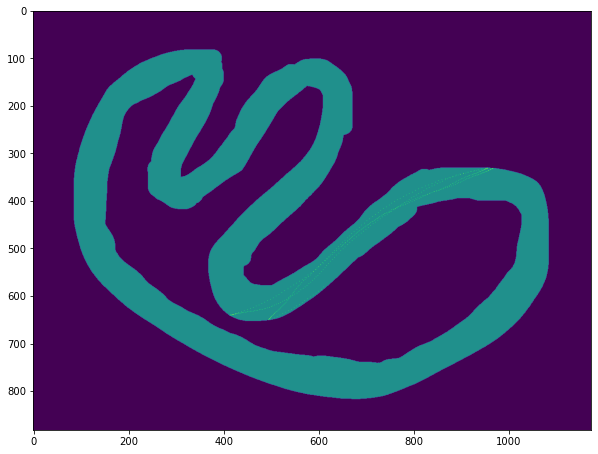

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 10ms/sample - loss: 2.5301 - val_loss: 1.6629
Epoch 2/5
450/450 [==============================] - 5s 11ms/sample - loss: 1.9494 - val_loss: 1.3280
Epoch 3/5
450/450 [==============================] - 4s 10ms/sample - loss: 1.9499 - val_loss: 1.2853
Epoch 4/5
450/450 [==============================] - 4s 10ms/sample - loss: 1.8787 - val_loss: 1.3674
Epoch 5/5
450/450 [==============================] - 4s 10ms/sample - loss: 1.7886 - val_loss: 1.8367


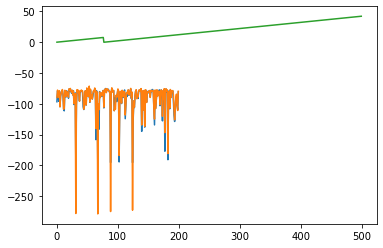

Unique speed values are: [ 0.          1.41421356  1.41421356  1.41421356  1.66421356  2.41421356
  2.41421356  2.66421356  2.91421356  3.41421356  3.91421356  4.41421356
  4.66421356  4.91421356  5.41421356  5.66421356  5.91421356  6.41421356
  6.66421356  6.91421356  7.41421356  7.66421356  7.66421356  7.91421356
  8.41421356  8.66421356  8.91421356  9.41421356  9.66421356  9.91421356
 10.41421356 10.66421356 10.91421356 11.16421356 11.16421356 11.41421356
 11.66421356 11.91421356 12.16421356 12.41421356 12.66421356 12.91421356
 13.16421356 13.41421356 13.66421356 13.91421356 14.16421356 14.41421356
 14.66421356 14.66421356 14.91421356 15.16421356 15.41421356 15.66421356
 15.91421356 16.16421356 16.41421356 16.66421356 16.91421356 17.16421356
 17.41421356 17.66421356 17.66421356 17.91421356 18.16421356 18.41421356
 18.91421356 19.16421356 19.41421356 19.91421356 20.16421356 20.41421356
 20.91421356 21.16421356 21.41421356 21.91421356 22.16421356 22.41421356
 22.66421356 22.91421356 2

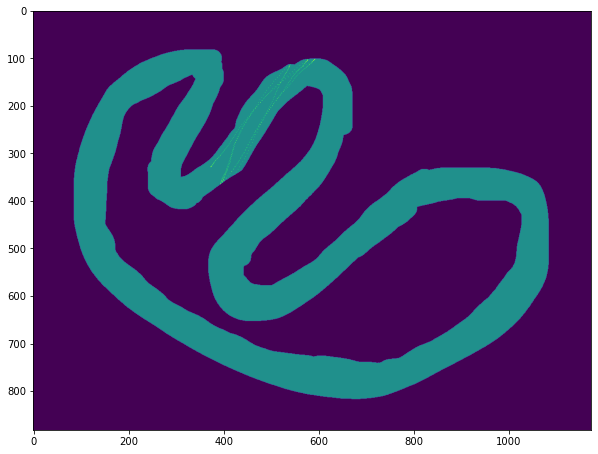

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 4s 9ms/sample - loss: 5.1805 - val_loss: 5.0374
Epoch 2/5
450/450 [==============================] - 4s 9ms/sample - loss: 4.7305 - val_loss: 5.2009
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.3452 - val_loss: 5.0799
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 4.0959 - val_loss: 4.9274
Epoch 5/5
450/450 [==============================] - 3s 8ms/sample - loss: 4.0967 - val_loss: 5.5909


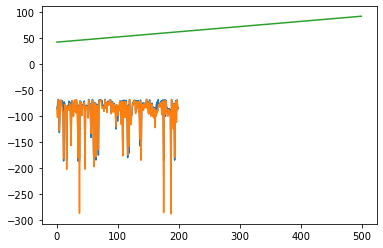

Unique speed values are: [ 0.          1.41421356  1.41421356  1.41421356  1.66421356  2.41421356
  2.41421356  2.66421356  3.41421356  3.41421356  3.41421356  4.41421356
  4.41421356  4.66421356  4.91421356  5.16421356  5.41421356  5.41421356
  6.16421356  6.41421356  6.41421356  6.66421356  7.16421356  7.41421356
  7.41421356  7.66421356  8.16421356  8.41421356  8.41421356  8.66421356
  9.16421356  9.41421356  9.41421356  9.66421356  9.66421356 10.16421356
 10.41421356 10.41421356 10.66421356 10.91421356 11.16421356 11.41421356
 11.41421356 11.66421356 12.16421356 12.41421356 12.41421356 12.66421356
 13.16421356 13.41421356 13.41421356 13.66421356 13.91421356 14.16421356
 14.41421356 14.41421356 14.66421356 14.91421356 15.16421356 15.41421356
 15.41421356 15.66421356 15.66421356 16.16421356 16.41421356 16.41421356
 16.66421356 16.66421356 17.16421356 17.41421356 17.66421356 18.16421356
 18.41421356 18.66421356 19.16421356 19.41421356 19.66421356 20.16421356
 20.16421356 20.41421356 2

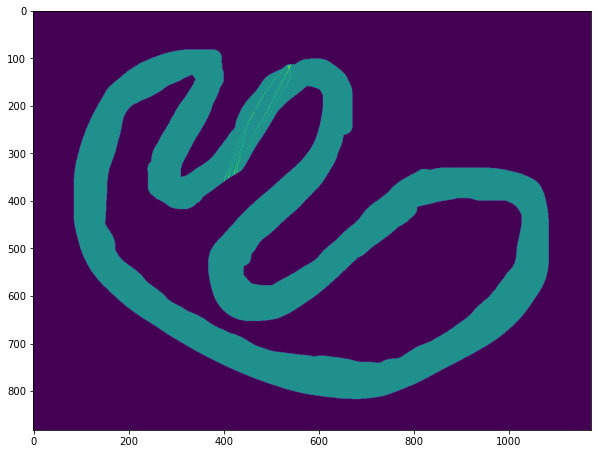

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 3s 7ms/sample - loss: 2.6130 - val_loss: 1.6051
Epoch 2/5
450/450 [==============================] - 3s 8ms/sample - loss: 2.4514 - val_loss: 1.2838
Epoch 3/5
450/450 [==============================] - 4s 9ms/sample - loss: 2.4003 - val_loss: 1.3724
Epoch 4/5
450/450 [==============================] - 4s 8ms/sample - loss: 2.3579 - val_loss: 1.5744
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.3584 - val_loss: 1.3921


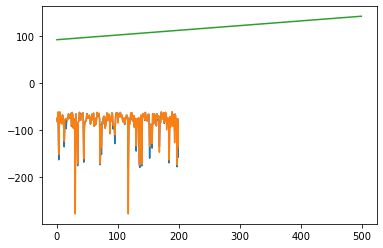

Unique speed values are: [ 0.          1.41421356  1.41421356  1.41421356  1.66421356  2.41421356
  2.41421356  2.66421356  3.16421356  3.41421356  3.41421356  3.41421356
  4.16421356  4.41421356  4.41421356  5.16421356  5.16421356  5.41421356
  5.41421356  6.16421356  6.16421356  6.41421356  6.41421356  6.66421356
  7.16421356  7.16421356  7.41421356  7.41421356  8.16421356  8.41421356
  9.16421356  9.41421356 10.16421356 10.41421356 11.16421356 11.41421356
 11.41421356 11.66421356 12.16421356 12.41421356 12.66421356 13.16421356
 13.41421356 13.41421356 13.66421356 13.66421356 14.16421356 14.41421356
 14.66421356 15.16421356 15.41421356 15.66421356 16.16421356 16.41421356
 16.66421356 16.91421356 17.16421356 17.41421356 17.66421356 17.91421356
 18.16421356 18.41421356 18.91421356 19.16421356 19.41421356 19.91421356
 20.16421356 20.41421356 20.66421356 20.66421356 20.91421356 21.16421356
 21.41421356 21.66421356 22.16421356 22.41421356 22.66421356 22.66421356
 23.16421356 23.41421356 2

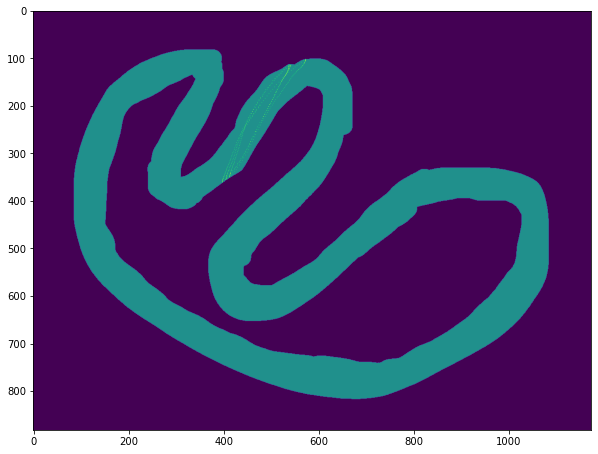

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 4s 9ms/sample - loss: 2.0715 - val_loss: 2.7779
Epoch 2/5
450/450 [==============================] - 4s 10ms/sample - loss: 1.7890 - val_loss: 2.8611
Epoch 3/5
450/450 [==============================] - 5s 12ms/sample - loss: 1.8730 - val_loss: 2.5803
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 1.9409 - val_loss: 2.7899
Epoch 5/5
450/450 [==============================] - 4s 10ms/sample - loss: 1.9175 - val_loss: 2.7260


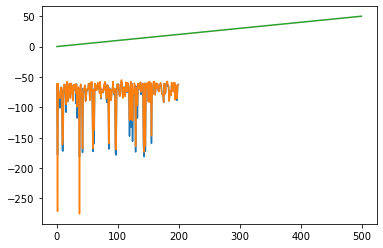

Unique speed values are: [ 0.          1.20185043  1.41421356  1.41421356  1.41421356  1.66421356
  2.20185043  2.41421356  3.20185043  3.41421356  4.20185043  4.41421356
  5.20185043  5.41421356  6.16421356  6.20185043  6.41421356  7.20185043
  7.41421356  8.16421356  8.20185043  8.41421356  8.41421356  9.20185043
  9.41421356  9.41421356 10.20185043 10.41421356 10.41421356 10.66421356
 11.16421356 11.20185043 11.41421356 11.41421356 11.66421356 12.20185043
 12.41421356 12.66421356 13.20185043 13.41421356 13.66421356 14.20185043
 14.41421356 14.66421356 14.66421356 15.20185043 15.41421356 15.66421356
 16.20185043 16.41421356 16.66421356 16.91421356 17.20185043 17.25
 17.41421356 17.5        17.66421356 17.66421356 17.75       17.91421356
 18.         18.20185043 18.25       18.41421356 18.41421356 18.5
 18.91421356 19.         19.20185043 19.25       19.41421356 19.41421356
 19.5        19.75       20.20185043 20.41421356 20.41421356 20.5
 21.16421356 21.20185043 21.41421356 21.414213

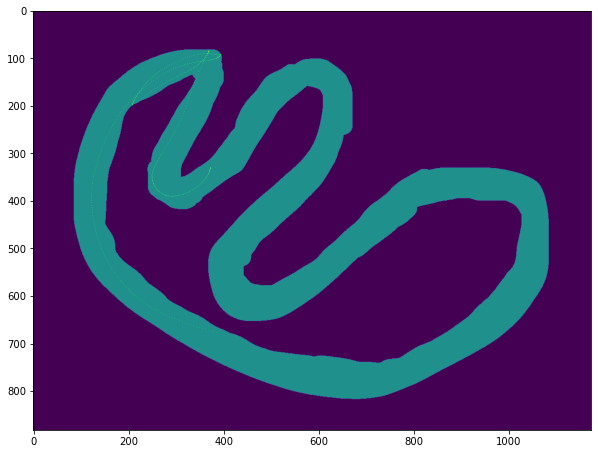

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.9010 - val_loss: 3.7864
Epoch 2/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.8617 - val_loss: 3.7599
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.6672 - val_loss: 3.6277
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.7098 - val_loss: 4.2126
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 3.5228 - val_loss: 3.4795


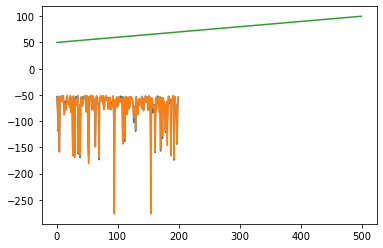

Unique speed values are: [ 0.          1.20185043  1.41421356  1.45185043  2.41421356  2.45185043
  2.70185043  2.95185043  3.41421356  3.45185043  3.70185043  4.41421356
  4.70185043  5.20185043  5.41421356  5.70185043  5.95185043  6.16421356
  6.41421356  6.66421356  6.95185043  7.66421356  7.95185043  8.16421356
  8.66421356  8.95185043  9.16421356  9.66421356  9.95185043 10.66421356
 10.95185043 11.41421356 11.41421356 11.66421356 11.95185043 12.66421356
 12.95185043 13.66421356 13.95185043 14.66421356 14.95185043 15.41421356
 15.95185043 16.41421356 16.41421356 16.95185043 17.41421356 17.66421356
 17.75       17.91421356 17.95185043 18.41421356 18.41421356 18.5
 18.66421356 18.91421356 18.95185043 19.16421356 19.25       19.41421356
 19.41421356 19.91421356 19.95185043 20.16421356 20.41421356 20.41421356
 20.66421356 20.91421356 20.95185043 21.16421356 21.41421356 21.5
 21.66421356 21.91421356 21.95185043 22.16421356 22.41421356 22.41421356
 22.91421356 22.95185043 23.16421356 23.

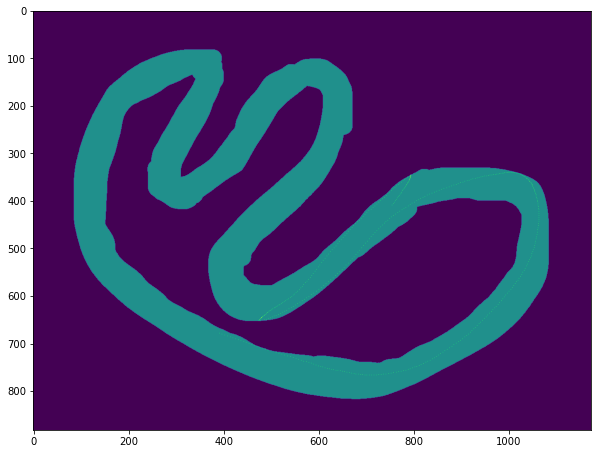

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.9169 - val_loss: 4.3980
Epoch 2/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.7197 - val_loss: 4.0150
Epoch 3/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.7052 - val_loss: 3.6504
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.4776 - val_loss: 4.4798
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.5838 - val_loss: 4.1859


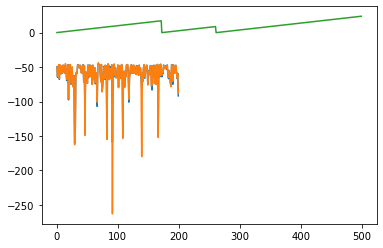

Unique speed values are: [ 0.          1.41421356  1.41421356  2.41421356  2.45185043  3.41421356
  3.70185043  4.41421356  5.41421356  6.41421356  7.41421356  8.16421356
  8.41421356  8.41421356  8.66421356  9.41421356  9.66421356  9.66421356
 10.41421356 10.66421356 10.66421356 11.41421356 11.66421356 11.66421356
 12.66421356 12.66421356 13.20185043 13.66421356 13.66421356 13.70185043
 13.95185043 14.45185043 14.66421356 14.66421356 14.70185043 15.20185043
 15.45185043 15.66421356 15.66421356 15.70185043 16.20185043 16.45185043
 16.66421356 16.66421356 16.70185043 17.20185043 17.66421356 17.66421356
 17.70185043 17.75       17.91421356 18.20185043 18.66421356 18.66421356
 18.70185043 19.20185043 19.41421356 19.41421356 19.45185043 19.66421356
 19.66421356 19.70185043 19.95185043 20.41421356 20.45185043 20.66421356
 20.66421356 20.70185043 20.95185043 21.41421356 21.66421356 21.66421356
 21.70185043 21.91421356 22.20185043 22.41421356 22.66421356 22.66421356
 22.70185043 22.91421356 2

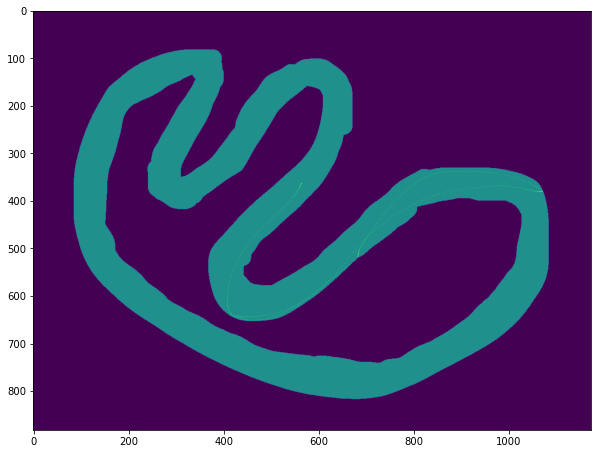

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 4s 9ms/sample - loss: 3.1565 - val_loss: 0.8380
Epoch 2/5
450/450 [==============================] - 3s 7ms/sample - loss: 2.6530 - val_loss: 0.8516
Epoch 3/5
450/450 [==============================] - 3s 7ms/sample - loss: 2.7871 - val_loss: 1.2445
Epoch 4/5
450/450 [==============================] - 3s 7ms/sample - loss: 2.7359 - val_loss: 0.7443
Epoch 5/5
450/450 [==============================] - 4s 9ms/sample - loss: 2.5778 - val_loss: 0.7668


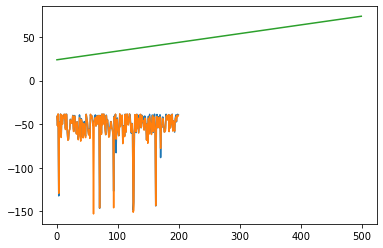

Unique speed values are: [ 0.          1.05409255  1.41421356  1.80409255  2.41421356  2.80409255
  3.05409255  3.41421356  3.80409255  4.05409255  4.41421356  4.55409255
  5.41421356  5.55409255  6.41421356  6.55409255  7.41421356  7.55409255
  8.16421356  8.41421356  8.55409255  9.16421356  9.55409255  9.66421356
 10.16421356 10.55409255 11.16421356 11.41421356 11.55409255 12.16421356
 12.55409255 13.16421356 13.55409255 13.91421356 14.55409255 14.66421356
 15.41421356 15.55409255 15.66421356 15.91421356 16.55409255 16.91421356
 17.55409255 17.91421356 18.41421356 18.55409255 18.66421356 19.41421356
 19.55409255 19.66421356 19.95185043 20.41421356 20.55409255 20.66421356
 21.41421356 21.55409255 21.91421356 22.41421356 22.55409255 22.66421356
 22.66421356 22.91421356 23.16421356 23.41421356 23.55409255 23.66421356
 24.16421356 24.41421356 24.55409255 24.66421356 24.66421356 24.91421356
 25.16421356 25.41421356 25.41421356 25.55409255 25.66421356 25.91421356
 26.16421356 26.41421356 2

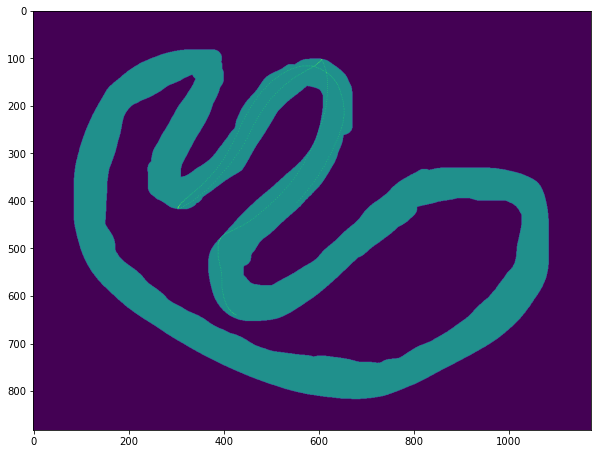

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 5s 12ms/sample - loss: 2.4309 - val_loss: 5.5100
Epoch 2/5
450/450 [==============================] - 5s 12ms/sample - loss: 2.1270 - val_loss: 5.5237
Epoch 3/5
450/450 [==============================] - 5s 12ms/sample - loss: 2.1211 - val_loss: 5.3516
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.0155 - val_loss: 5.6191
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 1.9565 - val_loss: 5.4506


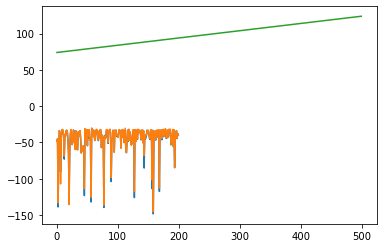

Unique speed values are: [ 0.          1.05409255  1.25        1.41421356  2.25        2.41421356
  3.25        3.41421356  4.25        4.41421356  5.25        5.41421356
  5.55409255  6.25        6.41421356  7.25        7.41421356  8.25
  8.41421356  9.25        9.41421356  9.66421356 10.16421356 10.25
 10.41421356 11.25       11.41421356 12.25       12.41421356 12.55409255
 13.25       13.41421356 13.55409255 14.25       14.41421356 15.16421356
 15.25       15.55409255 16.16421356 16.25       17.16421356 17.25
 18.16421356 18.25       19.16421356 19.25       20.16421356 20.25
 21.16421356 21.25       22.16421356 22.25       22.66421356 23.16421356
 23.16421356 23.25       24.16421356 24.25       24.66421356 25.16421356
 25.25       25.66421356 25.91421356 26.16421356 26.16421356 26.25
 26.41421356 26.41421356 26.66421356 26.91421356 27.16421356 27.16421356
 27.25       27.41421356 27.66421356 28.16421356 28.16421356 28.25
 28.41421356 28.66421356 28.66421356 29.16421356 29.16421356 2

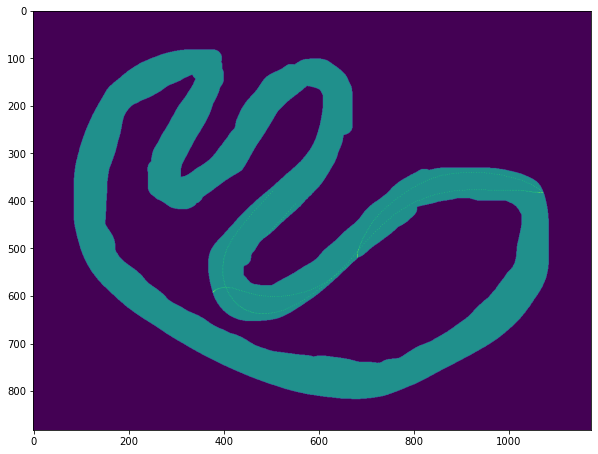

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 4s 9ms/sample - loss: 2.6337 - val_loss: 2.0986
Epoch 2/5
450/450 [==============================] - 5s 12ms/sample - loss: 2.3730 - val_loss: 3.3040
Epoch 3/5
450/450 [==============================] - 6s 12ms/sample - loss: 2.2923 - val_loss: 2.5844
Epoch 4/5
450/450 [==============================] - 5s 12ms/sample - loss: 2.3233 - val_loss: 2.3841
Epoch 5/5
450/450 [==============================] - 5s 12ms/sample - loss: 2.2492 - val_loss: 2.5696
Zero Movement recorded. Speed is:  0.0  sampling_frequency is:  10.0


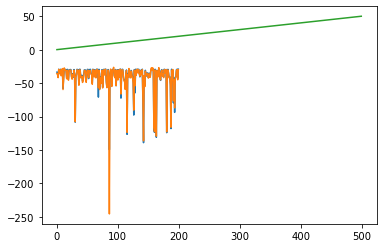

Unique speed values are: [ 0.          1.03077641  1.05409255  1.41421356  2.03077641  2.41421356
  3.03077641  3.41421356  4.03077641  4.25        4.41421356  5.03077641
  5.41421356  6.03077641  6.41421356  6.41421356  7.03077641  7.41421356
  8.03077641  8.41421356  9.03077641  9.25        9.41421356  9.66421356
 10.03077641 10.41421356 11.03077641 11.41421356 11.5        12.03077641
 12.41421356 12.5        13.         13.03077641 13.41421356 14.
 14.03077641 14.41421356 14.53077641 15.         15.41421356 15.53077641
 15.75       16.25       16.41421356 16.53077641 16.75       17.41421356
 17.5        17.53077641 18.25       18.41421356 18.53077641 19.25
 19.41421356 19.53077641 19.75       20.16421356 20.25       20.41421356
 20.53077641 21.         21.41421356 21.53077641 21.75       22.16421356
 22.41421356 22.5        22.53077641 23.16421356 23.25       23.41421356
 23.53077641 23.66421356 24.         24.16421356 24.25       24.41421356
 24.53077641 24.75       25.16421356 25.

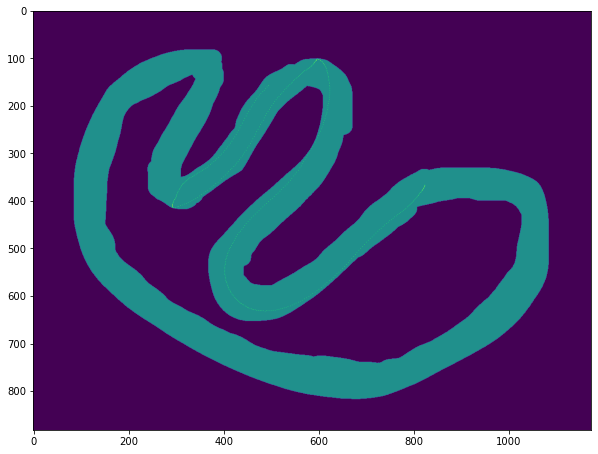

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 4s 10ms/sample - loss: 2.4095 - val_loss: 6.1378
Epoch 2/5
450/450 [==============================] - 4s 10ms/sample - loss: 2.1781 - val_loss: 6.1077
Epoch 3/5
450/450 [==============================] - 4s 8ms/sample - loss: 2.0811 - val_loss: 5.8707
Epoch 4/5
450/450 [==============================] - 4s 9ms/sample - loss: 2.1240 - val_loss: 5.9961
Epoch 5/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.0382 - val_loss: 6.3400


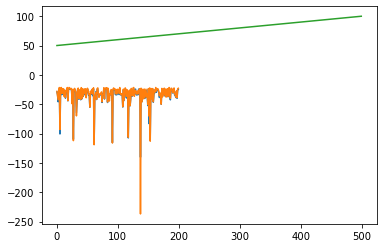

Unique speed values are: [ 0.          1.03077641  1.05409255  1.11803399  1.41421356  2.11803399
  2.41421356  2.41421356  2.66421356  2.91421356  3.11803399  3.66421356
  3.91421356  4.11803399  4.25        4.66421356  4.91421356  5.03077641
  5.11803399  5.66421356  5.91421356  6.11803399  6.66421356  6.91421356
  7.11803399  7.66421356  7.91421356  8.11803399  8.66421356  8.91421356
  9.11803399  9.66421356  9.91421356 10.11803399 10.66421356 10.91421356
 11.11803399 11.41421356 11.66421356 11.91421356 12.11803399 12.66421356
 12.91421356 13.         13.11803399 13.66421356 13.91421356 14.11803399
 14.66421356 14.91421356 15.         15.11803399 15.16421356 15.41421356
 15.91421356 16.11803399 16.16421356 16.75       16.91421356 17.11803399
 17.16421356 17.41421356 17.91421356 18.11803399 18.16421356 18.91421356
 19.11803399 19.16421356 19.91421356 20.11803399 20.16421356 20.91421356
 21.11803399 21.16421356 21.75       21.91421356 22.11803399 22.16421356
 22.16421356 22.5        2

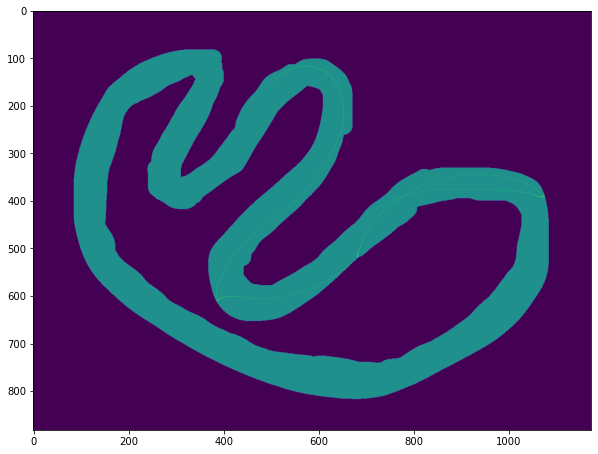

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 4s 9ms/sample - loss: 2.3045 - val_loss: 1.3554
Epoch 2/5
450/450 [==============================] - 4s 10ms/sample - loss: 2.1402 - val_loss: 0.8199
Epoch 3/5
450/450 [==============================] - 4s 9ms/sample - loss: 2.1152 - val_loss: 0.8138
Epoch 4/5
450/450 [==============================] - 5s 12ms/sample - loss: 2.0273 - val_loss: 1.1551
Epoch 5/5
450/450 [==============================] - 5s 12ms/sample - loss: 2.0429 - val_loss: 1.3125


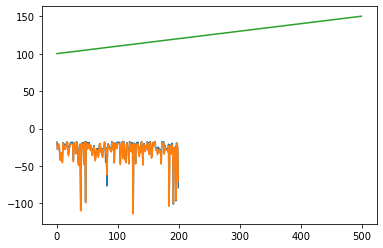

Unique speed values are: [ 0.          1.11803399  1.41421356  1.41421356  2.41421356  3.41421356
  4.41421356  5.11803399  5.41421356  6.41421356  6.66421356  7.41421356
  7.91421356  8.11803399  8.16421356  8.41421356  9.16421356  9.41421356
 10.16421356 10.41421356 11.16421356 11.41421356 12.16421356 12.41421356
 12.66421356 13.16421356 13.41421356 13.66421356 14.05409255 14.16421356
 14.41421356 14.66421356 15.         15.05409255 15.16421356 15.41421356
 15.66421356 15.91421356 16.05409255 16.16421356 16.41421356 16.55409255
 16.66421356 17.05409255 17.11803399 17.16421356 17.41421356 17.55409255
 17.91421356 18.05409255 18.16421356 18.41421356 18.55409255 18.80409255
 18.91421356 19.11803399 19.16421356 19.41421356 19.55409255 19.66421356
 19.80409255 19.91421356 20.11803399 20.16421356 20.41421356 20.55409255
 20.66421356 20.91421356 21.16421356 21.41421356 21.55409255 21.66421356
 21.91421356 22.16421356 22.41421356 22.55409255 22.91421356 23.16421356
 23.41421356 23.55409255 2

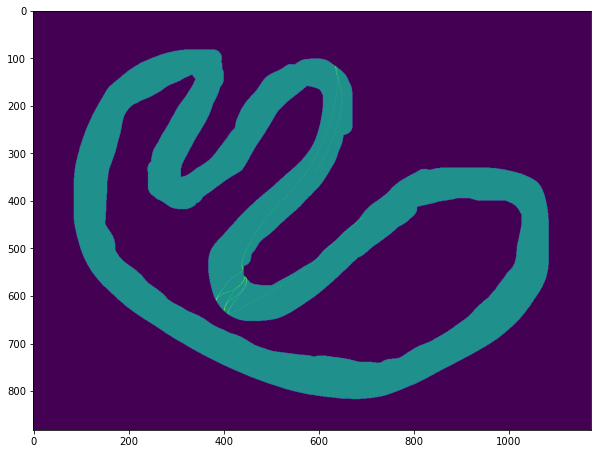

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 4s 8ms/sample - loss: 3.4718 - val_loss: 2.1029
Epoch 2/5
450/450 [==============================] - 4s 9ms/sample - loss: 3.0172 - val_loss: 1.0446
Epoch 3/5
450/450 [==============================] - 3s 8ms/sample - loss: 2.9751 - val_loss: 1.1613
Epoch 4/5
450/450 [==============================] - 5s 11ms/sample - loss: 2.8552 - val_loss: 1.2874
Epoch 5/5
450/450 [==============================] - 5s 12ms/sample - loss: 2.9312 - val_loss: 1.4352


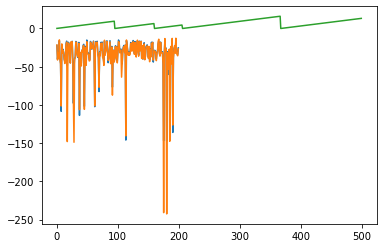

Unique speed values are: [ 0.          1.20185043  1.41421356  1.66421356  2.20185043  2.41421356
  2.45185043  2.66421356  3.41421356  3.45185043  3.66421356  4.20185043
  4.41421356  4.45185043  4.66421356  4.95185043  5.41421356  5.45185043
  5.66421356  6.41421356  6.45185043  6.66421356  7.41421356  7.45185043
  7.66421356  8.41421356  8.45185043  8.66421356  9.16421356  9.41421356
  9.45185043  9.66421356 10.41421356 10.45185043 10.66421356 11.20185043
 11.41421356 11.45185043 11.66421356 12.20185043 12.41421356 12.66421356
 13.20185043 13.41421356 13.66421356 13.95185043 14.16421356 14.41421356
 14.45185043 14.66421356 15.41421356 15.45185043 15.66421356 15.91421356
 16.41421356 16.45185043 16.66421356 16.91421356 17.11803399 17.16421356
 17.41421356 17.45185043 17.91421356 18.16421356 18.41421356 18.45185043
 18.66421356 18.80409255 18.91421356 19.41421356 19.45185043 19.55409255
 19.66421356 19.91421356 20.41421356 20.45185043 20.91421356 21.41421356
 21.45185043 21.55409255 2

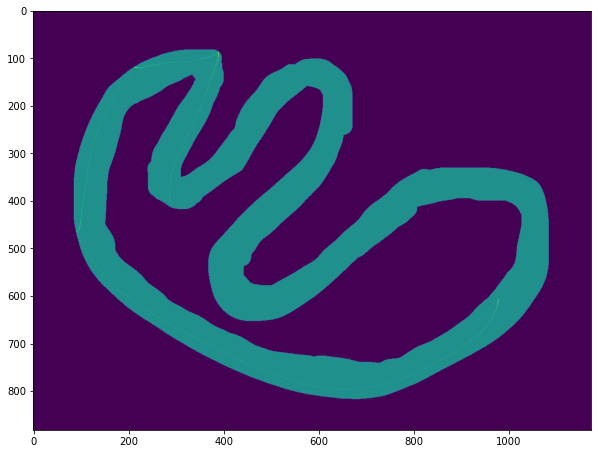

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.9849 - val_loss: 4.5746
Epoch 2/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.4212 - val_loss: 4.3569
Epoch 3/5
450/450 [==============================] - 2s 4ms/sample - loss: 2.2419 - val_loss: 4.0649
Epoch 4/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.0945 - val_loss: 3.6507
Epoch 5/5
450/450 [==============================] - 2s 4ms/sample - loss: 2.0403 - val_loss: 4.4070


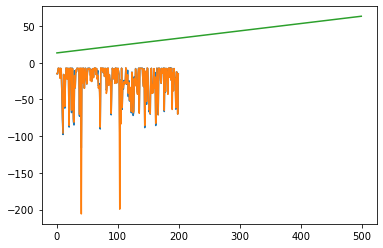

Unique speed values are: [ 0.          1.20185043  1.41421356  1.41421356  1.41421356  2.41421356
  2.41421356  2.91421356  3.41421356  3.41421356  3.66421356  3.91421356
  4.16421356  4.41421356  4.41421356  4.45185043  4.66421356  4.91421356
  5.41421356  5.41421356  5.66421356  5.91421356  6.41421356  6.41421356
  6.66421356  6.91421356  7.41421356  7.41421356  7.66421356  7.91421356
  8.41421356  8.45185043  8.66421356  8.66421356  9.16421356  9.41421356
  9.45185043  9.66421356  9.91421356 10.16421356 10.16421356 10.41421356
 10.66421356 10.66421356 11.16421356 11.16421356 11.41421356 11.66421356
 11.91421356 12.16421356 12.16421356 12.41421356 12.66421356 12.91421356
 13.16421356 13.16421356 13.41421356 13.66421356 14.16421356 14.16421356
 14.41421356 14.66421356 15.16421356 15.16421356 15.41421356 15.66421356
 16.16421356 16.16421356 16.41421356 16.66421356 17.16421356 17.16421356
 17.41421356 17.66421356 18.16421356 18.16421356 18.41421356 18.66421356
 18.80409255 19.16421356 1

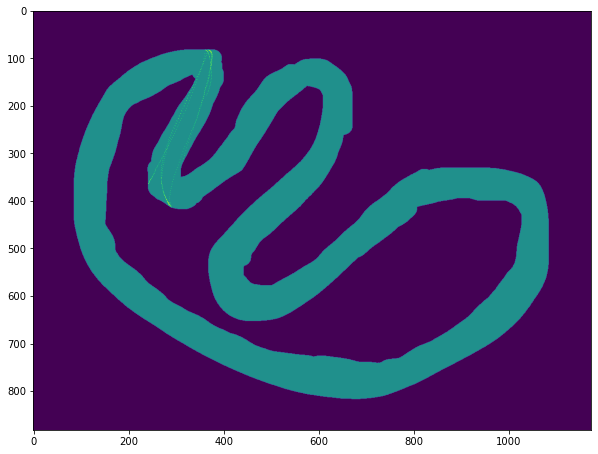

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 1s 3ms/sample - loss: 4.3679 - val_loss: 7.6401
Epoch 2/5
450/450 [==============================] - 1s 3ms/sample - loss: 4.0704 - val_loss: 7.5857
Epoch 3/5
450/450 [==============================] - 1s 3ms/sample - loss: 3.9962 - val_loss: 7.4672
Epoch 4/5
450/450 [==============================] - 1s 3ms/sample - loss: 3.9355 - val_loss: 7.8745
Epoch 5/5
450/450 [==============================] - 1s 3ms/sample - loss: 3.7463 - val_loss: 7.7049


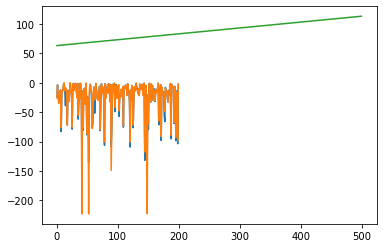

Unique speed values are: [ 0.          1.05409255  1.20185043  1.20185043  1.41421356  2.05409255
  2.20185043  2.41421356  2.41421356  3.05409255  3.20185043  3.41421356
  3.41421356  4.05409255  4.20185043  4.41421356  5.05409255  5.20185043
  5.41421356  5.91421356  6.05409255  6.20185043  6.41421356  7.05409255
  7.20185043  7.41421356  8.05409255  8.20185043  8.41421356  8.41421356
  9.05409255  9.20185043  9.41421356  9.41421356 10.05409255 10.20185043
 10.41421356 11.05409255 11.16421356 11.20185043 11.41421356 11.91421356
 12.05409255 12.20185043 12.41421356 12.91421356 13.05409255 13.20185043
 13.41421356 14.05409255 14.20185043 14.41421356 15.05409255 15.16421356
 15.20185043 15.41421356 16.05409255 16.20185043 16.41421356 17.05409255
 17.20185043 17.41421356 18.05409255 18.16421356 18.16421356 18.20185043
 18.41421356 18.55409255 18.66421356 19.05409255 19.16421356 19.20185043
 19.41421356 19.41421356 19.55409255 19.66421356 19.91421356 19.91421356
 20.05409255 20.16421356 2

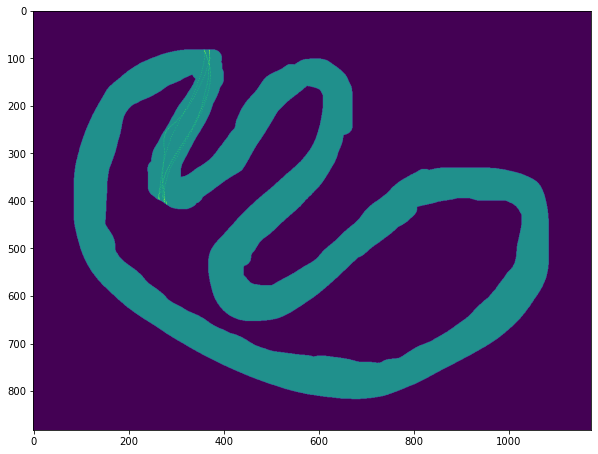

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 1s 3ms/sample - loss: 3.0640 - val_loss: 2.1651
Epoch 2/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.7870 - val_loss: 2.5739
Epoch 3/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.6277 - val_loss: 2.1943
Epoch 4/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.5860 - val_loss: 1.7720
Epoch 5/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.6903 - val_loss: 1.6777


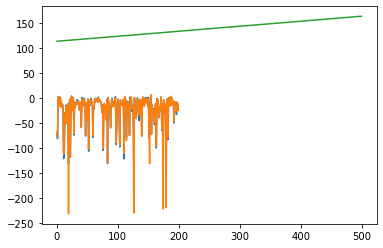

Unique speed values are: [ 0.          1.03077641  1.05409255  1.28077641  1.41421356  1.91421356
  2.05409255  2.28077641  2.41421356  2.41421356  2.91421356  3.05409255
  3.28077641  3.41421356  3.91421356  4.05409255  4.20185043  4.28077641
  4.41421356  4.91421356  5.05409255  5.28077641  5.41421356  5.91421356
  6.05409255  6.28077641  6.41421356  6.91421356  7.05409255  7.28077641
  7.41421356  7.91421356  8.03077641  8.05409255  8.41421356  8.91421356
  9.03077641  9.05409255  9.20185043  9.41421356  9.91421356 10.03077641
 10.05409255 10.05409255 10.41421356 10.91421356 11.03077641 11.05409255
 11.41421356 11.91421356 12.03077641 12.05409255 12.41421356 12.91421356
 13.03077641 13.05409255 13.41421356 13.91421356 14.03077641 14.05409255
 14.41421356 14.91421356 15.03077641 15.05409255 15.16421356 15.41421356
 15.91421356 16.05409255 16.41421356 16.91421356 17.05409255 17.16421356
 17.41421356 17.91421356 18.05409255 18.16421356 18.41421356 18.55409255
 18.91421356 19.05409255 1

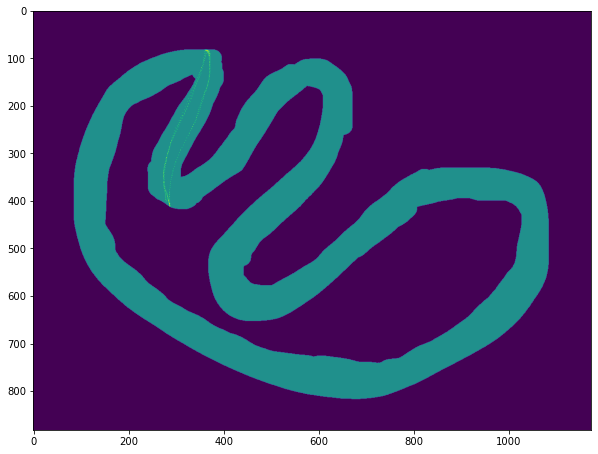

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 1s 3ms/sample - loss: 1.8941 - val_loss: 1.4354
Epoch 2/5
450/450 [==============================] - 1s 3ms/sample - loss: 1.7768 - val_loss: 1.9743
Epoch 3/5
450/450 [==============================] - 1s 3ms/sample - loss: 1.6874 - val_loss: 2.4736
Epoch 4/5
450/450 [==============================] - 1s 3ms/sample - loss: 1.7395 - val_loss: 1.6737
Epoch 5/5
450/450 [==============================] - 1s 3ms/sample - loss: 1.6479 - val_loss: 1.3987


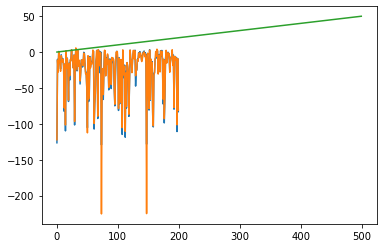

Unique speed values are: [ 0.          1.05409255  1.25        1.41421356  1.41421356  2.25
  2.41421356  3.25        3.41421356  4.05409255  4.11803399  4.25
  4.41421356  4.5         5.11803399  5.25        5.41421356  5.5
  5.91421356  6.11803399  6.28077641  6.41421356  6.5         6.91421356
  7.11803399  7.41421356  7.5         7.91421356  8.11803399  8.41421356
  8.5         9.11803399  9.20185043  9.41421356  9.5        10.03077641
 10.05409255 10.11803399 10.41421356 10.5        10.91421356 11.11803399
 11.41421356 11.5        12.11803399 12.41421356 12.5        12.91421356
 13.03077641 13.11803399 13.41421356 13.5        14.11803399 14.41421356
 14.5        15.11803399 15.41421356 15.5        16.05409255 16.11803399
 16.41421356 16.5        17.11803399 17.41421356 17.5        18.05409255
 18.11803399 18.41421356 18.5        19.11803399 19.41421356 19.5
 20.11803399 20.41421356 20.5        21.11803399 21.41421356 21.5
 22.11803399 22.41421356 22.5        23.11803399 23.4142135

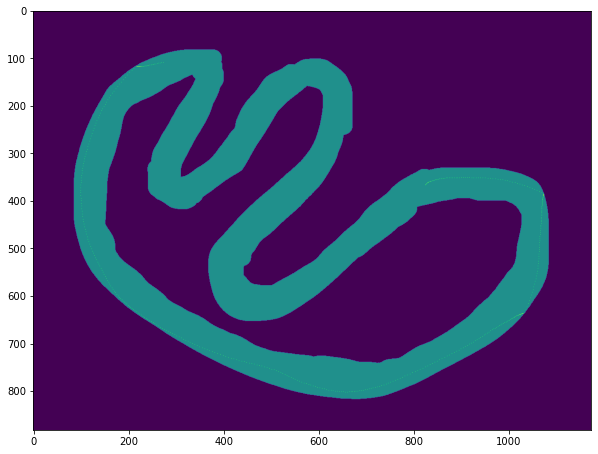

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.5415 - val_loss: 3.1287
Epoch 2/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.3307 - val_loss: 3.7924
Epoch 3/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.2485 - val_loss: 2.5652
Epoch 4/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.0894 - val_loss: 3.2636
Epoch 5/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.0337 - val_loss: 2.8274


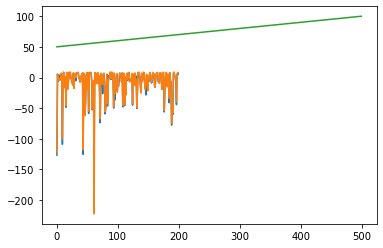

Unique speed values are: [ 0.          1.05409255  1.30409255  1.41421356  1.41421356  2.30409255
  2.41421356  3.30409255  3.41421356  4.25        4.30409255  4.41421356
  4.41421356  5.30409255  5.41421356  5.41421356  6.16421356  6.28077641
  6.30409255  6.41421356  6.41421356  7.16421356  7.30409255  7.41421356
  8.16421356  8.30409255  8.41421356  8.41421356  9.16421356  9.30409255
  9.41421356  9.41421356 10.16421356 10.30409255 10.41421356 10.41421356
 10.91421356 11.16421356 11.16421356 11.16421356 11.30409255 11.41421356
 11.41421356 12.16421356 12.16421356 12.16421356 12.30409255 12.41421356
 13.16421356 13.16421356 13.16421356 13.30409255 13.41421356 13.5
 14.16421356 14.16421356 14.16421356 14.30409255 14.41421356 14.5
 15.16421356 15.16421356 15.16421356 15.30409255 15.41421356 16.16421356
 16.16421356 16.16421356 16.30409255 16.41421356 16.66421356 16.80409255
 17.16421356 17.16421356 17.30409255 17.41421356 17.5        17.66421356
 17.80409255 18.16421356 18.16421356 18.

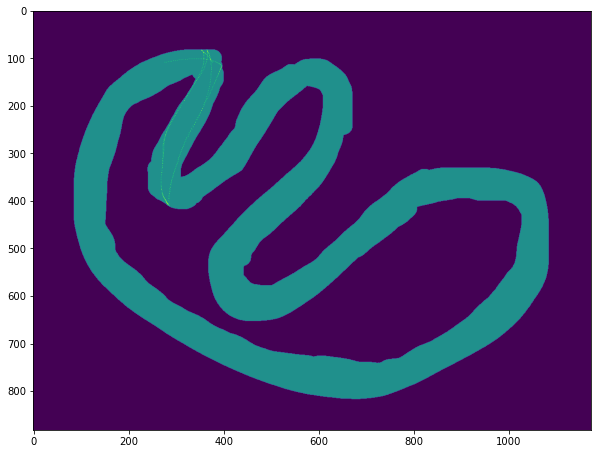

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 1s 3ms/sample - loss: 3.4414 - val_loss: 4.6744
Epoch 2/5
450/450 [==============================] - 1s 3ms/sample - loss: 3.1391 - val_loss: 4.7214
Epoch 3/5
450/450 [==============================] - 1s 3ms/sample - loss: 3.1178 - val_loss: 5.4121
Epoch 4/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.9736 - val_loss: 4.2754
Epoch 5/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.9084 - val_loss: 4.8515


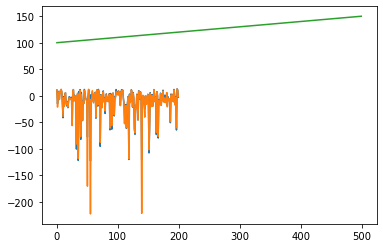

Unique speed values are: [ 0.          1.20185043  1.20185043  1.41421356  2.20185043  2.20185043
  2.41421356  3.20185043  3.20185043  4.20185043  4.20185043  4.41421356
  5.20185043  5.20185043  6.16421356  6.20185043  6.20185043  6.30409255
  7.20185043  7.20185043  7.41421356  8.20185043  8.20185043  8.41421356
  8.45185043  8.95185043  9.20185043  9.20185043  9.45185043  9.95185043
 10.20185043 10.20185043 10.45185043 11.16421356 11.20185043 11.20185043
 11.41421356 11.45185043 12.20185043 12.20185043 12.45185043 13.20185043
 13.20185043 13.45185043 14.16421356 14.20185043 14.20185043 14.41421356
 14.45185043 15.20185043 15.20185043 15.45185043 16.20185043 16.20185043
 16.45185043 16.80409255 17.16421356 17.20185043 17.20185043 17.45185043
 18.20185043 18.20185043 18.30409255 18.45185043 18.80409255 19.20185043
 19.20185043 19.45185043 19.45185043 19.80409255 20.16421356 20.20185043
 20.30409255 20.45185043 20.45185043 21.16421356 21.20185043 21.30409255
 21.45185043 21.45185043 2

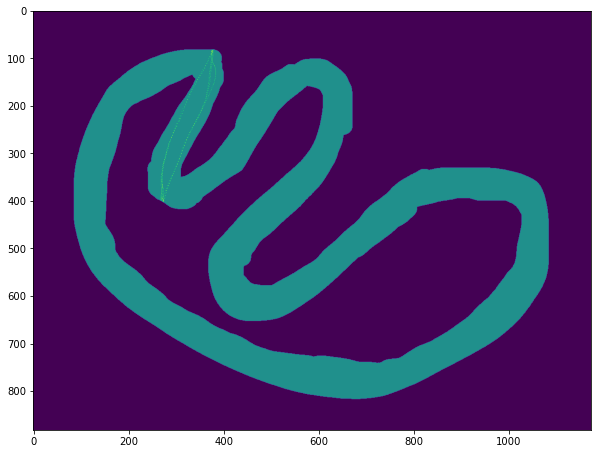

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.4547 - val_loss: 1.7056
Epoch 2/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.3199 - val_loss: 1.9534
Epoch 3/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.1759 - val_loss: 1.7669
Epoch 4/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.1862 - val_loss: 1.6659
Epoch 5/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.1933 - val_loss: 1.8380


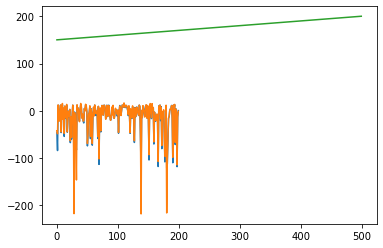

Unique speed values are: [ 0.          1.00346621  1.20185043  1.20185043  1.41421356  2.00346621
  2.20185043  2.41421356  3.00346621  3.20185043  3.41421356  4.00346621
  4.20185043  4.41421356  5.00346621  5.20185043  5.41421356  6.00346621
  6.20185043  6.41421356  7.00346621  7.20185043  7.41421356  8.00346621
  8.20185043  8.20185043  8.41421356  9.00346621  9.20185043  9.20185043
  9.41421356  9.70185043  9.95185043 10.00346621 10.20185043 10.20185043
 10.41421356 10.45185043 10.70185043 11.00346621 11.20185043 11.20185043
 11.41421356 11.45185043 11.70185043 12.00346621 12.20185043 12.20185043
 12.41421356 12.70185043 13.00346621 13.20185043 13.20185043 13.41421356
 13.70185043 14.00346621 14.20185043 14.20185043 14.41421356 14.45185043
 14.70185043 15.00346621 15.20185043 15.41421356 15.45185043 15.70185043
 15.95185043 16.00346621 16.20185043 16.41421356 16.70185043 16.95185043
 17.00346621 17.20185043 17.41421356 17.95185043 18.00346621 18.20185043
 18.30409255 18.41421356 1

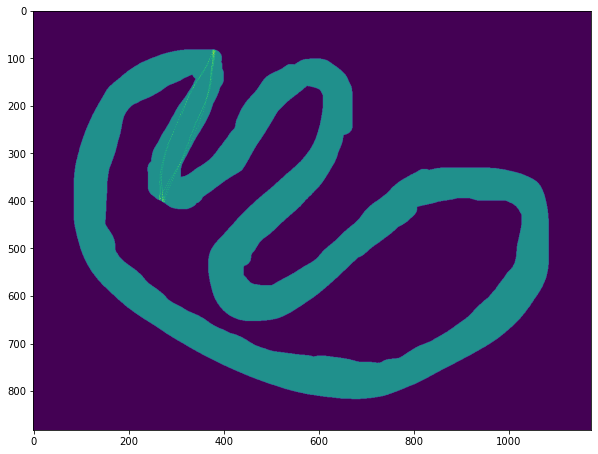

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 1s 3ms/sample - loss: 1.9427 - val_loss: 2.2620
Epoch 2/5
450/450 [==============================] - 1s 3ms/sample - loss: 1.7839 - val_loss: 2.4057
Epoch 3/5
450/450 [==============================] - 1s 3ms/sample - loss: 1.7473 - val_loss: 2.2128
Epoch 4/5
450/450 [==============================] - 1s 3ms/sample - loss: 1.7449 - val_loss: 2.7124
Epoch 5/5
450/450 [==============================] - 2s 3ms/sample - loss: 1.7411 - val_loss: 2.3110


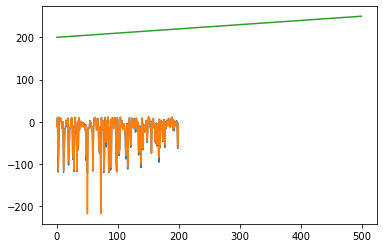

Unique speed values are: [ 0.          0.70185043  1.20185043  1.20185043  1.41421356  2.00346621
  2.20185043  2.41421356  3.20185043  3.41421356  4.20185043  4.41421356
  4.70185043  5.20185043  5.20185043  5.41421356  5.70185043  6.20185043
  6.20185043  6.41421356  6.66421356  6.70185043  7.20185043  7.20185043
  7.66421356  7.70185043  8.20185043  8.20185043  8.66421356  8.70185043
  9.00346621  9.20185043  9.66421356  9.70185043 10.20185043 10.66421356
 10.70185043 11.20185043 11.20185043 11.66421356 11.70185043 12.20185043
 12.41421356 12.66421356 12.70185043 13.20185043 13.20185043 13.66421356
 13.70185043 14.20185043 14.66421356 14.70185043 15.20185043 15.66421356
 15.70185043 16.20185043 16.66421356 16.70185043 17.20185043 17.66421356
 17.70185043 18.20185043 18.66421356 18.70185043 19.20185043 19.66421356
 19.70185043 19.80409255 20.20185043 20.66421356 20.70185043 21.20185043
 21.66421356 21.70185043 22.20185043 22.66421356 22.70185043 23.20185043
 23.66421356 23.70185043 2

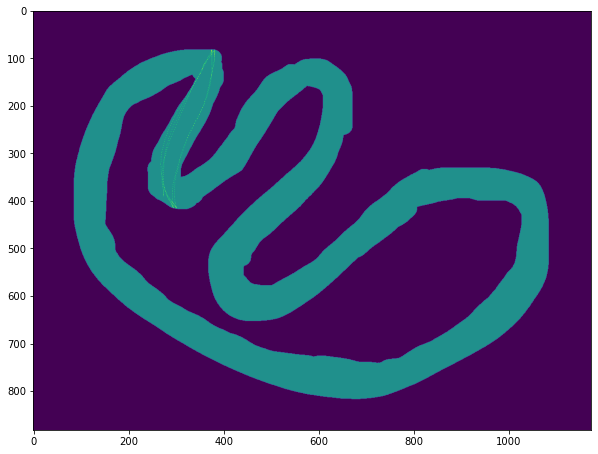

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 1s 3ms/sample - loss: 3.1375 - val_loss: 2.0481
Epoch 2/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.6415 - val_loss: 1.8420
Epoch 3/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.5040 - val_loss: 2.4897
Epoch 4/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.4836 - val_loss: 2.0011
Epoch 5/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.4847 - val_loss: 2.6475


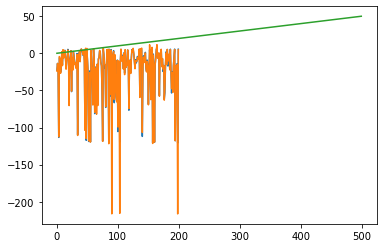

Unique speed values are: [ 0.          1.05409255  1.20185043  1.25        1.5         2.05409255
  2.20185043  2.5         3.05409255  3.20185043  3.5         4.05409255
  4.20185043  4.41421356  4.5         4.70185043  5.05409255  5.5
  5.70185043  6.05409255  6.20185043  6.5         6.70185043  7.05409255
  7.20185043  7.5         7.70185043  8.05409255  8.20185043  8.5
  8.66421356  9.05409255  9.20185043  9.5        10.05409255 10.20185043
 10.5        10.66421356 10.80409255 11.05409255 11.20185043 11.5
 11.80409255 12.05409255 12.20185043 12.30409255 12.5        12.70185043
 12.80409255 13.05409255 13.20185043 13.30409255 13.5        13.70185043
 13.80409255 14.20185043 14.30409255 14.5        14.66421356 14.80409255
 15.20185043 15.30409255 15.5        15.70185043 15.80409255 16.20185043
 16.30409255 16.5        16.80409255 17.20185043 17.30409255 17.5
 17.70185043 17.80409255 18.20185043 18.30409255 18.5        18.66421356
 18.80409255 18.91421356 19.05409255 19.16421356 19.20

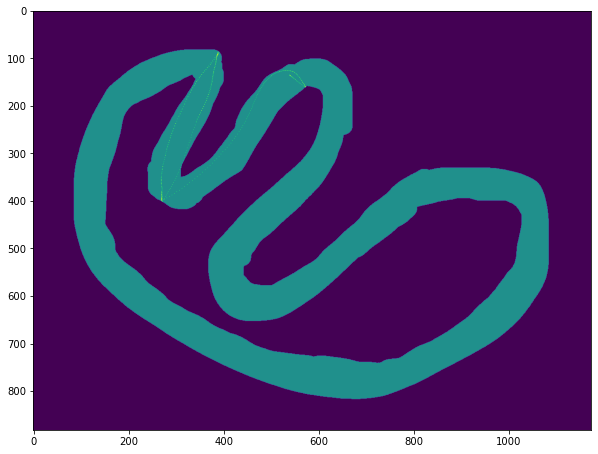

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.8633 - val_loss: 2.3358
Epoch 2/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.5842 - val_loss: 2.1496
Epoch 3/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.4806 - val_loss: 2.4525
Epoch 4/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.3952 - val_loss: 1.9783
Epoch 5/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.3433 - val_loss: 2.2618


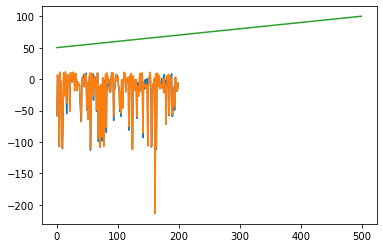

Unique speed values are: [ 0.          1.05409255  1.11803399  1.20185043  1.20185043  1.20185043
  1.25        1.36803399  2.20185043  2.20185043  2.36803399  2.5
  3.05409255  3.20185043  3.20185043  3.36803399  4.05409255  4.20185043
  4.20185043  4.36803399  4.5         4.70185043  5.05409255  5.20185043
  5.20185043  5.36803399  6.20185043  6.20185043  6.36803399  7.05409255
  7.20185043  7.20185043  7.36803399  8.05409255  8.20185043  8.20185043
  8.36803399  9.20185043  9.20185043  9.36803399 10.20185043 10.20185043
 10.36803399 10.5        11.20185043 11.20185043 11.36803399 12.05409255
 12.20185043 12.20185043 12.36803399 13.20185043 13.20185043 13.36803399
 14.20185043 14.20185043 14.30409255 14.36803399 14.95185043 15.20185043
 15.20185043 15.30409255 15.36803399 15.80409255 15.95185043 16.20185043
 16.20185043 16.36803399 16.95185043 17.20185043 17.20185043 17.36803399
 17.95185043 18.20185043 18.20185043 18.36803399 18.95185043 19.20185043
 19.20185043 19.36803399 19.95185

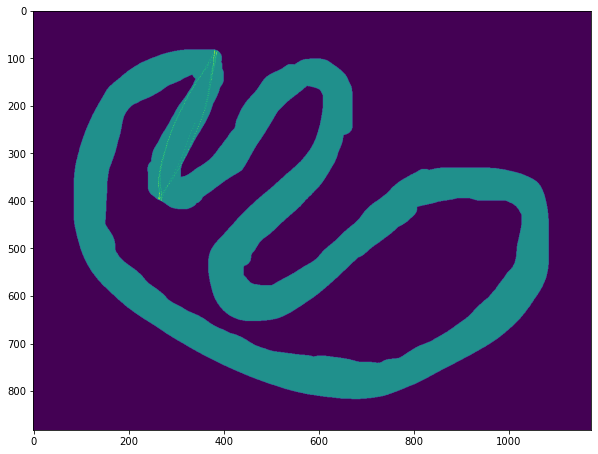

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 2s 3ms/sample - loss: 2.0106 - val_loss: 1.6923
Epoch 2/5
450/450 [==============================] - 2s 4ms/sample - loss: 1.7076 - val_loss: 1.6487
Epoch 3/5
450/450 [==============================] - 2s 4ms/sample - loss: 1.8228 - val_loss: 1.8884
Epoch 4/5
450/450 [==============================] - 2s 4ms/sample - loss: 1.6582 - val_loss: 1.3937
Epoch 5/5
450/450 [==============================] - 2s 4ms/sample - loss: 1.7005 - val_loss: 1.5687


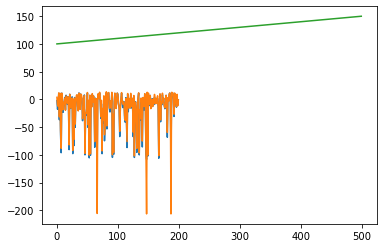

Unique speed values are: [ 0.          1.20185043  1.20185043  1.25        1.41421356  2.20185043
  2.20185043  2.41421356  3.20185043  3.20185043  3.41421356  3.45185043
  3.70185043  4.20185043  4.20185043  4.41421356  4.45185043  4.70185043
  5.20185043  5.20185043  5.41421356  5.45185043  5.70185043  6.20185043
  6.20185043  6.41421356  6.45185043  6.70185043  7.20185043  7.20185043
  7.41421356  7.45185043  7.70185043  8.05409255  8.20185043  8.20185043
  8.41421356  8.45185043  8.70185043  9.20185043  9.20185043  9.41421356
  9.45185043  9.70185043  9.95185043 10.20185043 10.41421356 10.45185043
 10.95185043 11.20185043 11.41421356 11.45185043 11.95185043 12.20185043
 12.36803399 12.41421356 12.45185043 12.95185043 13.20185043 13.36803399
 13.41421356 13.45185043 13.95185043 14.20185043 14.20185043 14.41421356
 14.45185043 14.95185043 15.20185043 15.30409255 15.41421356 15.45185043
 15.95185043 16.20185043 16.41421356 16.45185043 16.95185043 17.20185043
 17.41421356 17.45185043 1

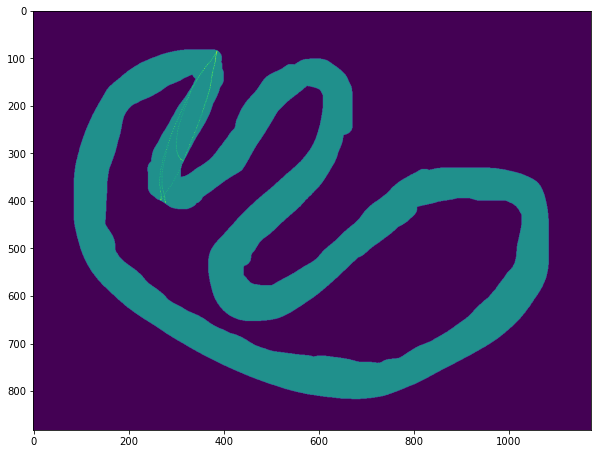

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 2s 4ms/sample - loss: 2.0680 - val_loss: 1.0498
Epoch 2/5
450/450 [==============================] - 2s 4ms/sample - loss: 1.8893 - val_loss: 1.2183
Epoch 3/5
450/450 [==============================] - 2s 4ms/sample - loss: 1.8697 - val_loss: 1.1161
Epoch 4/5
450/450 [==============================] - 2s 3ms/sample - loss: 1.8599 - val_loss: 1.0480
Epoch 5/5
450/450 [==============================] - 2s 4ms/sample - loss: 1.8597 - val_loss: 1.0580


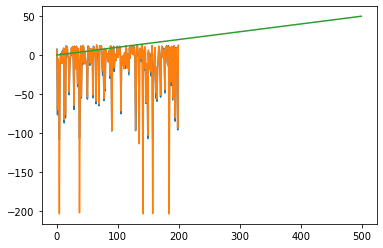

Unique speed values are: [ 0.          1.05409255  1.20185043  1.20185043  1.41421356  1.41421356
  2.05409255  2.20185043  2.41421356  3.05409255  3.05409255  3.20185043
  3.41421356  4.05409255  4.05409255  4.20185043  4.41421356  5.05409255
  5.05409255  5.20185043  5.41421356  5.45185043  6.05409255  6.05409255
  6.20185043  6.41421356  7.05409255  7.05409255  7.20185043  7.41421356
  7.45185043  8.05409255  8.20185043  8.41421356  9.05409255  9.20185043
  9.41421356 10.05409255 10.20185043 10.41421356 11.05409255 11.20185043
 11.41421356 12.05409255 12.20185043 12.36803399 12.41421356 12.45185043
 12.95185043 13.05409255 13.20185043 13.41421356 14.05409255 14.20185043
 14.41421356 14.45185043 15.05409255 15.20185043 15.41421356 15.66421356
 15.95185043 16.05409255 16.20185043 16.41421356 16.66421356 16.95185043
 17.05409255 17.20185043 17.41421356 17.66421356 18.05409255 18.20185043
 18.66421356 19.05409255 19.20185043 19.66421356 19.70185043 19.95185043
 19.95185043 20.05409255 2

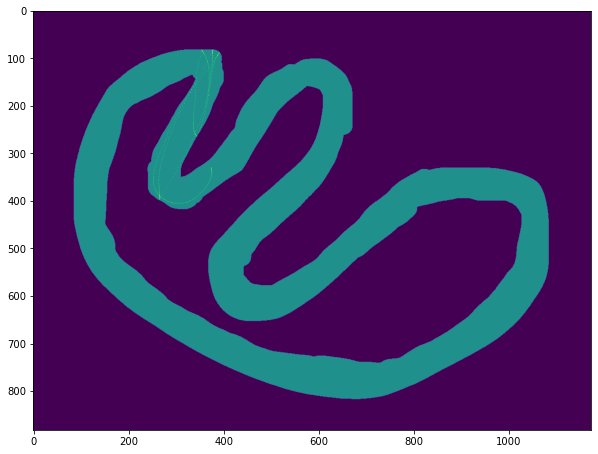

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 2s 3ms/sample - loss: 2.2179 - val_loss: 2.2135
Epoch 2/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.0134 - val_loss: 2.4677
Epoch 3/5
450/450 [==============================] - 1s 3ms/sample - loss: 1.9628 - val_loss: 2.3463
Epoch 4/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.0008 - val_loss: 1.9325
Epoch 5/5
450/450 [==============================] - 1s 3ms/sample - loss: 1.8731 - val_loss: 2.1167


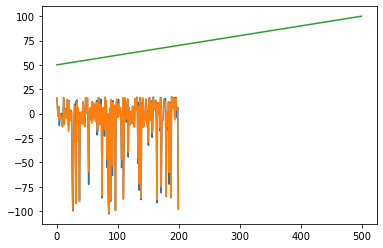

Unique speed values are: [ 0.          0.82073815  0.86803399  1.          1.05409255  1.11803399
  1.20185043  1.41421356  1.82073815  1.86803399  2.          2.05409255
  2.20185043  2.41421356  2.82073815  2.86803399  3.          3.05409255
  3.20185043  3.41421356  3.82073815  3.86803399  4.          4.05409255
  4.05409255  4.20185043  4.36803399  4.41421356  4.57073815  5.
  5.05409255  5.20185043  5.36803399  5.41421356  5.57073815  6.
  6.05409255  6.20185043  6.25        6.36803399  6.41421356  6.5
  6.57073815  6.75        7.          7.05409255  7.20185043  7.25
  7.36803399  7.41421356  7.5         7.57073815  7.75        8.
  8.05409255  8.20185043  8.25        8.36803399  8.41421356  8.5
  8.57073815  8.75        9.          9.05409255  9.07073815  9.20185043
  9.25        9.36803399  9.41421356  9.5         9.57073815 10.
 10.05409255 10.07073815 10.20185043 10.25       10.36803399 10.41421356
 11.         11.05409255 11.07073815 11.20185043 11.36803399 11.41421356
 12. 

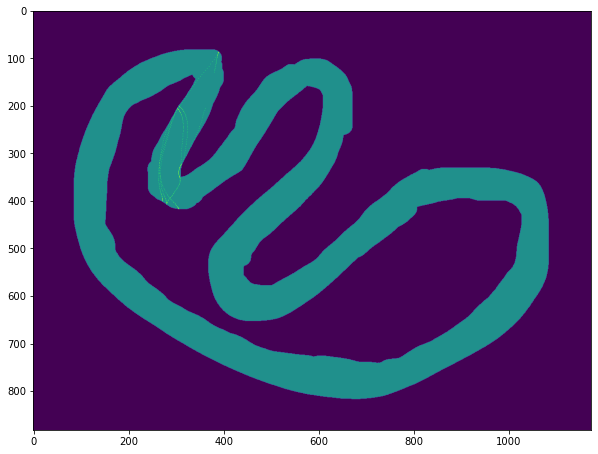

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 2s 3ms/sample - loss: 3.5056 - val_loss: 4.6903
Epoch 2/5
450/450 [==============================] - 2s 4ms/sample - loss: 3.3666 - val_loss: 4.6710
Epoch 3/5
450/450 [==============================] - 2s 4ms/sample - loss: 3.0859 - val_loss: 4.5275
Epoch 4/5
450/450 [==============================] - 1s 3ms/sample - loss: 3.1726 - val_loss: 4.6560
Epoch 5/5
450/450 [==============================] - 2s 4ms/sample - loss: 3.0634 - val_loss: 4.5883


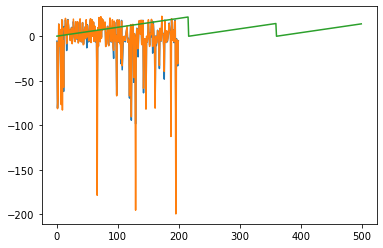

Unique speed values are: [ 0.          0.33578644  0.66421356  1.          1.05409255  1.08578644
  1.41421356  1.41421356  1.41421356  1.66421356  1.83578644  2.05409255
  2.41421356  2.41421356  2.66421356  2.83578644  3.          3.05409255
  3.16421356  3.41421356  3.41421356  3.66421356  3.83578644  4.16421356
  4.41421356  4.41421356  4.57073815  4.66421356  4.83578644  5.16421356
  5.20185043  5.41421356  5.41421356  5.66421356  5.83578644  6.16421356
  6.33578644  6.36803399  6.41421356  6.41421356  6.57073815  6.66421356
  6.83578644  7.16421356  7.20185043  7.33578644  7.36803399  7.41421356
  7.41421356  7.5         7.66421356  7.83578644  8.05409255  8.16421356
  8.25        8.33578644  8.41421356  8.5         8.58578644  9.05409255
  9.16421356  9.25        9.33578644  9.41421356  9.58578644 10.16421356
 10.41421356 10.58578644 11.         11.16421356 11.41421356 11.58578644
 12.         12.16421356 12.20185043 12.41421356 12.58578644 12.91421356
 13.16421356 13.41421356 1

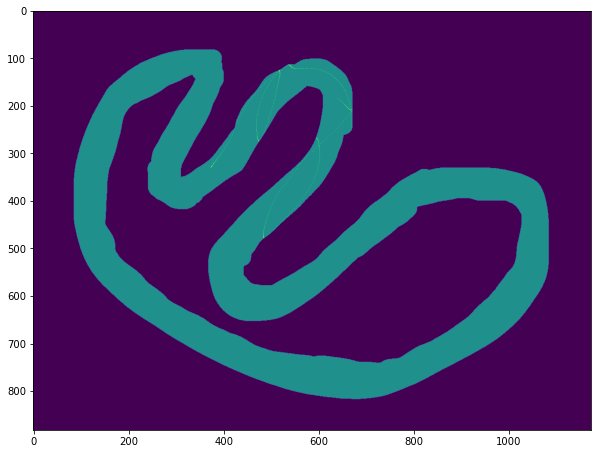

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 2s 3ms/sample - loss: 3.8321 - val_loss: 0.7250
Epoch 2/5
450/450 [==============================] - 2s 3ms/sample - loss: 3.6102 - val_loss: 0.7713
Epoch 3/5
450/450 [==============================] - 1s 3ms/sample - loss: 3.4871 - val_loss: 0.8976
Epoch 4/5
450/450 [==============================] - 2s 4ms/sample - loss: 3.4245 - val_loss: 0.8396
Epoch 5/5
450/450 [==============================] - 2s 4ms/sample - loss: 3.3120 - val_loss: 1.4054


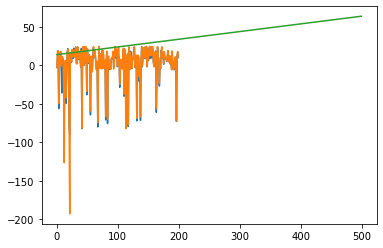

Unique speed values are: [ 0.          0.33578644  1.41421356  1.41421356  1.66421356  1.91421356
  2.16421356  2.16421356  2.41421356  2.41421356  2.83578644  2.91421356
  2.91421356  3.16421356  3.16421356  3.41421356  3.41421356  3.91421356
  4.16421356  4.16421356  4.41421356  4.41421356  4.91421356  5.16421356
  5.16421356  5.20185043  5.41421356  5.91421356  6.16421356  6.16421356
  6.41421356  6.66421356  6.91421356  7.16421356  7.16421356  7.33578644
  7.41421356  7.41421356  7.66421356  7.66421356  7.91421356  8.16421356
  8.41421356  8.58578644  8.66421356  8.66421356  8.91421356  9.16421356
  9.41421356  9.66421356  9.66421356  9.91421356 10.16421356 10.66421356
 10.66421356 10.91421356 11.         11.16421356 11.41421356 11.66421356
 11.66421356 11.91421356 12.16421356 12.16421356 12.58578644 12.66421356
 12.91421356 13.16421356 13.16421356 13.66421356 13.91421356 14.16421356
 14.16421356 14.66421356 15.16421356 15.16421356 15.66421356 16.16421356
 16.16421356 16.33578644 1

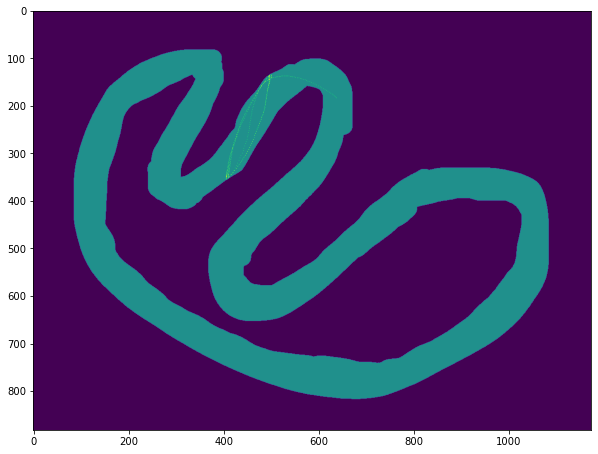

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 2s 4ms/sample - loss: 2.4009 - val_loss: 2.2152
Epoch 2/5
450/450 [==============================] - 2s 3ms/sample - loss: 2.1261 - val_loss: 2.0645
Epoch 3/5
450/450 [==============================] - 2s 4ms/sample - loss: 2.1105 - val_loss: 2.0386
Epoch 4/5
450/450 [==============================] - 2s 4ms/sample - loss: 1.9693 - val_loss: 2.5860
Epoch 5/5
450/450 [==============================] - 2s 3ms/sample - loss: 2.0584 - val_loss: 2.5791


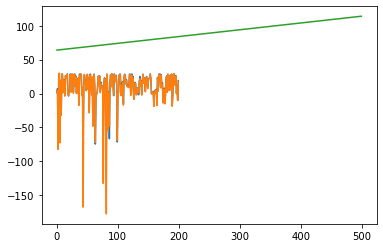

Unique speed values are: [ 0.          0.08333333  0.08333333  0.16666667  0.16666667  0.41666667
  0.41666667  0.41666667  0.41666667  0.41666667  0.41666667  0.41666667
  0.41666667  0.41666667  0.41666667  0.41666667  0.66666667  0.66666667
  0.66666667  0.83333333  0.91666667  0.91666667  1.16666667  1.41421356
  1.41421356  1.41421356  1.41666667  1.41666667  1.41666667  1.66421356
  1.66666667  1.83333333  1.91666667  1.91666667  2.16666667  2.41421356
  2.41666667  2.41666667  2.83333333  3.16421356  3.41421356  3.41666667
  3.41666667  3.83333333  4.41421356  4.41421356  4.41666667  4.41666667
  4.83333333  5.16666667  5.41421356  5.41421356  5.41666667  5.83333333
  5.91421356  6.16666667  6.41421356  6.41421356  6.41666667  6.83333333
  7.16666667  7.41421356  7.41421356  7.41666667  7.66666667  7.83333333
  8.16421356  8.41421356  8.41666667  8.66421356  8.66421356  8.66666667
  8.83333333  9.41421356  9.41666667  9.66421356  9.66421356  9.66666667
  9.83333333 10.16421356 1

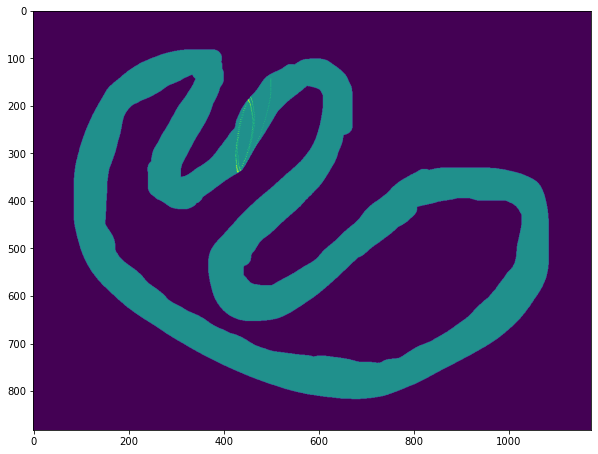

Train on 450 samples, validate on 50 samples
Epoch 1/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.6880 - val_loss: 2.7685
Epoch 2/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.5227 - val_loss: 2.2310
Epoch 3/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.4179 - val_loss: 2.1699
Epoch 4/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.2679 - val_loss: 1.7425
Epoch 5/5
450/450 [==============================] - 1s 3ms/sample - loss: 2.3122 - val_loss: 2.0032


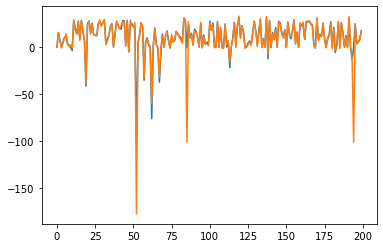

In [19]:

for train_step in range(99):
    exploration=exploration*0
    populate_replay_memory(car, target_model, actions, replay_memory,
                           insert_index, replay_size, data_scaler, usescaler, train_step, exploration, max_force,
                          disable_throttle=False, def_speed=20)
    print ("Unique speed values are: {}".format(np.unique(replay_memory[:, 8])))
    if train_step!=0:
        update_replay_memory(target_model, actions, replay_memory,
                            data_scaler, usescaler)
    np.random.shuffle(replay_memory)
    fig=plt.figure(figsize=(10, 10))
    plt.imshow(exploration+track1)
    plt.show()
    
    if train_step%15==0:
        car.re_spawn()
        
    train_y=train_y*0
    train_y[:,0]=train_y[:,0]+replay_memory[:,22]
    train_y[:,1]=train_y[:,1]+replay_memory[:,23]
    train_x=replay_memory[:,inputcolumns]
    if usescaler:
        train_x=custom_scaler(train_x, data_scaler)
        
        
    make_consistent_net.fit(train_x, train_y, batch_size=1, epochs=5, verbose=1, shuffle=True,
                            validation_split=0.1, callbacks=[early_stop, history, learning_scheduler])
    
    
    val_loss_hist=val_loss_hist+history.history['val_loss']
    train_loss_hist=train_loss_hist+history.history['loss']
    
    
    if train_step%1==0:
        plt.plot(make_consistent_net.predict(train_x)[:200])
        plt.plot(gamma*target_model.predict(train_x)[:200].reshape((200, ))+replay_memory[:200, -2])
        
    target_model.set_weights(make_consistent_net.get_weights())
    update_replay_memory(target_model, actions, replay_memory,
                         data_scaler, usescaler)
    

    

In [20]:
target_model.save("TrainedModels/trainedModelspa1.h5")

In [20]:
# 0.9*target_model.predict(train_x)[:1000].reshape((1000, ))+
a=make_consistent_net.predict(train_x)[:400].reshape((400, ))
b=replay_memory[:400, -2]
print(a.shape, b.shape)
sum(np.logical_and(a>-1, b<0))

(400,) (400,)


0

In [21]:
((make_consistent_net.predict(train_x))).max()

-5.0800858

In [22]:
make_consistent_net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  600       
_________________________________________________________________
layer_normalization (LayerNo multiple                  100       
_________________________________________________________________
dense_1 (Dense)              multiple                  5100      
_________________________________________________________________
layer_normalization_1 (Layer multiple                  200       
_________________________________________________________________
dense_2 (Dense)              multiple                  9090      
_________________________________________________________________
layer_normalization_2 (Layer multiple                  180       
_________________________________________________________________
dense_3 (Dense)              multiple                  1